In [1]:
!pip install pandas
!pip install numpy
!pip install seaborn
!pip install matplotlib

In [2]:
import warnings
warnings.filterwarnings("ignore")

A little bit about the data info https://www.kaggle.com/c/ieee-fraud-detection/discussion/101203

Loading data

In [5]:
## Import data
import pandas as pd

train_transaction = pd.read_csv("ieee-fraud-detection/train_transaction.csv")
train_transaction.head()

TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  card1  \
0        2987000        0          86400            68.5         W  13926   
1        2987001        0          86401            29.0         W   2755   
2        2987002        0          86469            59.0         W   4663   
3        2987003        0          86499            50.0         W  18132   
4        2987004        0          86506            50.0         H   4497   

   card2  card3       card4  card5  ... V330  V331  V332  V333  V334 V335  \
0    NaN  150.0    discover  142.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   
1  404.0  150.0  mastercard  102.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   
2  490.0  150.0        visa  166.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   
3  567.0  150.0  mastercard  117.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   
4  514.0  150.0  mastercard  102.0  ...  0.0   0.0   0.0   0.0   0.0  0.0   

  V336  V337  V338  V339  
0  NaN   NaN   NaN   NaN  
1  NaN   NaN   NaN   NaN  
2  NaN   NaN   NaN   NaN  
3  NaN   NaN   NaN   NaN  
4  0.0   0.0   0.0   0.0  

[5 rows x 394 columns]

In [6]:
train_identity = pd.read_csv("ieee-fraud-detection/train_identity.csv")
train_identity.head()

TransactionID  id_01     id_02  id_03  id_04  id_05  id_06  id_07  id_08  \
0        2987004    0.0   70787.0    NaN    NaN    NaN    NaN    NaN    NaN   
1        2987008   -5.0   98945.0    NaN    NaN    0.0   -5.0    NaN    NaN   
2        2987010   -5.0  191631.0    0.0    0.0    0.0    0.0    NaN    NaN   
3        2987011   -5.0  221832.0    NaN    NaN    0.0   -6.0    NaN    NaN   
4        2987016    0.0    7460.0    0.0    0.0    1.0    0.0    NaN    NaN   

   id_09  ...                id_31  id_32      id_33           id_34  id_35  \
0    NaN  ...  samsung browser 6.2   32.0  2220x1080  match_status:2      T   
1    NaN  ...   mobile safari 11.0   32.0   1334x750  match_status:1      T   
2    0.0  ...          chrome 62.0    NaN        NaN             NaN      F   
3    NaN  ...          chrome 62.0    NaN        NaN             NaN      F   
4    0.0  ...          chrome 62.0   24.0   1280x800  match_status:2      T   

  id_36 id_37  id_38  DeviceType                     DeviceInfo  
0     F     T      T      mobile  SAMSUNG SM-G892A Build/NRD90M  
1     F     F      T      mobile                     iOS Device  
2     F     T      T     desktop                        Windows  
3     F     T      T     desktop                            NaN  
4     F     T      T     desktop                          MacOS  

[5 rows x 41 columns]

In [7]:
print(train_transaction.shape)
print(train_identity.shape)

(590540, 394)
(144233, 41)


In [8]:
train_transaction['TransactionID'].duplicated().sum()

0

In [9]:
train_transaction['TransactionID'].nunique()

590540

The second table is about 25% of the first; I'll work with it later.

Reducing memory usage

The df dataset is quite large, so I'll try to reduce its size by using simpler variable types. This will help decrease memory usage and make it easier to process the data with smaller variables.

The logic is straightforward: I iterate over each column, and if the column is a numeric type, I apply a condition to check its maximum and minimum limits. I then try to fit the data into a variable type that uses the fewest bytes possible while still accommodating the values. I replace the column in the DataFrame and repeat this process until all columns are optimized.

In [13]:
import pandas as pd
import numpy as np

## Function to reduce the DF size
def reduce_mem_usage(df):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [14]:
train_transaction = reduce_mem_usage(train_transaction)

Mem. usage decreased to 542.35 Mb (69.4% reduction)


In [15]:
train_identity = reduce_mem_usage(train_identity)

Mem. usage decreased to 25.86 Mb (42.7% reduction)


it's a lot of reduction in memory consumption

In [17]:
new_df = pd.DataFrame()

Outliers

In [19]:
import pandas as pd

def treat_outliers(df, column):
    # Calculate the IQR (Interquartile Range)
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    # Define lower and upper bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Cap the outliers to the lower and upper bounds, creating a new column
    df[column + "_no_outlier"] = df[column].apply(lambda x: min(max(x, lower_bound), upper_bound))
    return df

TransactionDT

timedelta from a given reference datetime (not an actual timestamp) “TransactionDT first value is 86400, which corresponds to the number of seconds in a day (60 * 60 * 24 = 86400) so I think the unit is seconds. Using this, we know the data spans 6 months, as the maximum value is 15811131, which would correspond to day 183.”

I will divide this data by the number of seconds of the day and take the rest to try to understand how a function based on seconds of the day

In [22]:
train_transaction['time_in_seconds'] = train_transaction['TransactionDT'] % (60 * 60 * 24)
train_transaction['time_in_seconds']

0             0
1             1
2            69
3            99
4           106
          ...  
590535    86247
590536    86249
590537    86279
590538    86288
590539    86331
Name: time_in_seconds, Length: 590540, dtype: int32

In [23]:
train_transaction['time_in_seconds'].max()

86399

<Figure size 2000x1000 with 0 Axes>

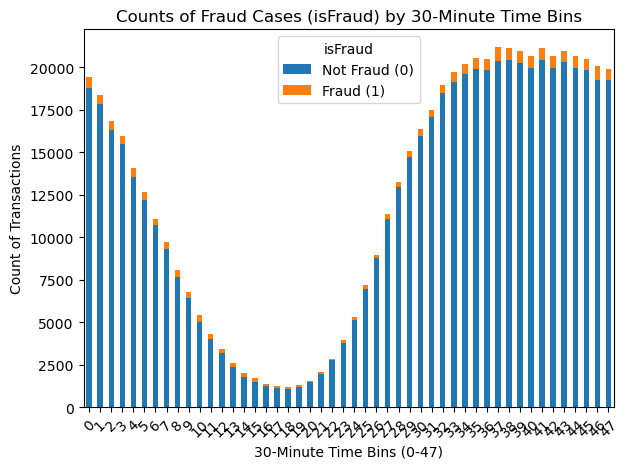

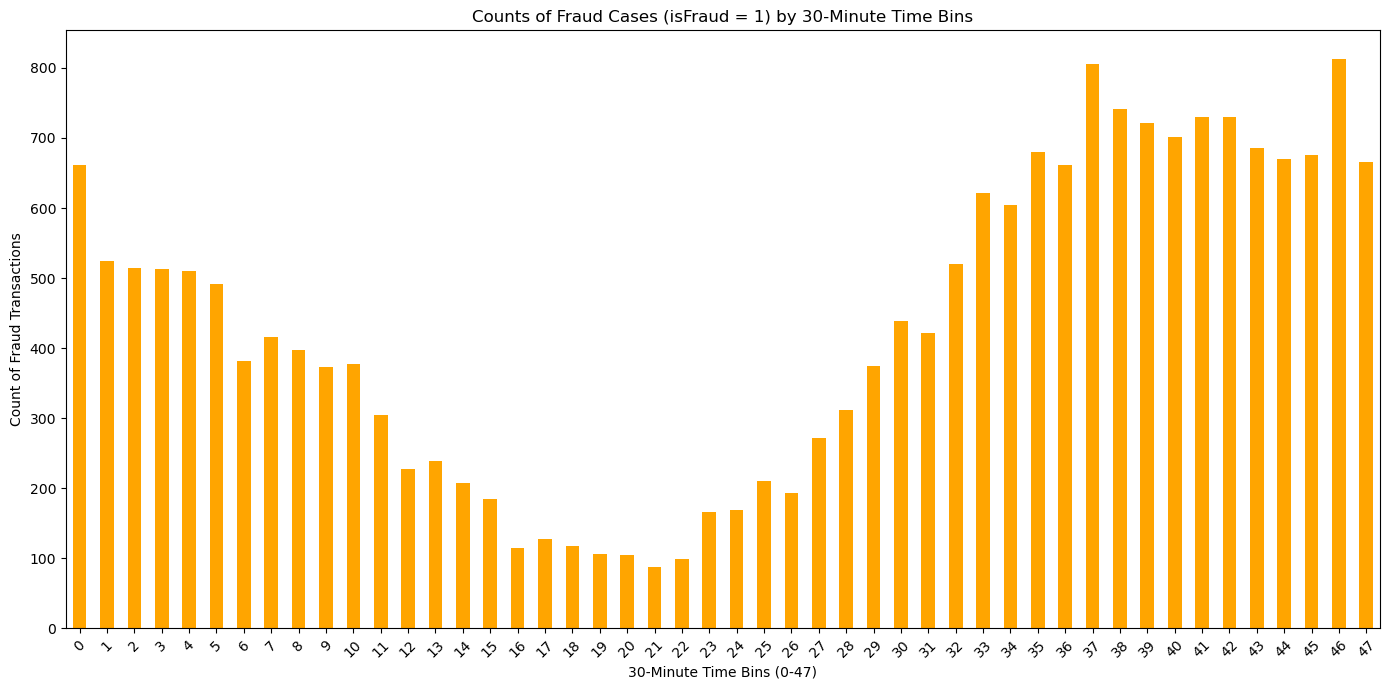

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Supondo que a coluna 'time_in_seconds' já existe em train_transaction
# Criar uma nova coluna para tempo em minutos
train_transaction['time_in_minutes'] = train_transaction['time_in_seconds'] / 60

# Definir os bins para intervalos de 30 minutos
bins = np.arange(0, train_transaction['time_in_minutes'].max() + 30, 30)

# Criar uma nova coluna para os intervalos de 30 minutos como inteiros
train_transaction['time_bins_int'] = (train_transaction['time_in_minutes'] // 30).astype(int)

# Contar as ocorrências de isFraud para cada intervalo de 30 minutos
fraud_counts = train_transaction.groupby('time_bins_int')['isFraud'].value_counts().unstack(fill_value=0)

# Plotando o gráfico de barras empilhadas para todas as transações
plt.figure(figsize=(20, 10))  # Aumenta o tamanho para ser maior e mais largo
fraud_counts.plot(kind='bar', stacked=True)
plt.title('Counts of Fraud Cases (isFraud) by 30-Minute Time Bins')
plt.xlabel('30-Minute Time Bins (0-47)')
plt.ylabel('Count of Transactions')
plt.xticks(rotation=45)
plt.legend(title='isFraud', labels=['Not Fraud (0)', 'Fraud (1)'])
plt.tight_layout()
plt.show()

# Filtrar o DataFrame para incluir apenas casos de fraude
fraud_data = train_transaction[train_transaction['isFraud'] == 1]

# Contar as ocorrências de isFraud (somente 1) para cada intervalo de 30 minutos
fraud_counts = fraud_data['time_bins_int'].value_counts().sort_index()

# Plotando o gráfico de barras para casos de fraude apenas
plt.figure(figsize=(14, 7))  # A largura permanece a mesma para o segundo gráfico
fraud_counts.plot(kind='bar', color='orange')  # Mudou a cor para laranja
plt.title('Counts of Fraud Cases (isFraud = 1) by 30-Minute Time Bins')
plt.xlabel('30-Minute Time Bins (0-47)')
plt.ylabel('Count of Fraud Transactions')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Remover as colunas temporárias após a plotagem
train_transaction.drop(columns=['time_in_minutes'], inplace=True)

del bins, fraud_data

There is a time throughout the day when fewer transactions occur.

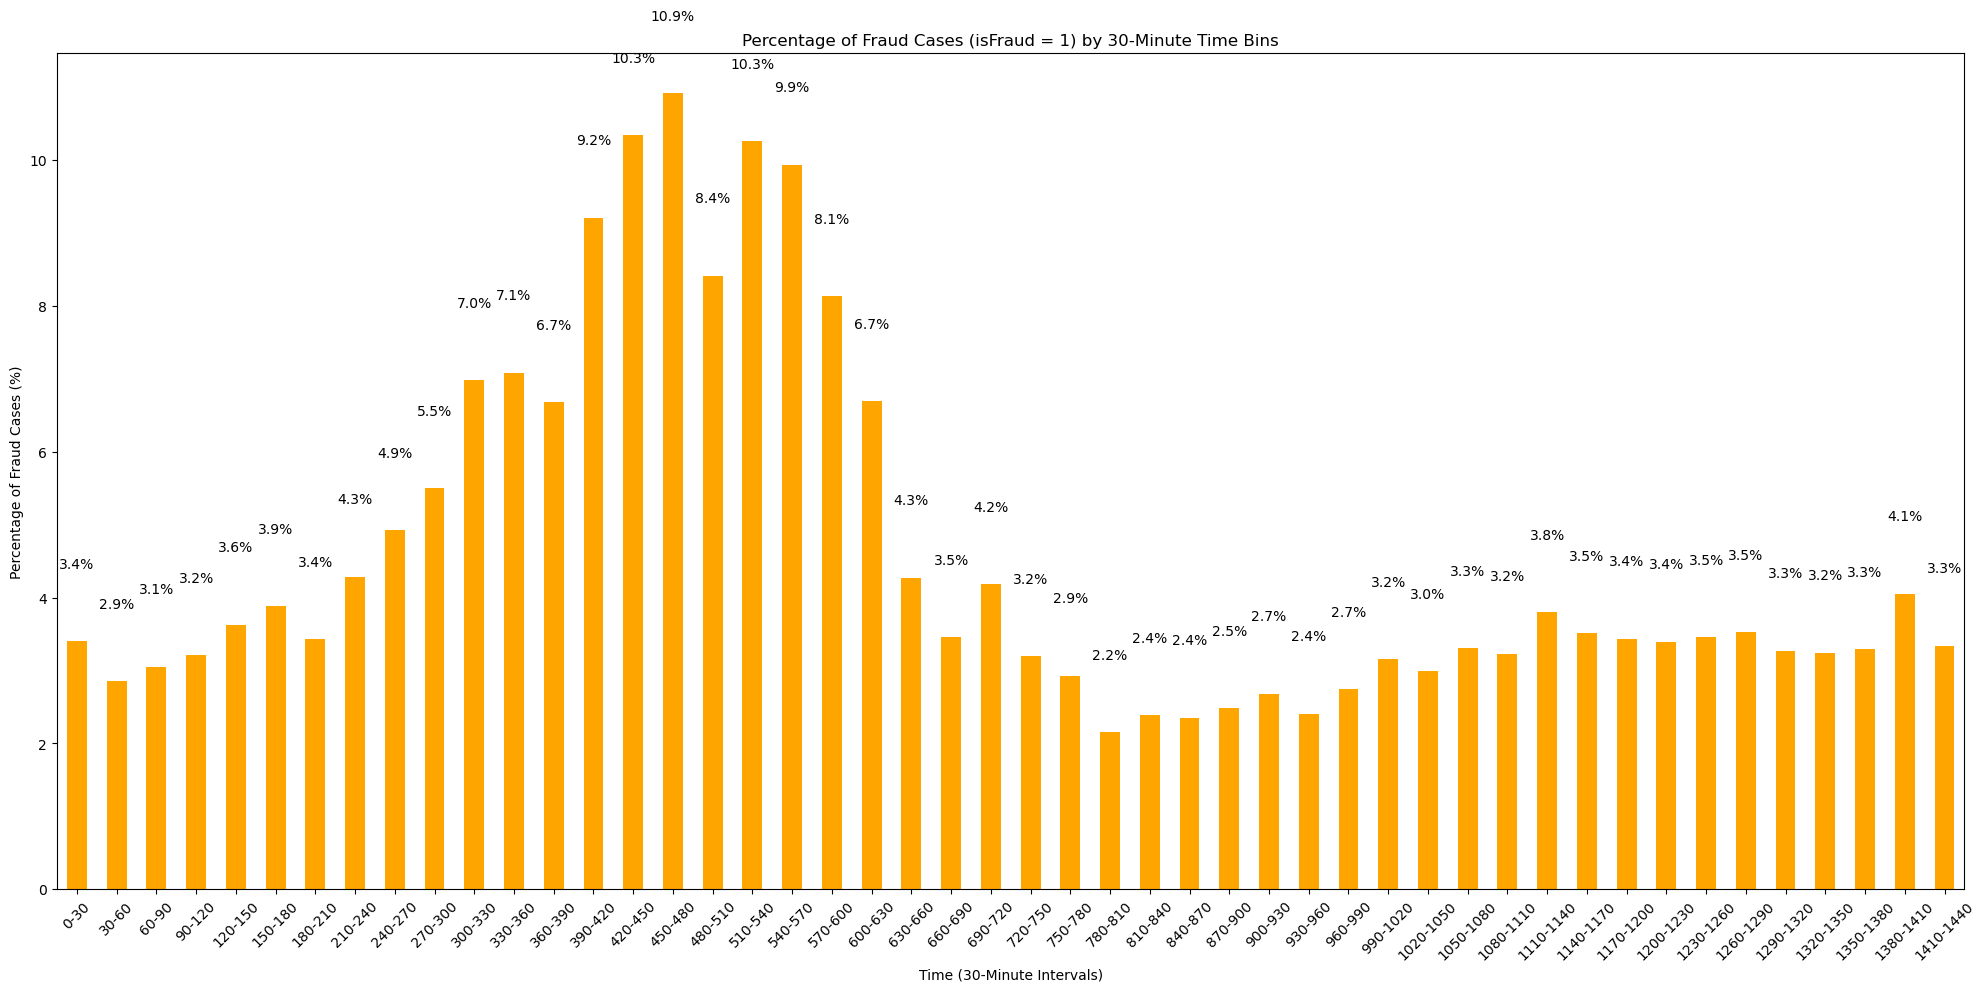

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'time_in_seconds' column already exists in train_transaction
# Create a new column for time in minutes
train_transaction['time_in_minutes'] = train_transaction['time_in_seconds'] / 60

# Define the bins for 30-minute intervals
bins = np.arange(0, train_transaction['time_in_minutes'].max() + 30, 30)
labels = [f'{int(b)}-{int(b + 30)}' for b in bins[:-1]]  # Create labels for the bins

# Create a new column for the binned data
train_transaction['time_bins'] = pd.cut(train_transaction['time_in_minutes'], bins=bins, labels=labels, right=False)

# Count the occurrences of isFraud for each time bin
fraud_counts = train_transaction.groupby('time_bins')['isFraud'].value_counts().unstack(fill_value=0)

# Calculate the percentage of fraud for each bin
fraud_percentage = (fraud_counts[1] / fraud_counts.sum(axis=1)) * 100

# Plotting the percentage of fraud by time bins
plt.figure(figsize=(20, 10))  # Set the figure size
fraud_percentage.plot(kind='bar', color='orange')  # Bar plot with orange color
plt.title('Percentage of Fraud Cases (isFraud = 1) by 30-Minute Time Bins')
plt.xlabel('Time (30-Minute Intervals)')
plt.ylabel('Percentage of Fraud Cases (%)')
plt.xticks(rotation=45)

# Adding percentage labels above the bars
for index, value in enumerate(fraud_percentage):
    plt.text(index, value + 1, f'{value:.1f}%', ha='center', color='black')  # Add percentage text above the bar

plt.tight_layout()
plt.show()

train_transaction.drop(columns=['time_in_seconds','time_in_minutes','time_bins'], inplace=True)
del bins, labels

But the time with the fewest transactions is also when the highest fraud rate occurs.

This is an interesting variable.


In [56]:
train_transaction['time_bins_int'].corr(train_transaction['isFraud'])

-0.013087331555795174

In [57]:
new_df['time_bins_int'] = train_transaction['time_bins_int']

TransactionAmt

In [59]:
# Count elements with more than 2 decimal places
more_than_two_decimals = train_transaction[train_transaction['TransactionAmt'].apply(lambda x: len(str(x).split('.')[1]) > 2 if '.' in str(x) else False)]
count_more_than_two_decimals = more_than_two_decimals.shape[0]

# Count elements with 2 or fewer decimal places
two_or_fewer_decimals = train_transaction[train_transaction['TransactionAmt'].apply(lambda x: len(str(x).split('.')[1]) <= 2 if '.' in str(x) else True)]
count_two_or_fewer_decimals = two_or_fewer_decimals.shape[0]

# Print results
print(f"Count of elements with more than 2 decimal places: {count_more_than_two_decimals}")
print(f"Count of elements with 2 or fewer decimal places: {count_two_or_fewer_decimals}")


Count of elements with more than 2 decimal places: 200663
Count of elements with 2 or fewer decimal places: 389877


In [60]:
train_transaction['TransactionAmt'].corr(train_transaction['isFraud'])

0.011319590637317887

 “Some of the transaction amounts have three decimal places to the right of the decimal point. There seems to be a link to three decimal places and a blank addr1 and addr2 field. Is it possible that these are foreign transactions and that, for example, the 75,887 in row 12 is the result of multiplying a foreign currency amount by an exchange rate?”
 
It looks like there are many foreign transactions.

In [62]:
import pandas as pd
import numpy as np

# Create a new column 'is_foreign' based on the number of decimal places in TransactionAmt
train_transaction['is_foreign'] = train_transaction['TransactionAmt'].apply(lambda x: True if str(x).split('.')[-1].__len__() > 2 else False)

# Count occurrences of isFraud for each is_foreign category
foreign_counts = train_transaction.groupby('is_foreign')['isFraud'].value_counts().unstack(fill_value=0)

# Display the counts table for foreign and not foreign
print("Number of Frauds and Non-Frauds by Transaction Status:")
print(foreign_counts)

# Calculate the total number of frauds
total_frauds = train_transaction['isFraud'].sum()

# Calculate the percentage of frauds that are foreign and not foreign
foreign_fraud_percentage = (foreign_counts.loc[True, 1] / total_frauds) * 100 if total_frauds > 0 else 0
not_foreign_fraud_percentage = (foreign_counts.loc[False, 1] / total_frauds) * 100 if total_frauds > 0 else 0

# Create a DataFrame for the percentages
fraud_percentage_df = pd.DataFrame({
    'Status': ['Foreign', 'Not Foreign'],
    'Fraud Percentage': [foreign_fraud_percentage, not_foreign_fraud_percentage]
})

# Display the fraud percentage table
print("\nFraud Percentage by Transaction Status:")
print(fraud_percentage_df)

Number of Frauds and Non-Frauds by Transaction Status:
isFraud          0      1
is_foreign               
False       377032  12845
True        192845   7818

Fraud Percentage by Transaction Status:
        Status  Fraud Percentage
0      Foreign         37.835745
1  Not Foreign         62.164255


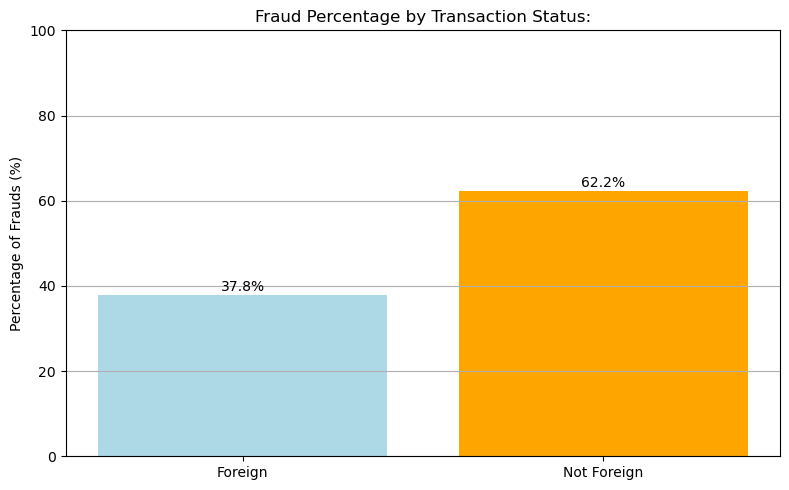

In [63]:
import matplotlib.pyplot as plt

# Plotting the percentage of fraud cases based on foreign status
plt.figure(figsize=(8, 5))

# Plotting the percentages as a bar plot
plt.bar(fraud_percentage_df['Status'], fraud_percentage_df['Fraud Percentage'], color=['lightblue', 'orange'])
plt.title('Fraud Percentage by Transaction Status:')
plt.ylabel('Percentage of Frauds (%)')
plt.ylim(0, 100)  # Set y-axis limit to 100%
plt.grid(axis='y')

# Adding percentage labels on the bars
for index, value in enumerate(fraud_percentage_df['Fraud Percentage']):
    plt.text(index, value + 1, f'{value:.1f}%', ha='center', color='black')

plt.tight_layout()
plt.show()

del fraud_percentage_df

It seems like the foreign transactions column makes a lot of sense. 

This is another interesting variable.

In [65]:
new_df['is_foreign'] = train_transaction['is_foreign']

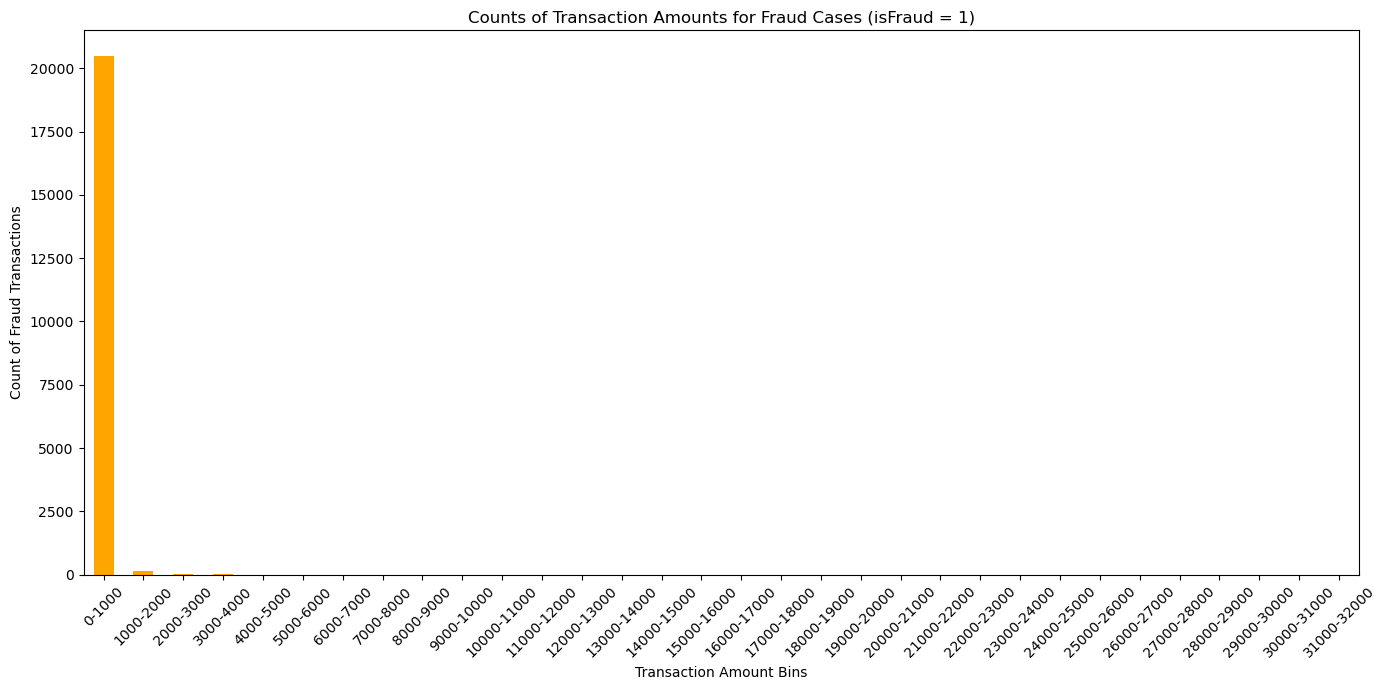

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Ensure TransactionAmt is in a compatible float type
train_transaction['TransactionAmt'] = train_transaction['TransactionAmt'].astype('float32')

# Define the bins for 1000 unit intervals for TransactionAmt
bins = np.arange(0, train_transaction['TransactionAmt'].max() + 1000, 1000)  # Change to 1000
labels = [f'{int(b)}-{int(b + 1000)}' for b in bins[:-1]]  # Create labels for the bins

# Create a new column for the binned TransactionAmt
train_transaction['amt_bins'] = pd.cut(train_transaction['TransactionAmt'], bins=bins, labels=labels, right=False)

# Count occurrences for only fraud (1) cases
fraud_counts = train_transaction[train_transaction['isFraud'] == 1]['amt_bins'].value_counts().reindex(labels, fill_value=0)

# Plotting only fraud cases with the specified bins
plt.figure(figsize=(14, 7))
fraud_counts.plot(kind='bar', color='orange')  # Changed color to orange
plt.title('Counts of Transaction Amounts for Fraud Cases (isFraud = 1)')
plt.xlabel('Transaction Amount Bins')
plt.ylabel('Count of Fraud Transactions')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Remove the temporary column after plotting
train_transaction.drop(columns=['amt_bins'], inplace=True)

del bins, labels, fraud_counts

This graph appears to have an issue related to outliers. Let's try to correct that.

In [68]:
train_transaction = treat_outliers(train_transaction,"TransactionAmt")

In [69]:
train_transaction['TransactionAmt_no_outlier']

0          68.500000
1          29.000000
2          59.000000
3          50.000000
4          50.000000
             ...    
590535     49.000000
590536     39.500000
590537     30.953125
590538    117.000000
590539    247.531250
Name: TransactionAmt_no_outlier, Length: 590540, dtype: float64

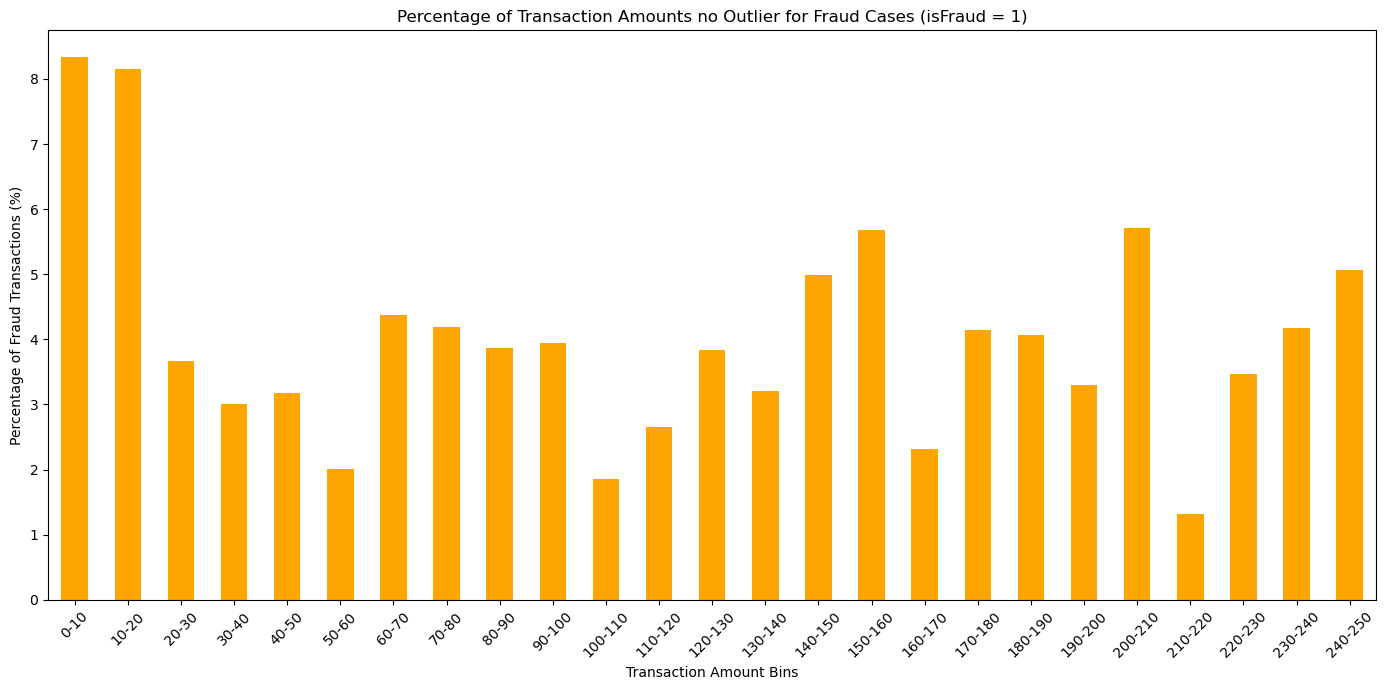

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Ensure TransactionAmt is in a compatible float type
train_transaction['TransactionAmt_no_outlier'] = train_transaction['TransactionAmt_no_outlier'].astype('float32')

# Define the bins for 10 unit intervals for TransactionAmt no outliers
bins = np.arange(0, train_transaction['TransactionAmt_no_outlier'].max() + 10, 10)  # Change to 1000
labels = [f'{int(b)}-{int(b + 10)}' for b in bins[:-1]]  # Create labels for the bins

# Create a new column for the binned TransactionAmt
train_transaction['amt_bins'] = pd.cut(train_transaction['TransactionAmt_no_outlier'], bins=bins, labels=labels, right=False)

# Count occurrences for fraud (1) and total transactions in each bin
fraud_counts = train_transaction[train_transaction['isFraud'] == 1]['amt_bins'].value_counts().reindex(labels, fill_value=0)
total_counts = train_transaction['amt_bins'].value_counts().reindex(labels, fill_value=0)

# Calculate the percentage of fraud transactions
fraud_percentage = (fraud_counts / total_counts) * 100

# Plotting the percentage of fraud cases with the specified bins
plt.figure(figsize=(14, 7))
fraud_percentage.plot(kind='bar', color='orange')  # Changed color to orange
plt.title('Percentage of Transaction Amounts no Outlier for Fraud Cases (isFraud = 1)')
plt.xlabel('Transaction Amount Bins')
plt.ylabel('Percentage of Fraud Transactions (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Remove the temporary column after plotting
train_transaction.drop(columns=['amt_bins'], inplace=True)

del bins, labels, fraud_counts, total_counts, fraud_percentage

With the removal of outliers, the data started to make more sense, and there is considerable variation within the range. 

This is an interesting characteristic.

In [72]:
new_df['TransactionAmt_no_outlier'] = train_transaction['TransactionAmt_no_outlier']

In [73]:
train_transaction['TransactionAmt_no_outlier'].corr(train_transaction['isFraud'])

0.014445286295365022

In [74]:
train_transaction['TransactionAmt'].corr(train_transaction['isFraud'])

0.011319590637317887

In [75]:
train_transaction['is_foreign'].corr(train_transaction['isFraud'])

0.015502931306372012

ProductCD

In [77]:
train_transaction['ProductCD'].unique()

array(['W', 'H', 'C', 'S', 'R'], dtype=object)

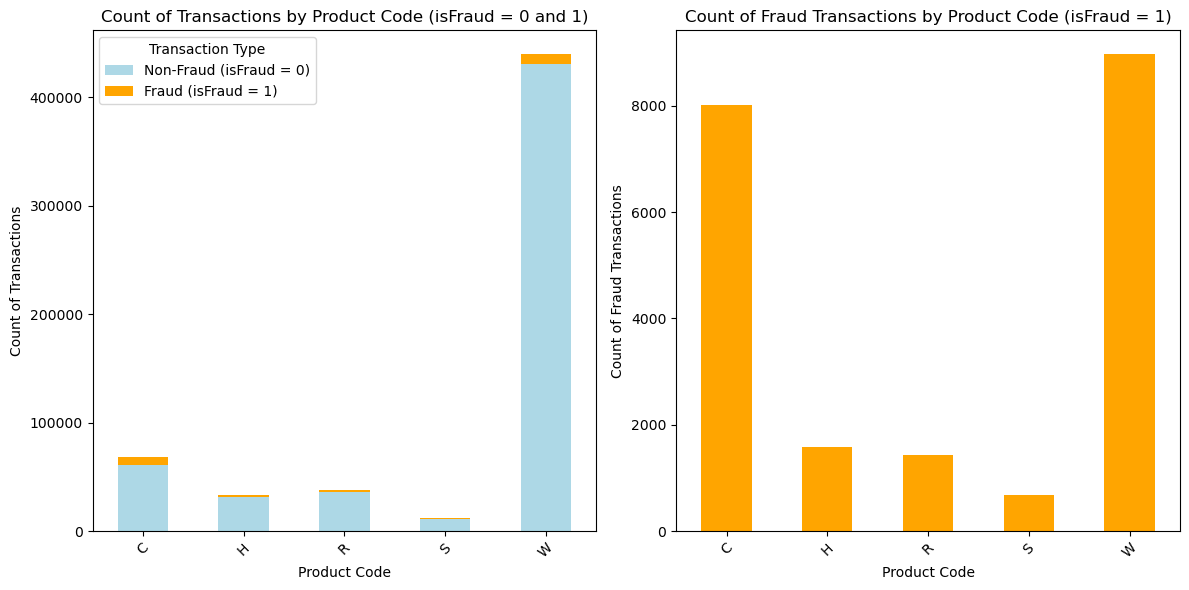

In [78]:
import pandas as pd
import matplotlib.pyplot as plt

# Count occurrences of each ProductCD for both fraud (isFraud = 1) and non-fraud (isFraud = 0) cases
fraud_counts = train_transaction[train_transaction['isFraud'] == 1]['ProductCD'].value_counts()
non_fraud_counts = train_transaction[train_transaction['isFraud'] == 0]['ProductCD'].value_counts()

# Create a DataFrame to hold both counts and ensure the order of the index
counts_df = pd.DataFrame({
    'Non-Fraud': non_fraud_counts,
    'Fraud': fraud_counts  # Place Fraud counts second to stack on top of Non-Fraud
}).fillna(0)  # Fill NaN values with 0 for products that have no counts

# Ensure the order of ProductCD categories is maintained
counts_df = counts_df.reindex(sorted(counts_df.index), fill_value=0)

# Plotting both counts
plt.figure(figsize=(12, 6))

# Plot 1: Stacked counts for both isFraud = 0 and isFraud = 1
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
counts_df.plot(kind='bar', stacked=True, ax=plt.gca(), color=['lightblue', 'orange'])  # Using light blue and orange colors
plt.title('Count of Transactions by Product Code (isFraud = 0 and 1)')
plt.xlabel('Product Code')
plt.ylabel('Count of Transactions')
plt.xticks(rotation=45)
plt.legend(title='Transaction Type', labels=['Non-Fraud (isFraud = 0)', 'Fraud (isFraud = 1)'])
plt.tight_layout()

# Plot 2: Counts only for isFraud = 1
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
fraud_counts = fraud_counts.reindex(sorted(counts_df.index), fill_value=0)  # Ensure the same order for fraud counts
fraud_counts.plot(kind='bar', color='orange', ax=plt.gca())  # Using orange for fraud
plt.title('Count of Fraud Transactions by Product Code (isFraud = 1)')
plt.xlabel('Product Code')
plt.ylabel('Count of Fraud Transactions')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


del counts_df, fraud_counts, non_fraud_counts

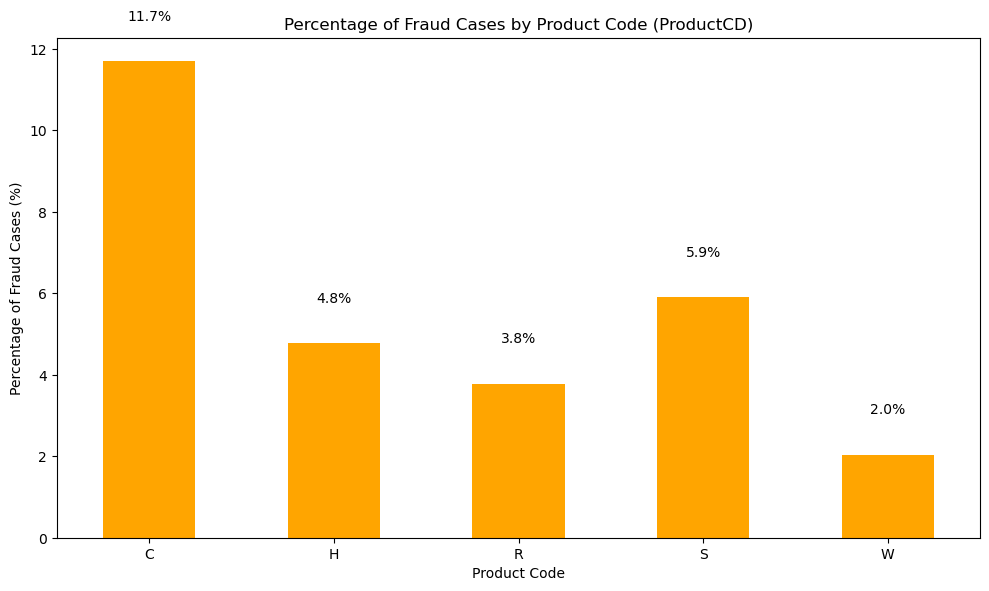

In [79]:
import pandas as pd
import matplotlib.pyplot as plt

# Count occurrences of each ProductCD for both fraud (isFraud = 1) and total transactions
fraud_counts = train_transaction[train_transaction['isFraud'] == 1]['ProductCD'].value_counts()
total_counts = train_transaction['ProductCD'].value_counts()

# Create a DataFrame to hold both counts
counts_df = pd.DataFrame({
    'Fraud': fraud_counts,
    'Total': total_counts
}).fillna(0)  # Fill NaN values with 0 for products that have no counts

# Calculate the percentage of fraud for each ProductCD
counts_df['Fraud Percentage'] = (counts_df['Fraud'] / counts_df['Total']) * 100

# Plotting the percentage of fraud by ProductCD
plt.figure(figsize=(10, 6))  # Set the figure size
counts_df['Fraud Percentage'].plot(kind='bar', color='orange')  # Bar plot with orange color
plt.title('Percentage of Fraud Cases by Product Code (ProductCD)')
plt.xlabel('Product Code')
plt.ylabel('Percentage of Fraud Cases (%)')
plt.xticks(rotation=0)  # Horizontal labels

# Adding percentage labels above the bars
for index, value in enumerate(counts_df['Fraud Percentage']):
    plt.text(index, value + 1, f'{value:.1f}%', ha='center', color='black')  # Add percentage text above the bar

plt.tight_layout()
plt.show()

We observe a variety depending on the class.

It's another interesting variable.

In [81]:
one_hot_encoded = pd.get_dummies(train_transaction['ProductCD'], prefix='ProductCD')
new_df = pd.concat([new_df, one_hot_encoded], axis=1)

card1 - card6: payment card information, such as card type, card category, issue bank, country, etc.

These are categorical columns, so let's apply the same reasoning as we did with ProductCD.

The goal is to examine whether there is variation based on fraud and class.ed

In [84]:
import pandas as pd

# Assuming train_transaction DataFrame exists with card1 to card6 columns

# Create a dictionary to store results
results = {
    'card': [],
    'class_count': [],
    'null_count': []
}

# Loop through each card column
for i in range(1, 7):
    card_col = f'card{i}'
    
    # Count unique classes
    class_count = train_transaction[card_col].nunique()
    
    # Count null values
    null_count = train_transaction[card_col].isnull().sum()
    
    # Store results
    results['card'].append(card_col)
    results['class_count'].append(class_count)
    results['null_count'].append(null_count)

# Create a DataFrame from results
results_df = pd.DataFrame(results)

# Display the results DataFrame
print(results_df)

    card  class_count  null_count
0  card1        13553           0
1  card2          500        8933
2  card3          114        1565
3  card4            4        1577
4  card5          119        4259
5  card6            4        1571


I will create a function that takes a categorical column, identifies the top 5 most frequent elements, transforms the remaining elements into 'Others,' and preserves the null values.

In [86]:
import pandas as pd

def top5_with_others(column: pd.Series) -> pd.Series:
    # Identify the 5 most frequent categories, ignoring null values
    top_5 = column.value_counts().nlargest(5).index
    
    # Apply transformation: keep top 5, convert others to 'Others', and retain nulls
    new_column = column.apply(lambda x: x if x in top_5 or pd.isnull(x) else 'Others')
    
    return new_column

In [87]:
train_transaction['card1'] = top5_with_others(train_transaction['card1'])
train_transaction['card2'] = top5_with_others(train_transaction['card2'])
train_transaction['card3'] = top5_with_others(train_transaction['card3'])
train_transaction['card5'] = top5_with_others(train_transaction['card5'])

In [88]:
import pandas as pd

# Assuming the DataFrame train_transaction already exists

# Create a dictionary to store results
results = {
    'card': [],
    'class_count': [],
    'null_count': [],
    'null_percentage': []
}

# Loop through each card column
for i in range(1, 7):
    card_col = f'card{i}'
    
    # Count unique classes
    class_count = train_transaction[card_col].nunique()
    
    # Count null values
    null_count = train_transaction[card_col].isnull().sum()
    
    # Total entries in the column
    total_count = train_transaction[card_col].shape[0]  # Total entries

    # Calculate the percentage of nulls
    null_percentage = (null_count / total_count) * 100 if total_count > 0 else 0  # Percentage of nulls

    # Store results
    results['card'].append(card_col)
    results['class_count'].append(class_count)
    results['null_count'].append(null_count)
    results['null_percentage'].append(null_percentage)

# Create a DataFrame with the results
results_df = pd.DataFrame(results)

# Display the results DataFrame
print(results_df)

    card  class_count  null_count  null_percentage
0  card1            6           0         0.000000
1  card2            6        8933         1.512683
2  card3            6        1565         0.265012
3  card4            4        1577         0.267044
4  card5            6        4259         0.721204
5  card6            4        1571         0.266028


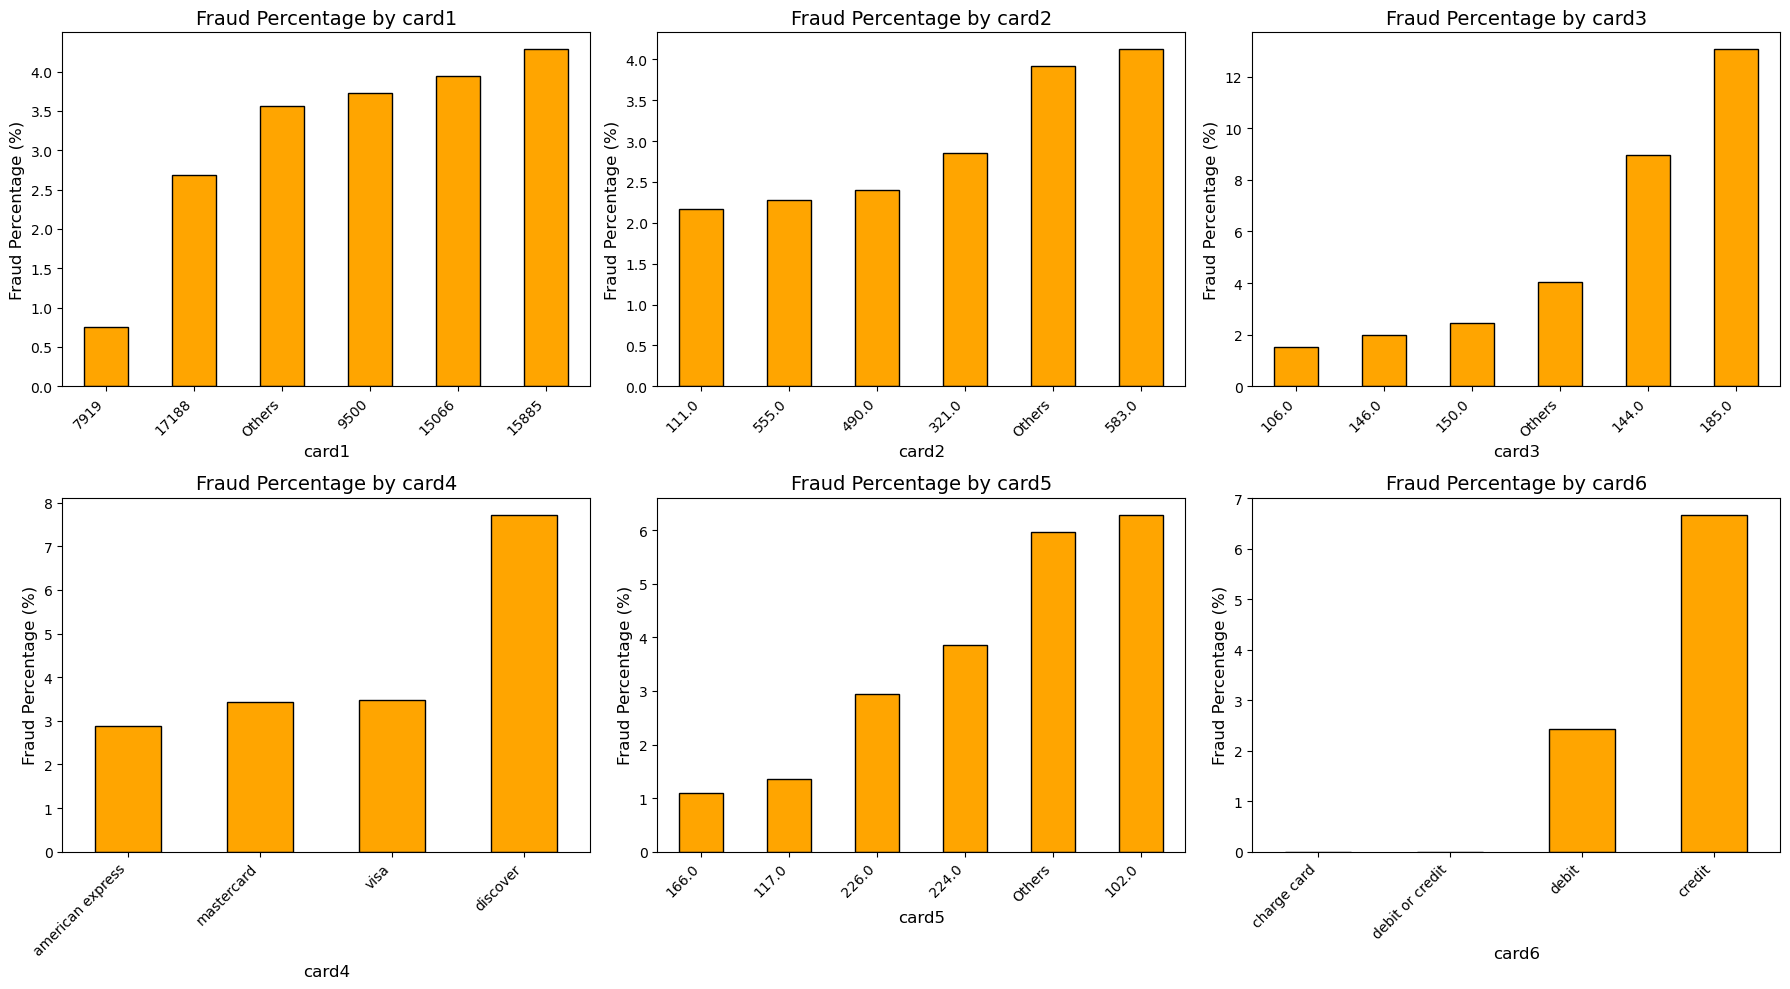

In [89]:
import matplotlib.pyplot as plt

# Function to calculate and plot the fraud percentage by category in a column
def plot_fraud_percentage_by_category(data, column, ax):
    # Calculate the fraud rate (percentage) for each category in the column
    fraud_percentage = data.groupby(column)['isFraud'].mean() * 100
    
    # Plot the fraud rate for each category in the column
    fraud_percentage.sort_values().plot(kind='bar', color='orange', edgecolor='black', ax=ax)
    
    # Graph settings
    ax.set_title(f'Fraud Percentage by {column}', fontsize=14)
    ax.set_xlabel(column, fontsize=12)
    ax.set_ylabel('Fraud Percentage (%)', fontsize=12)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# Create multiple subplots side by side
fig, axes = plt.subplots(2, 3, figsize=(18, 10))  # 2 rows, 3 columns to accommodate 6 graphs
fig.subplots_adjust(hspace=0.4, wspace=0.4)  # Adjust the spacing between graphs

# Iterate over each card column (1 to 6) and generate a graph
for col, ax in zip(['card1', 'card2', 'card3', 'card4', 'card5', 'card6'], axes.flatten()):
    plot_fraud_percentage_by_category(train_transaction, col, ax)

plt.tight_layout()
plt.show()

In [90]:
import pandas as pd

# Assuming the DataFrame train_transaction already exists

# Select the columns of interest
card_columns = ['card1', 'card2', 'card3', 'card4', 'card5', 'card6']

# Apply One Hot Encoding
one_hot_encoded = pd.get_dummies(train_transaction[card_columns], drop_first=True)

# Add the 'isFraud' column to the resulting DataFrame for comparison
one_hot_encoded['isFraud'] = train_transaction['isFraud']

# Calculate the correlation between the One Hot columns and the 'isFraud' column
correlation = one_hot_encoded.corr()['isFraud'].drop('isFraud')

# Display the correlation
print(correlation)
del one_hot_encoded

card1_9500               0.001956
card1_15066              0.002800
card1_15885              0.005718
card1_17188             -0.005896
card1_Others             0.010718
card2_321.0             -0.010571
card2_490.0             -0.015697
card2_555.0             -0.018301
card2_583.0              0.006652
card2_Others             0.031011
card3_144.0              0.013663
card3_146.0             -0.003768
card3_150.0             -0.155608
card3_185.0              0.169085
card3_Others             0.003321
card4_discover           0.024564
card4_mastercard        -0.002463
card4_visa              -0.001741
card5_117.0             -0.024897
card5_166.0             -0.042685
card5_224.0              0.008011
card5_226.0             -0.029916
card5_Others             0.059227
card6_credit             0.100508
card6_debit             -0.099779
card6_debit or credit   -0.001357
Name: isFraud, dtype: float64


card 3 and 6 might make some sense. 

I will add them as interesting variables.

In [92]:
one_hot_encoded = pd.get_dummies(train_transaction['card3'], prefix='card3')
new_df = pd.concat([new_df, one_hot_encoded], axis=1)

one_hot_encoded = pd.get_dummies(train_transaction['card6'], prefix='card6')
new_df = pd.concat([new_df, one_hot_encoded], axis=1)

addr1, addr2, P_emaildomain and R_emaildomain 

The idea is to perform a similar analysis as we did previously. We will select the top 5 categories, analyze the percentage of fraud for each, and assess whether any of them have a significant influence.

In [95]:
import pandas as pd

# Columns of interest
columns_of_interest = ['addr1', 'addr2', 'P_emaildomain', 'R_emaildomain']

# Dictionary to store results
results = {
    'column': [],
    'class_count': [],
    'null_count': [],
    'null_percentage': []
}

# Loop through each column of interest
for col in columns_of_interest:
    # Count unique classes
    class_count = train_transaction[col].nunique()
    
    # Count null values
    null_count = train_transaction[col].isnull().sum()
    
    # Total entries in the column
    total_count = train_transaction[col].shape[0]  # Total number of entries

    # Calculate percentage of nulls
    null_percentage = (null_count / total_count) * 100 if total_count > 0 else 0  # Percentage of nulls

    # Store results
    results['column'].append(col)
    results['class_count'].append(class_count)
    results['null_count'].append(null_count)
    results['null_percentage'].append(null_percentage)

# Create a DataFrame from the results
results_df = pd.DataFrame(results)

# Display the results DataFrame
print(results_df)

          column  class_count  null_count  null_percentage
0          addr1          332       65706        11.126427
1          addr2           74       65706        11.126427
2  P_emaildomain           59       94456        15.994852
3  R_emaildomain           60      453249        76.751617


The R_emaildomain column has a substantial amount of missing data, making it less interesting for analysis.

In [97]:
train_transaction['addr1'] = top5_with_others(train_transaction['addr1'])
train_transaction['addr2'] = top5_with_others(train_transaction['addr2'])
train_transaction['P_emaildomain'] = top5_with_others(train_transaction['P_emaildomain'])
train_transaction['R_emaildomain'] = top5_with_others(train_transaction['R_emaildomain'])

In [98]:
import pandas as pd

# Columns of interest
columns_of_interest = ['addr1', 'addr2', 'P_emaildomain', 'R_emaildomain']

# Dictionary to store results
results = {
    'column': [],
    'class_count': [],
    'null_count': [],
    'null_percentage': []
}

# Loop through each column of interest
for col in columns_of_interest:
    # Count unique classes
    class_count = train_transaction[col].nunique()
    
    # Count null values
    null_count = train_transaction[col].isnull().sum()
    
    # Total entries in the column
    total_count = train_transaction[col].shape[0]  # Total number of entries

    # Calculate percentage of nulls
    null_percentage = (null_count / total_count) * 100 if total_count > 0 else 0  # Percentage of nulls

    # Store results
    results['column'].append(col)
    results['class_count'].append(class_count)
    results['null_count'].append(null_count)
    results['null_percentage'].append(null_percentage)

# Create a DataFrame from the results
results_df = pd.DataFrame(results)

# Display the results DataFrame
print(results_df)

          column  class_count  null_count  null_percentage
0          addr1            6       65706        11.126427
1          addr2            6       65706        11.126427
2  P_emaildomain            6       94456        15.994852
3  R_emaildomain            6      453249        76.751617


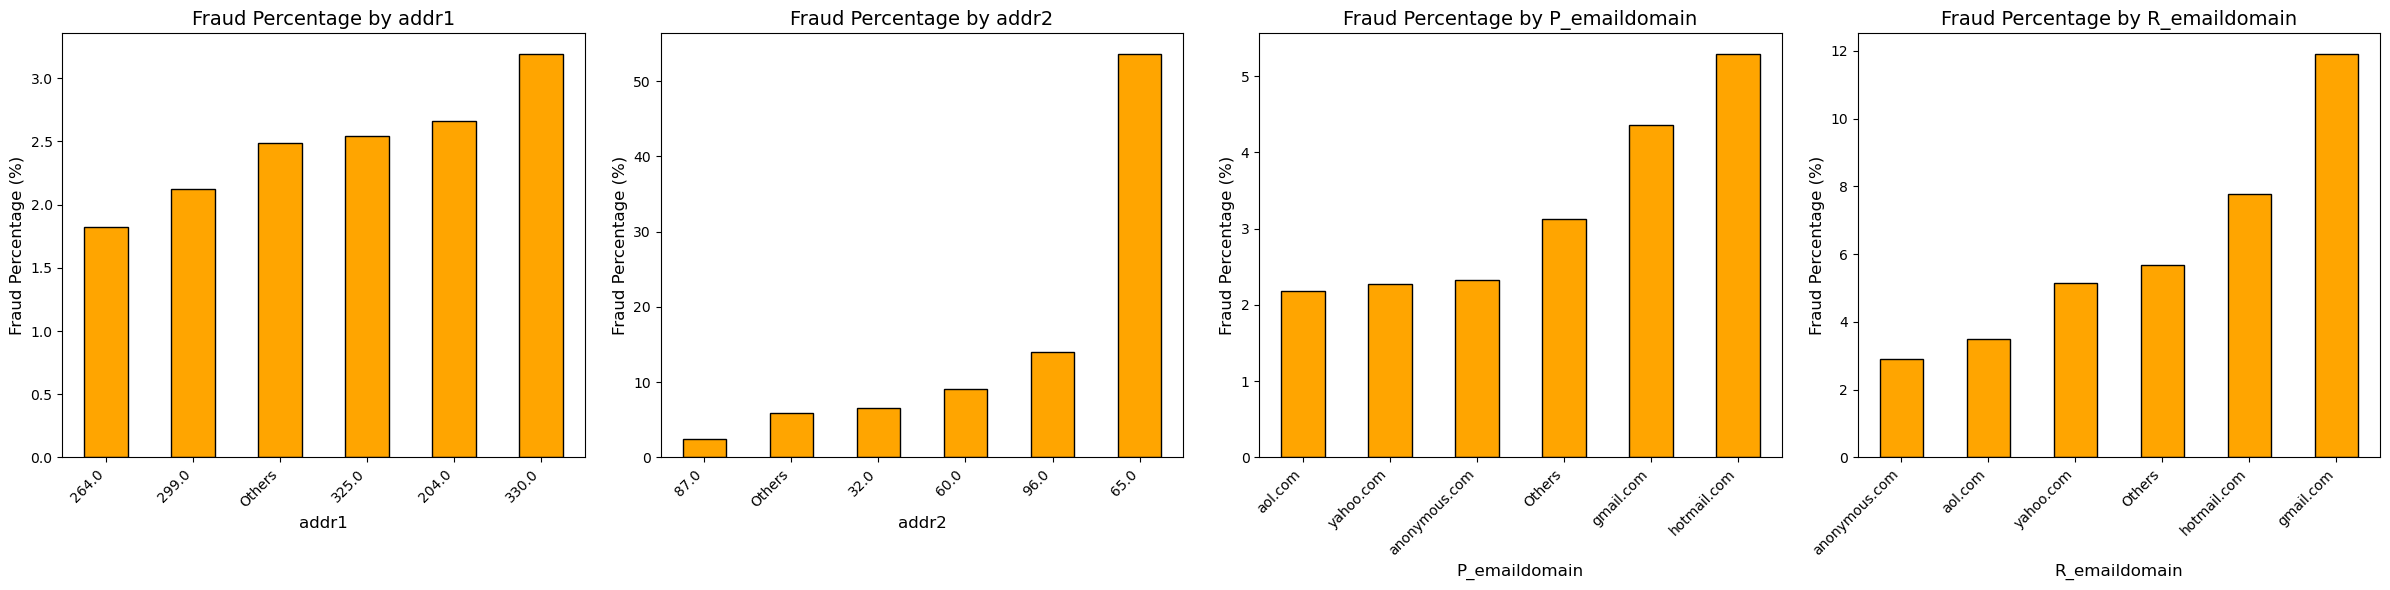

In [99]:
import matplotlib.pyplot as plt

# Function to calculate and plot the percentage of fraud by category in a column
def plot_fraud_percentage_by_category(data, column, ax):
    # Calculate the fraud rate (percentage) for each category in the column
    fraud_percentage = data.groupby(column)['isFraud'].mean() * 100
    
    # Plot the fraud rate for each category in the column
    fraud_percentage.sort_values().plot(kind='bar', color='orange', edgecolor='black', ax=ax)
    
    # Graph settings
    ax.set_title(f'Fraud Percentage by {column}', fontsize=14)
    ax.set_xlabel(column, fontsize=12)
    ax.set_ylabel('Fraud Percentage (%)', fontsize=12)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# Columns for the plot
columns_of_interest = ['addr1', 'addr2', 'P_emaildomain', 'R_emaildomain']

# Create multiple subplots
fig, axes = plt.subplots(1, 4, figsize=(24, 6))  # One row, four columns to accommodate 4 plots
fig.subplots_adjust(hspace=0.4, wspace=0.4)  # Adjust spacing between plots

# Iterate over each column and generate a plot
for col, ax in zip(columns_of_interest, axes.flatten()):
    plot_fraud_percentage_by_category(train_transaction, col, ax)

plt.tight_layout()
plt.show()

Of these variables, I found addr2 interesting. She seems to be quite representative. 

It is a variable of interest.

In [101]:
one_hot_encoded = pd.get_dummies(train_transaction['addr2'], prefix='addr2')
new_df = pd.concat([new_df, one_hot_encoded], axis=1)

In [102]:
import pandas as pd

# Select the columns of interest and the 'isFraud' column for a temporary DataFrame
columns_of_interest = ['addr1', 'addr2', 'P_emaildomain', 'R_emaildomain']
temp_df = train_transaction[columns_of_interest + ['isFraud']].copy()

# Apply one-hot encoding to the categorical columns
temp_df_encoded = pd.get_dummies(temp_df, columns=columns_of_interest, drop_first=True)

# Calculate the correlation of all columns resulting from one-hot encoding with 'isFraud'
correlations = temp_df_encoded.corr()['isFraud'].drop('isFraud')  # Remove the correlation of 'isFraud' with itself

# Display the correlations
print(correlations)

addr1_264.0                   -0.024499
addr1_299.0                   -0.021805
addr1_325.0                   -0.014540
addr1_330.0                   -0.003565
addr1_Others                  -0.061183
addr2_60.0                     0.021875
addr2_65.0                     0.032168
addr2_87.0                    -0.163431
addr2_96.0                     0.018704
addr2_Others                   0.003633
P_emaildomain_anonymous.com   -0.016563
P_emaildomain_aol.com         -0.016088
P_emaildomain_gmail.com        0.036954
P_emaildomain_hotmail.com      0.028156
P_emaildomain_yahoo.com       -0.030226
R_emaildomain_anonymous.com   -0.006053
R_emaildomain_aol.com         -0.000058
R_emaildomain_gmail.com        0.149974
R_emaildomain_hotmail.com      0.051488
R_emaildomain_yahoo.com        0.012862
Name: isFraud, dtype: float64


<Figure size 1400x800 with 0 Axes>

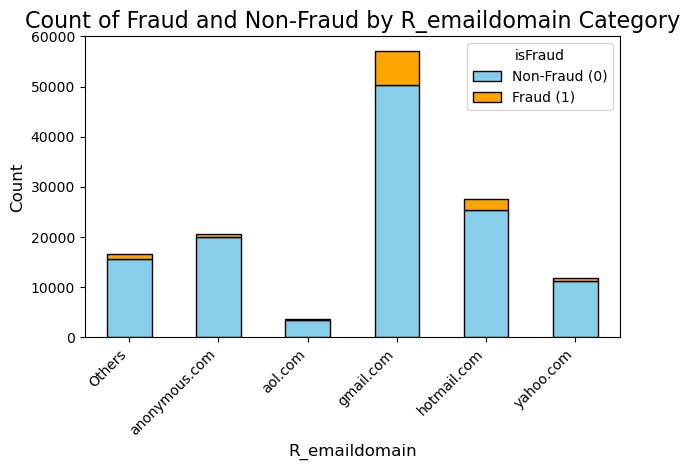

In [103]:
import pandas as pd
import matplotlib.pyplot as plt

# Group by 'R_emaildomain' and 'isFraud', counting the occurrences of each combination
fraud_counts = train_transaction.groupby(['R_emaildomain', 'isFraud']).size().unstack(fill_value=0)

# Set up the stacked bar chart
plt.figure(figsize=(14, 8))
fraud_counts.plot(kind='bar', stacked=True, color=['skyblue', 'orange'], edgecolor='black')

# Chart settings
plt.title('Count of Fraud and Non-Fraud by R_emaildomain Category', fontsize=16)
plt.xlabel('R_emaildomain', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='isFraud', labels=['Non-Fraud (0)', 'Fraud (1)'])

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plot
plt.show()

Maybe the R_emaildomain variable makes sense, but as there is a lot of missing data I will leave it for a second moment.

M1-M9

M1-M9: match, such as names on card and address, etc.

The goal is to apply a similar approach as we did previously. We'll select the top five categories from the categorical data, analyze the percentage of fraud, and determine if any of these categories have a significant influence.

In [107]:
import pandas as pd

# Create a dictionary to store results
results = {
    'M': [],
    'class_count': [],
    'null_count': [],
    'null_percentage': []
}

# Loop through each M column from M1 to M9
for i in range(1, 10):
    m_col = f'M{i}'
    
    # Count unique classes
    class_count = train_transaction[m_col].nunique()
    
    # Count null values
    null_count = train_transaction[m_col].isnull().sum()
    
    # Total entries in the column
    total_count = train_transaction[m_col].shape[0]  # Total number of entries

    # Calculate percentage of nulls
    null_percentage = (null_count / total_count) * 100 if total_count > 0 else 0  # Percentage of nulls

    # Store results
    results['M'].append(m_col)
    results['class_count'].append(class_count)
    results['null_count'].append(null_count)
    results['null_percentage'].append(null_percentage)

# Create a DataFrame from results
results_df = pd.DataFrame(results)

# Display the results DataFrame
print(results_df)

    M  class_count  null_count  null_percentage
0  M1            2      271100        45.907136
1  M2            2      271100        45.907136
2  M3            2      271100        45.907136
3  M4            3      281444        47.658753
4  M5            2      350482        59.349409
5  M6            2      169360        28.678836
6  M7            2      346265        58.635317
7  M8            2      346252        58.633115
8  M9            2      346252        58.633115


There is a significant amount of missing data, so I don’t believe these variables will be useful. Let's simply check the percentage of nulls for each class.

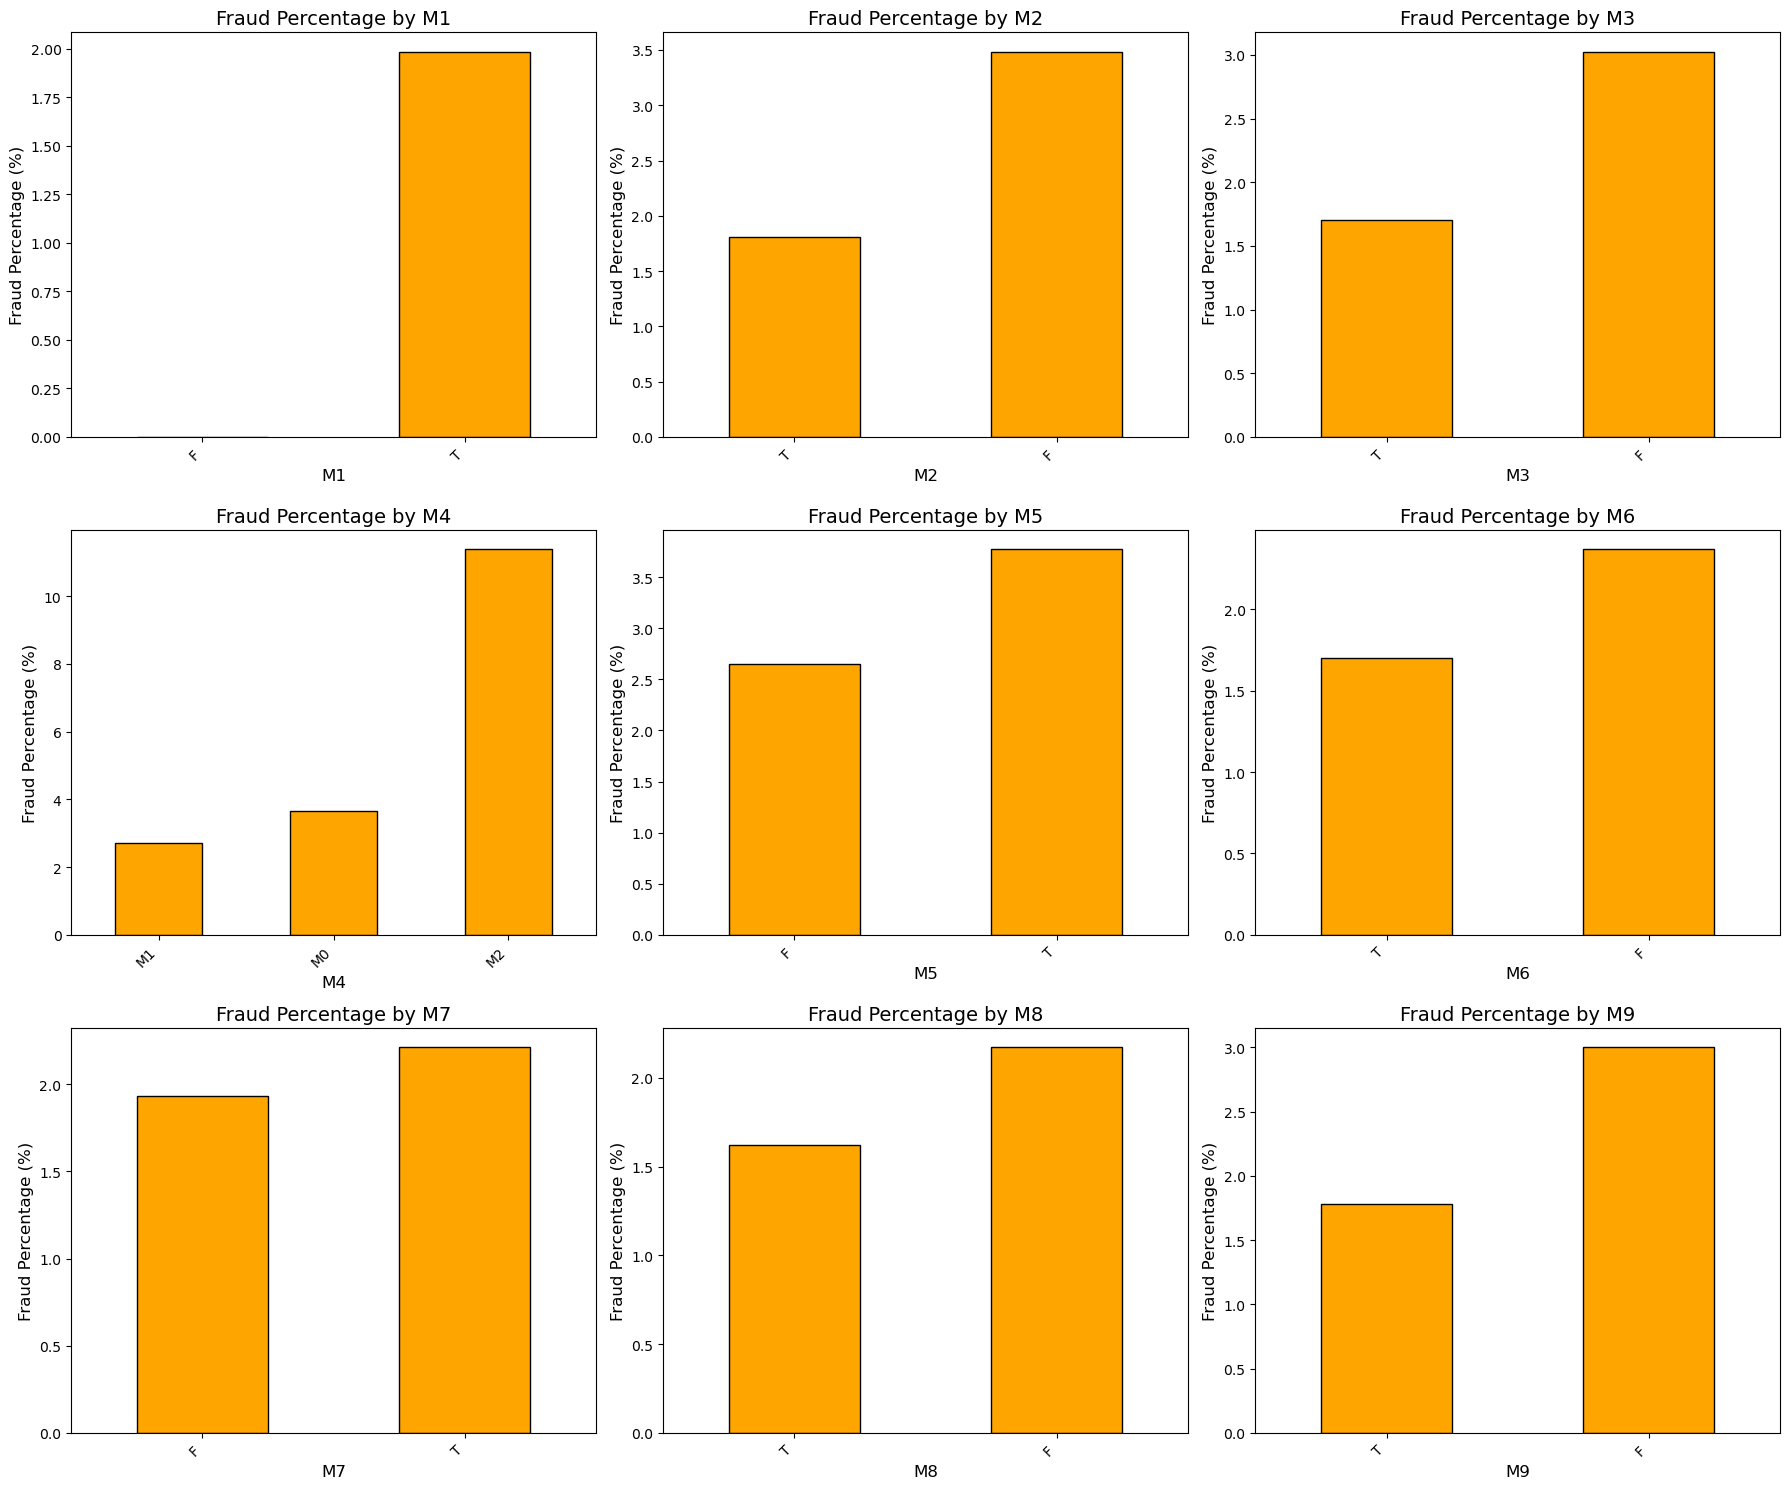

In [109]:
import matplotlib.pyplot as plt

# Function to calculate and plot the fraud percentage by category in a column
def plot_fraud_percentage_by_category(data, column, ax):
    # Calculate the fraud rate (percentage) for each category in the column
    fraud_percentage = data.groupby(column)['isFraud'].mean() * 100
    
    # Plot the fraud percentage for each category in the column
    fraud_percentage.sort_values().plot(kind='bar', color='orange', edgecolor='black', ax=ax)
    
    # Configure the plot
    ax.set_title(f'Fraud Percentage by {column}', fontsize=14)
    ax.set_xlabel(column, fontsize=12)
    ax.set_ylabel('Fraud Percentage (%)', fontsize=12)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# Create multiple subplots side by side
fig, axes = plt.subplots(3, 3, figsize=(18, 15))  # 3 rows, 3 columns to accommodate 9 plots
fig.subplots_adjust(hspace=0.4, wspace=0.4)  # Adjust the spacing between the plots

# Iterate over each M column (1 to 9) and generate a plot
for col, ax in zip([f'M{i}' for i in range(1, 10)], axes.flatten()):
    plot_fraud_percentage_by_category(train_transaction, col, ax)

plt.tight_layout()
plt.show()

Perhaps m1 and m4 are relevant, but since the percentage of nulls is very high, let's set them aside for now.

###dist: distance (dist1 and dist2)

"distances between (not limited) billing address, mailing address, zip code, IP address, phone area, etc.”
This distance might indicate something; let's check it.



In [113]:
import pandas as pd

# Calculate max, min, and range for dist1 and dist2
dist1_max = train_transaction['dist1'].max()
dist1_min = train_transaction['dist1'].min()
dist1_range = dist1_max - dist1_min

dist2_max = train_transaction['dist2'].max()
dist2_min = train_transaction['dist2'].min()
dist2_range = dist2_max - dist2_min

# Display the results
print("dist1:")
print(f"  Max: {dist1_max}")
print(f"  Min: {dist1_min}")
print(f"  Range: {dist1_range}")

print("\ndist2:")
print(f"  Max: {dist2_max}")
print(f"  Min: {dist2_min}")
print(f"  Range: {dist2_range}")

dist1:
  Max: 10288.0
  Min: 0.0
  Range: 10288.0

dist2:
  Max: 11624.0
  Min: 0.0
  Range: 11624.0


In [114]:
import pandas as pd

# Create a dictionary to store results
results = {
    'column': [],
    'class_count': [],
    'null_count': [],
    'null_percentage': []
}

# List of columns to analyze
columns_of_interest = ['addr1', 'addr2']

# Loop through each column of interest
for col in columns_of_interest:
    # Count unique classes
    class_count = train_transaction[col].nunique()
    
    # Count null values
    null_count = train_transaction[col].isnull().sum()
    
    # Total entries in the column
    total_count = train_transaction[col].shape[0]  # Total number of entries

    # Calculate percentage of nulls
    null_percentage = (null_count / total_count) * 100 if total_count > 0 else 0  # Percentage of nulls

    # Store results
    results['column'].append(col)
    results['class_count'].append(class_count)
    results['null_count'].append(null_count)
    results['null_percentage'].append(null_percentage)

# Create a DataFrame from results
results_df = pd.DataFrame(results)

# Display the results DataFrame
print(results_df)

  column  class_count  null_count  null_percentage
0  addr1            6       65706        11.126427
1  addr2            6       65706        11.126427


I will divide this distance into intervals and examine how it relates to fraud.

<Figure size 1500x800 with 0 Axes>

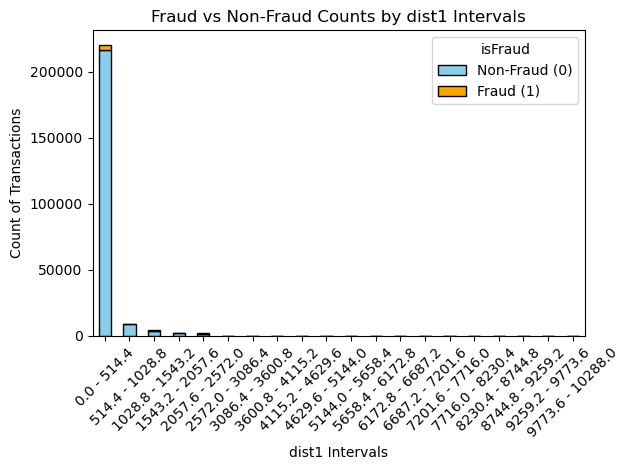

<Figure size 1500x800 with 0 Axes>

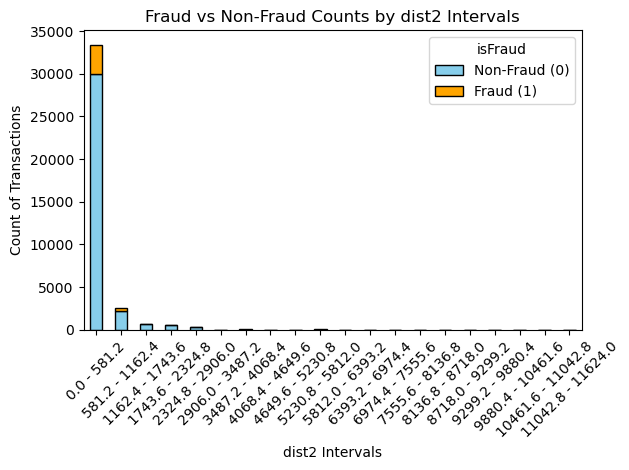

In [116]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Converting 'dist1' and 'dist2' to float32 to avoid the NotImplementedError
train_transaction['dist1'] = train_transaction['dist1'].astype(np.float32)
train_transaction['dist2'] = train_transaction['dist2'].astype(np.float32)

# Function to create intervals, calculate fraud/non-fraud counts, and plot
def plot_fraud_by_distance_interval(data, distance_column):
    # Define bins for 20 equal-width intervals
    bins = np.linspace(data[distance_column].min(), data[distance_column].max(), 21)
    
    # Create labels for the intervals
    labels = [f'{round(bins[i], 2)} - {round(bins[i + 1], 2)}' for i in range(len(bins) - 1)]
    
    # Bin the data based on the distance column
    data[f'{distance_column}_bin'] = pd.cut(data[distance_column], bins=bins, labels=labels, include_lowest=True)
    
    # Count fraud and non-fraud cases in each bin
    fraud_counts = data.groupby(f'{distance_column}_bin')['isFraud'].value_counts().unstack(fill_value=0)
    
    # Plot the stacked bar chart
    plt.figure(figsize=(15, 8))
    fraud_counts.plot(kind='bar', stacked=True, color=['skyblue', 'orange'], edgecolor='black')
    plt.title(f'Fraud vs Non-Fraud Counts by {distance_column} Intervals')
    plt.xlabel(f'{distance_column} Intervals')
    plt.ylabel('Count of Transactions')
    plt.legend(title='isFraud', labels=['Non-Fraud (0)', 'Fraud (1)'])
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Apply the function for both dist1 and dist2
plot_fraud_by_distance_interval(train_transaction, 'dist1')
plot_fraud_by_distance_interval(train_transaction, 'dist2') 

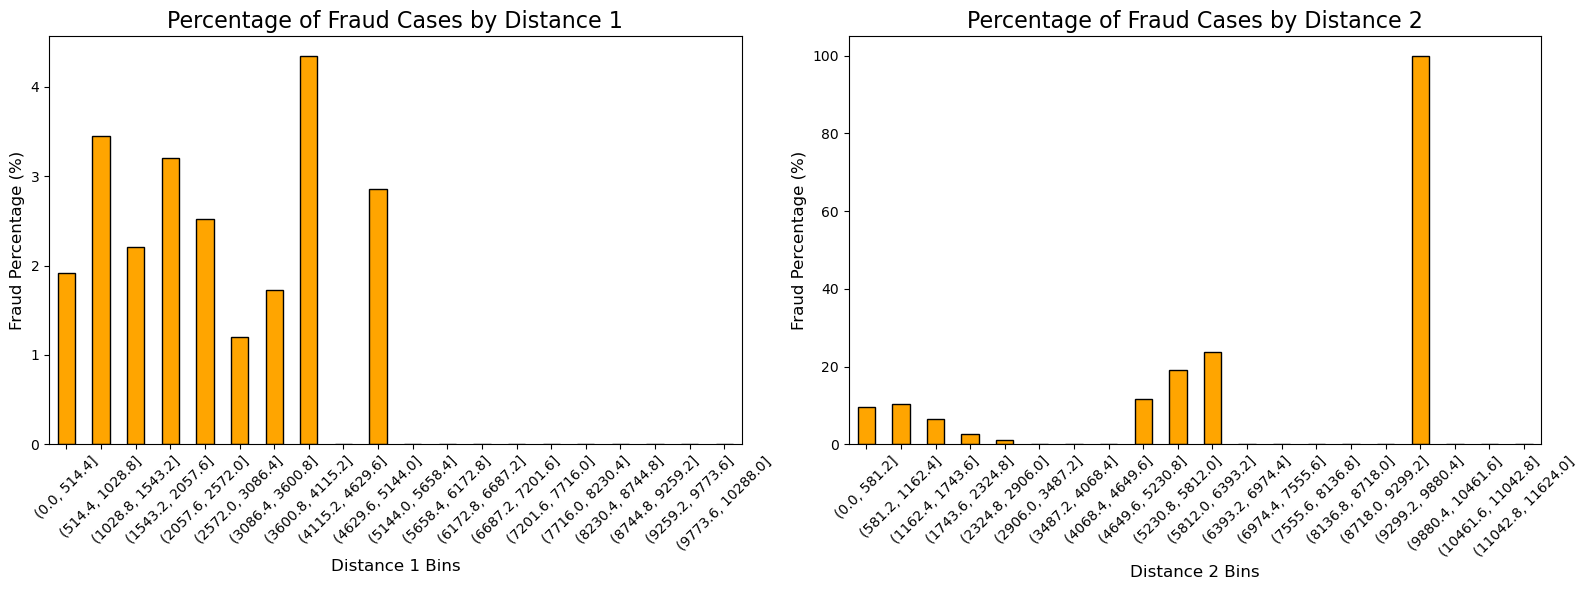

In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define the number of intervals
n_intervals = 20

# Create bins for dist1 and dist2
dist1_bins = np.linspace(train_transaction['dist1'].min(), train_transaction['dist1'].max(), n_intervals + 1)
dist2_bins = np.linspace(train_transaction['dist2'].min(), train_transaction['dist2'].max(), n_intervals + 1)

# Create new columns to categorize distances into bins
train_transaction['dist1_bins'] = pd.cut(train_transaction['dist1'], bins=dist1_bins)
train_transaction['dist2_bins'] = pd.cut(train_transaction['dist2'], bins=dist2_bins)

# Count total transactions and fraud cases in each bin for dist1
total_counts_dist1 = train_transaction.groupby('dist1_bins').size()
fraud_counts_dist1 = train_transaction[train_transaction['isFraud'] == 1].groupby('dist1_bins').size()

# Calculate the percentage of fraud cases
fraud_percentage_dist1 = (fraud_counts_dist1 / total_counts_dist1) * 100

# Count total transactions and fraud cases in each bin for dist2
total_counts_dist2 = train_transaction.groupby('dist2_bins').size()
fraud_counts_dist2 = train_transaction[train_transaction['isFraud'] == 1].groupby('dist2_bins').size()

# Calculate the percentage of fraud cases
fraud_percentage_dist2 = (fraud_counts_dist2 / total_counts_dist2) * 100

# Create the plots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # Two subplots side by side

# Plot for dist1
fraud_percentage_dist1.sort_index().plot(kind='bar', ax=axes[0], color='orange', edgecolor='black')
axes[0].set_title('Percentage of Fraud Cases by Distance 1', fontsize=16)
axes[0].set_xlabel('Distance 1 Bins', fontsize=12)
axes[0].set_ylabel('Fraud Percentage (%)', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)

# Plot for dist2
fraud_percentage_dist2.sort_index().plot(kind='bar', ax=axes[1], color='orange', edgecolor='black')
axes[1].set_title('Percentage of Fraud Cases by Distance 2', fontsize=16)
axes[1].set_xlabel('Distance 2 Bins', fontsize=12)
axes[1].set_ylabel('Fraud Percentage (%)', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()  # Adjust layout
plt.show()

It seems we are encountering more outliers. Let's focus on how to address them.

In [119]:
train_transaction = treat_outliers(train_transaction,"dist1")
train_transaction = treat_outliers(train_transaction,"dist2")

<Figure size 1500x800 with 0 Axes>

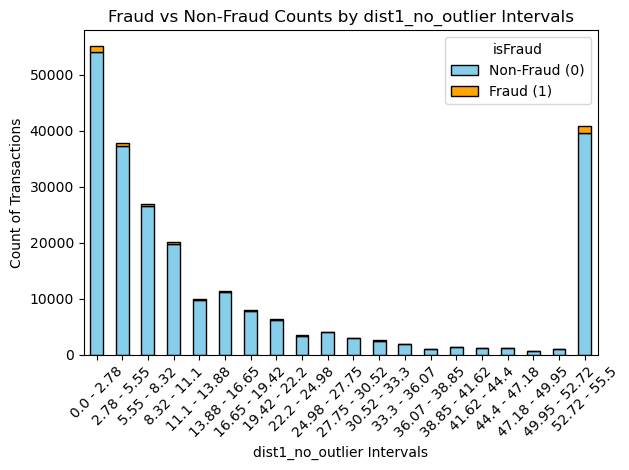

<Figure size 1500x800 with 0 Axes>

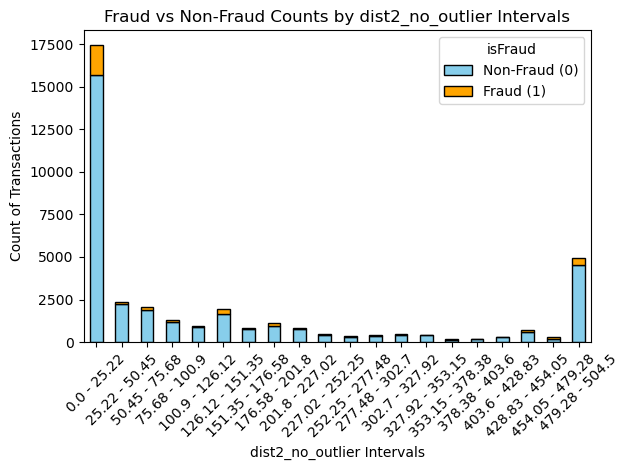

In [120]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Converting 'dist1_no_outlier' and 'dist2_no_outlier' to float32 to avoid the NotImplementedError
train_transaction['dist1_no_outlier'] = train_transaction['dist1_no_outlier'].astype(np.float32)
train_transaction['dist2_no_outlier'] = train_transaction['dist2_no_outlier'].astype(np.float32)

# Function to create intervals, calculate fraud/non-fraud counts, and plot
def plot_fraud_by_distance_interval(data, distance_column):
    # Define bins for 20 equal-width intervals
    bins = np.linspace(data[distance_column].min(), data[distance_column].max(), 21)
    
    # Create labels for the intervals
    labels = [f'{round(bins[i], 2)} - {round(bins[i + 1], 2)}' for i in range(len(bins) - 1)]
    
    # Bin the data based on the distance column
    data[f'{distance_column}_bin'] = pd.cut(data[distance_column], bins=bins, labels=labels, include_lowest=True)
    
    # Count fraud and non-fraud cases in each bin
    fraud_counts = data.groupby(f'{distance_column}_bin')['isFraud'].value_counts().unstack(fill_value=0)
    
    # Plot the stacked bar chart
    plt.figure(figsize=(15, 8))
    fraud_counts.plot(kind='bar', stacked=True, color=['skyblue', 'orange'], edgecolor='black')
    plt.title(f'Fraud vs Non-Fraud Counts by {distance_column} Intervals')
    plt.xlabel(f'{distance_column} Intervals')
    plt.ylabel('Count of Transactions')
    plt.legend(title='isFraud', labels=['Non-Fraud (0)', 'Fraud (1)'])
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Apply the function for both dist1 and dist2
plot_fraud_by_distance_interval(train_transaction, 'dist1_no_outlier')
plot_fraud_by_distance_interval(train_transaction, 'dist2_no_outlier')

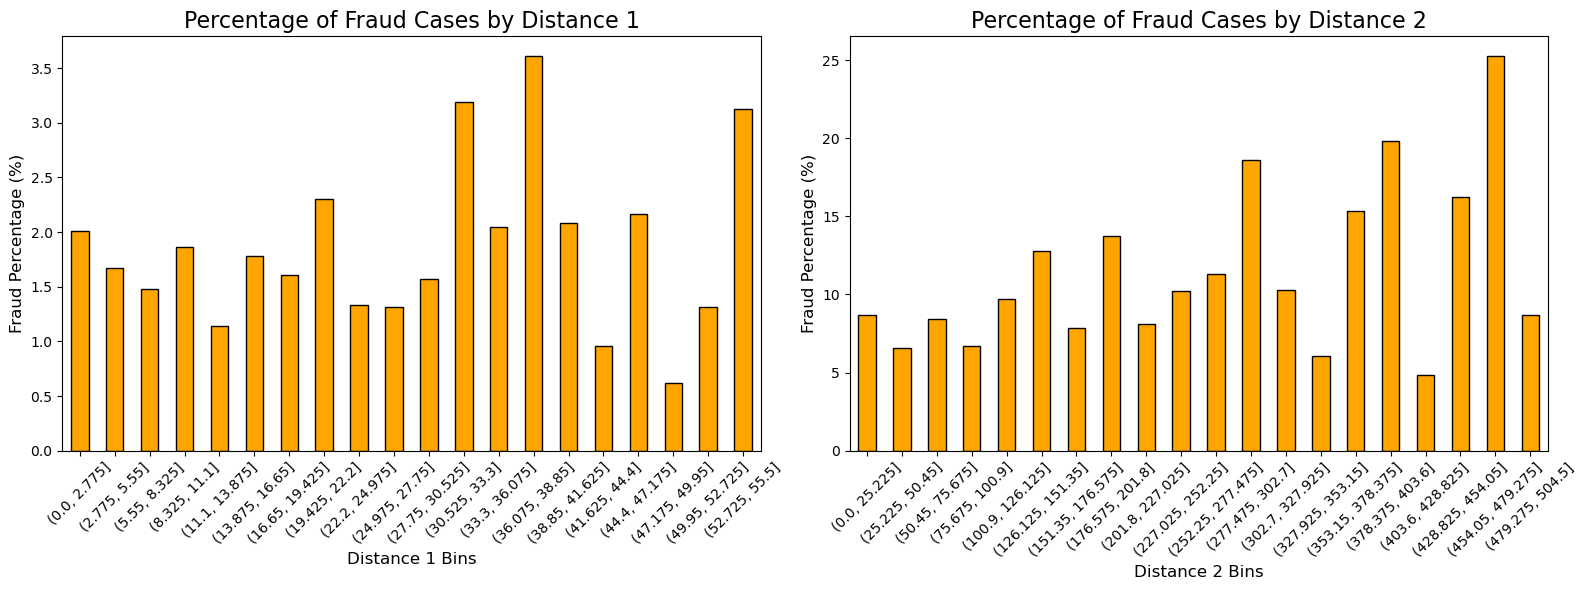

In [121]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define the number of intervals
n_intervals = 20

# Create bins for dist1 and dist2
dist1_bins = np.linspace(train_transaction['dist1_no_outlier'].min(), train_transaction['dist1_no_outlier'].max(), n_intervals + 1)
dist2_bins = np.linspace(train_transaction['dist2_no_outlier'].min(), train_transaction['dist2_no_outlier'].max(), n_intervals + 1)

# Create new columns to categorize distances into bins
train_transaction['dist1_no_outlier_bins'] = pd.cut(train_transaction['dist1_no_outlier'], bins=dist1_bins)
train_transaction['dist2_no_outlier_bins'] = pd.cut(train_transaction['dist2_no_outlier'], bins=dist2_bins)

# Count total transactions and fraud cases in each bin for dist1
total_counts_dist1 = train_transaction.groupby('dist1_no_outlier_bins').size()
fraud_counts_dist1 = train_transaction[train_transaction['isFraud'] == 1].groupby('dist1_no_outlier_bins').size()

# Calculate the percentage of fraud cases
fraud_percentage_dist1 = (fraud_counts_dist1 / total_counts_dist1) * 100

# Count total transactions and fraud cases in each bin for dist2
total_counts_dist2 = train_transaction.groupby('dist2_no_outlier_bins').size()
fraud_counts_dist2 = train_transaction[train_transaction['isFraud'] == 1].groupby('dist2_no_outlier_bins').size()

# Calculate the percentage of fraud cases
fraud_percentage_dist2 = (fraud_counts_dist2 / total_counts_dist2) * 100

# Create the plots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # Two subplots side by side

# Plot for dist1
fraud_percentage_dist1.sort_index().plot(kind='bar', ax=axes[0], color='orange', edgecolor='black')
axes[0].set_title('Percentage of Fraud Cases by Distance 1', fontsize=16)
axes[0].set_xlabel('Distance 1 Bins', fontsize=12)
axes[0].set_ylabel('Fraud Percentage (%)', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)

# Plot for dist2
fraud_percentage_dist2.sort_index().plot(kind='bar', ax=axes[1], color='orange', edgecolor='black')
axes[1].set_title('Percentage of Fraud Cases by Distance 2', fontsize=16)
axes[1].set_xlabel('Distance 2 Bins', fontsize=12)
axes[1].set_ylabel('Fraud Percentage (%)', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()  # Adjust layout
plt.show()

Without the outliers, the data becomes more intriguing, revealing characteristics that are valuable for analysis.

In [123]:
print("dist1: "+str(train_transaction['dist1'].corr(train_transaction['isFraud'])) + " - dist2: "+str(train_transaction['dist2'].corr(train_transaction['isFraud'])))
print("dist1_no_outlier: "+str(train_transaction['dist1_no_outlier'].corr(train_transaction['isFraud'])) + " - dist2_no_outlier: "+str(train_transaction['dist2_no_outlier'].corr(train_transaction['isFraud'])))

dist1: 0.021523371426953153 - dist2: -0.01905412129112066
dist1_no_outlier: 0.032277774277675676 - dist2_no_outlier: 0.011352517249074994


In [124]:
new_df['dist1_no_outlier'] = train_transaction['dist1_no_outlier']
new_df['dist2_no_outlier'] = train_transaction['dist2_no_outlier']

###C1-C14

C1-C14: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.
“Can you please give more examples of counts in the variables C1-15? Would these be like counts of phone numbers, email addresses, names associated with the user? I can't think of 15. Your guess is good, plus like device, ipaddr, billingaddr, etc. Also these are for both purchaser and recipient, which doubles the number".
It is not very clear what this refers to. Let’s explore further.

”

In [127]:
import pandas as pd

# Create a dictionary to store results
results = {
    'column': [],
    'class_count': [],
    'null_count': [],
    'null_percentage': []
}

# Loop through each column from C1 to C14
for i in range(1, 15):  # C1 to C14
    col = f'C{i}'
    
    # Count unique classes
    class_count = train_transaction[col].nunique()
    
    # Count null values
    null_count = train_transaction[col].isnull().sum()
    
    # Total entries in the column
    total_count = train_transaction[col].shape[0]  # Total number of entries

    # Calculate percentage of nulls
    null_percentage = (null_count / total_count) * 100 if total_count > 0 else 0  # Percentage of nulls

    # Store results
    results['column'].append(col)
    results['class_count'].append(class_count)
    results['null_count'].append(null_count)
    results['null_percentage'].append(null_percentage)

# Create a DataFrame from results
results_df = pd.DataFrame(results)

# Display the results DataFrame
print(results_df)


   column  class_count  null_count  null_percentage
0      C1         1495           0              0.0
1      C2         1167           0              0.0
2      C3           27           0              0.0
3      C4         1223           0              0.0
4      C5          319           0              0.0
5      C6         1291           0              0.0
6      C7         1069           0              0.0
7      C8         1130           0              0.0
8      C9          205           0              0.0
9     C10         1122           0              0.0
10    C11         1343           0              0.0
11    C12         1066           0              0.0
12    C13         1464           0              0.0
13    C14         1108           0              0.0


In [128]:
import pandas as pd

# List of columns to analyze from C1 to C14
columns_of_interest = [f'C{i}' for i in range(1, 15)]  # Generates ['C1', 'C2', ..., 'C14']

# Create a dictionary to store the results
results = {
    'column': [],
    'max': [],
    'min': [],
    'range': []
}

# Loop through each column of interest
for col in columns_of_interest:
    col_max = train_transaction[col].max()
    col_min = train_transaction[col].min()
    col_range = col_max - col_min

    # Store results
    results['column'].append(col)
    results['max'].append(col_max)
    results['min'].append(col_min)
    results['range'].append(col_range)

# Create a DataFrame from results
results_df = pd.DataFrame(results)

# Display the results DataFrame
print(results_df)


   column     max  min   range
0      C1  4684.0  0.0  4684.0
1      C2  5692.0  0.0  5692.0
2      C3    26.0  0.0    26.0
3      C4  2252.0  0.0  2252.0
4      C5   349.0  0.0   349.0
5      C6  2252.0  0.0  2252.0
6      C7  2256.0  0.0  2256.0
7      C8  3332.0  0.0  3332.0
8      C9   210.0  0.0   210.0
9     C10  3256.0  0.0  3256.0
10    C11  3188.0  0.0  3188.0
11    C12  3188.0  0.0  3188.0
12    C13  2918.0  0.0  2918.0
13    C14  1429.0  0.0  1429.0


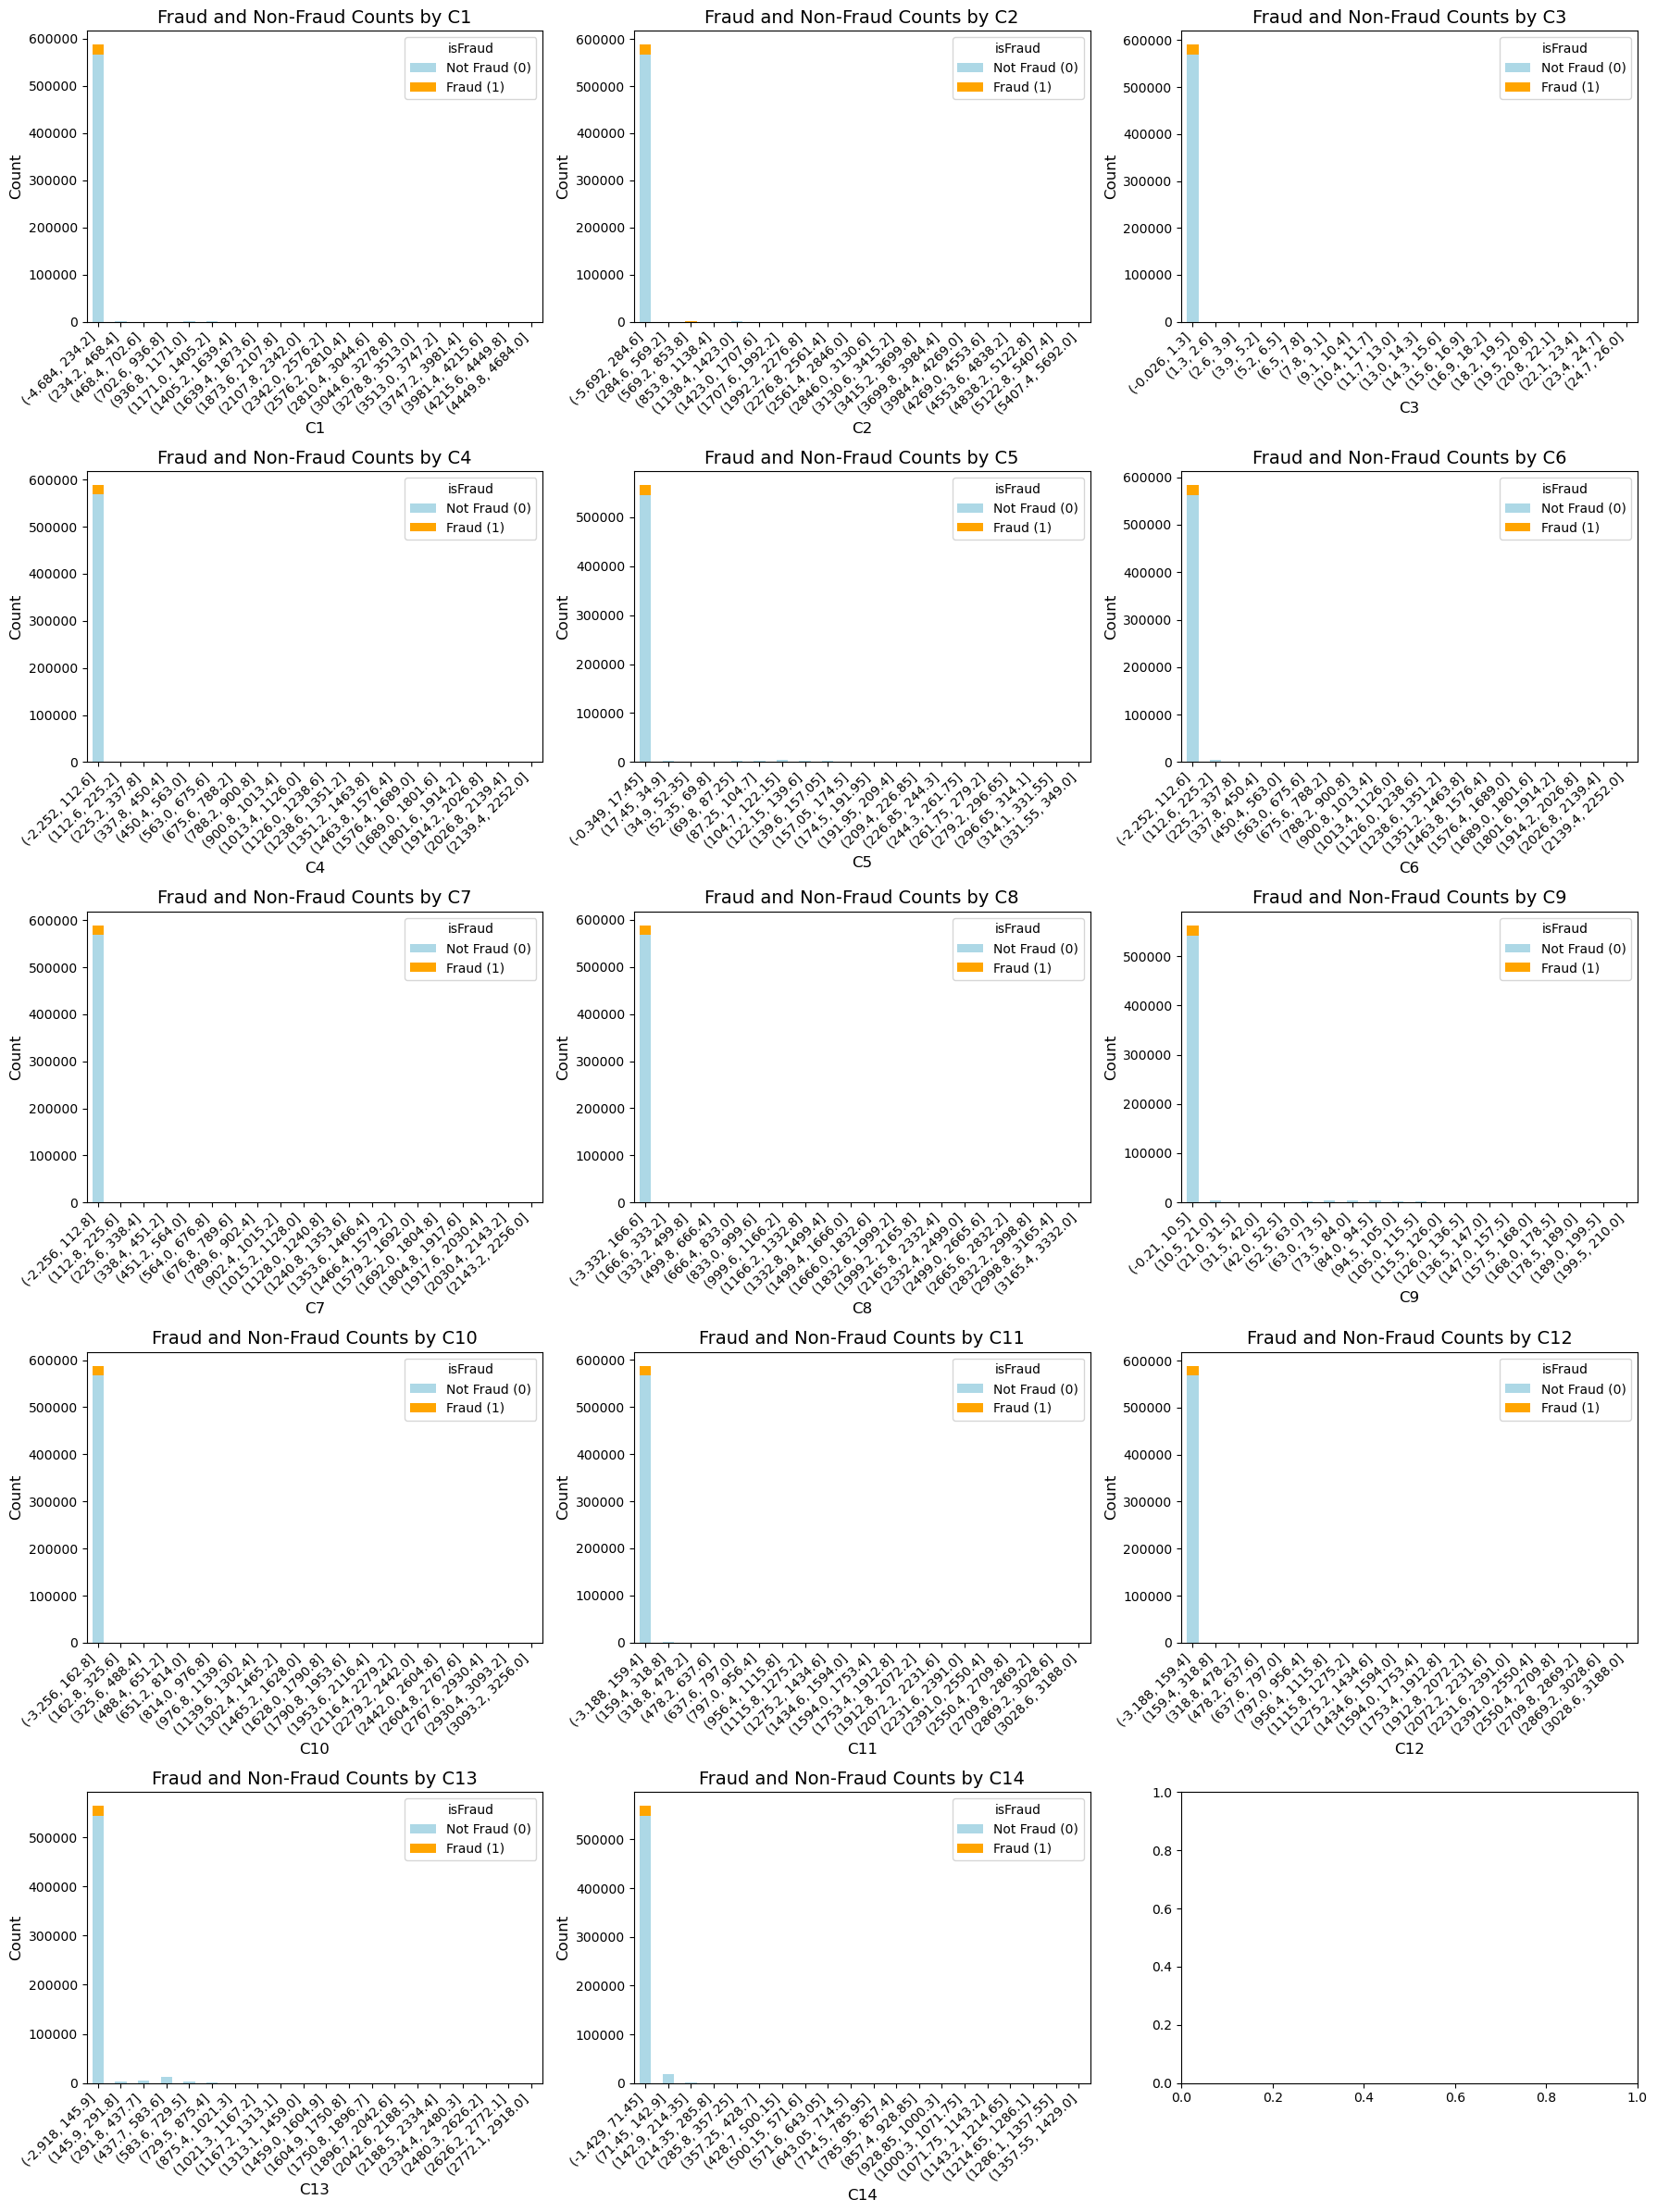

In [129]:
import pandas as pd
import matplotlib.pyplot as plt

# List of columns to analyze
columns_of_interest = [f'C{i}' for i in range(1, 15)]

# Create a figure for subplots
fig, axes = plt.subplots(5, 3, figsize=(18, 24))  # 5 rows and 3 columns
axes = axes.flatten()  # Flatten to easily index the axes

# Iterate through each column and create a plot
for ax, col in zip(axes, columns_of_interest):
    # Convert to float32 to avoid the float16 error
    train_transaction[col] = train_transaction[col].astype('float32')

    # Create bins for the column
    bins = pd.cut(train_transaction[col], bins=20)  # 20 intervals

    # Count fraud and non-fraud cases in each bin
    counts = train_transaction.groupby(bins)['isFraud'].value_counts().unstack(fill_value=0)

    # Create a bar plot with counts
    counts.plot(kind='bar', stacked=True, ax=ax, color=['lightblue', 'orange'])

    # Set plot titles and labels
    ax.set_title(f'Fraud and Non-Fraud Counts by {col}', fontsize=14)
    ax.set_xlabel(col, fontsize=12)
    ax.set_ylabel('Count', fontsize=12)
    ax.legend(title='isFraud', labels=['Not Fraud (0)', 'Fraud (1)'])
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

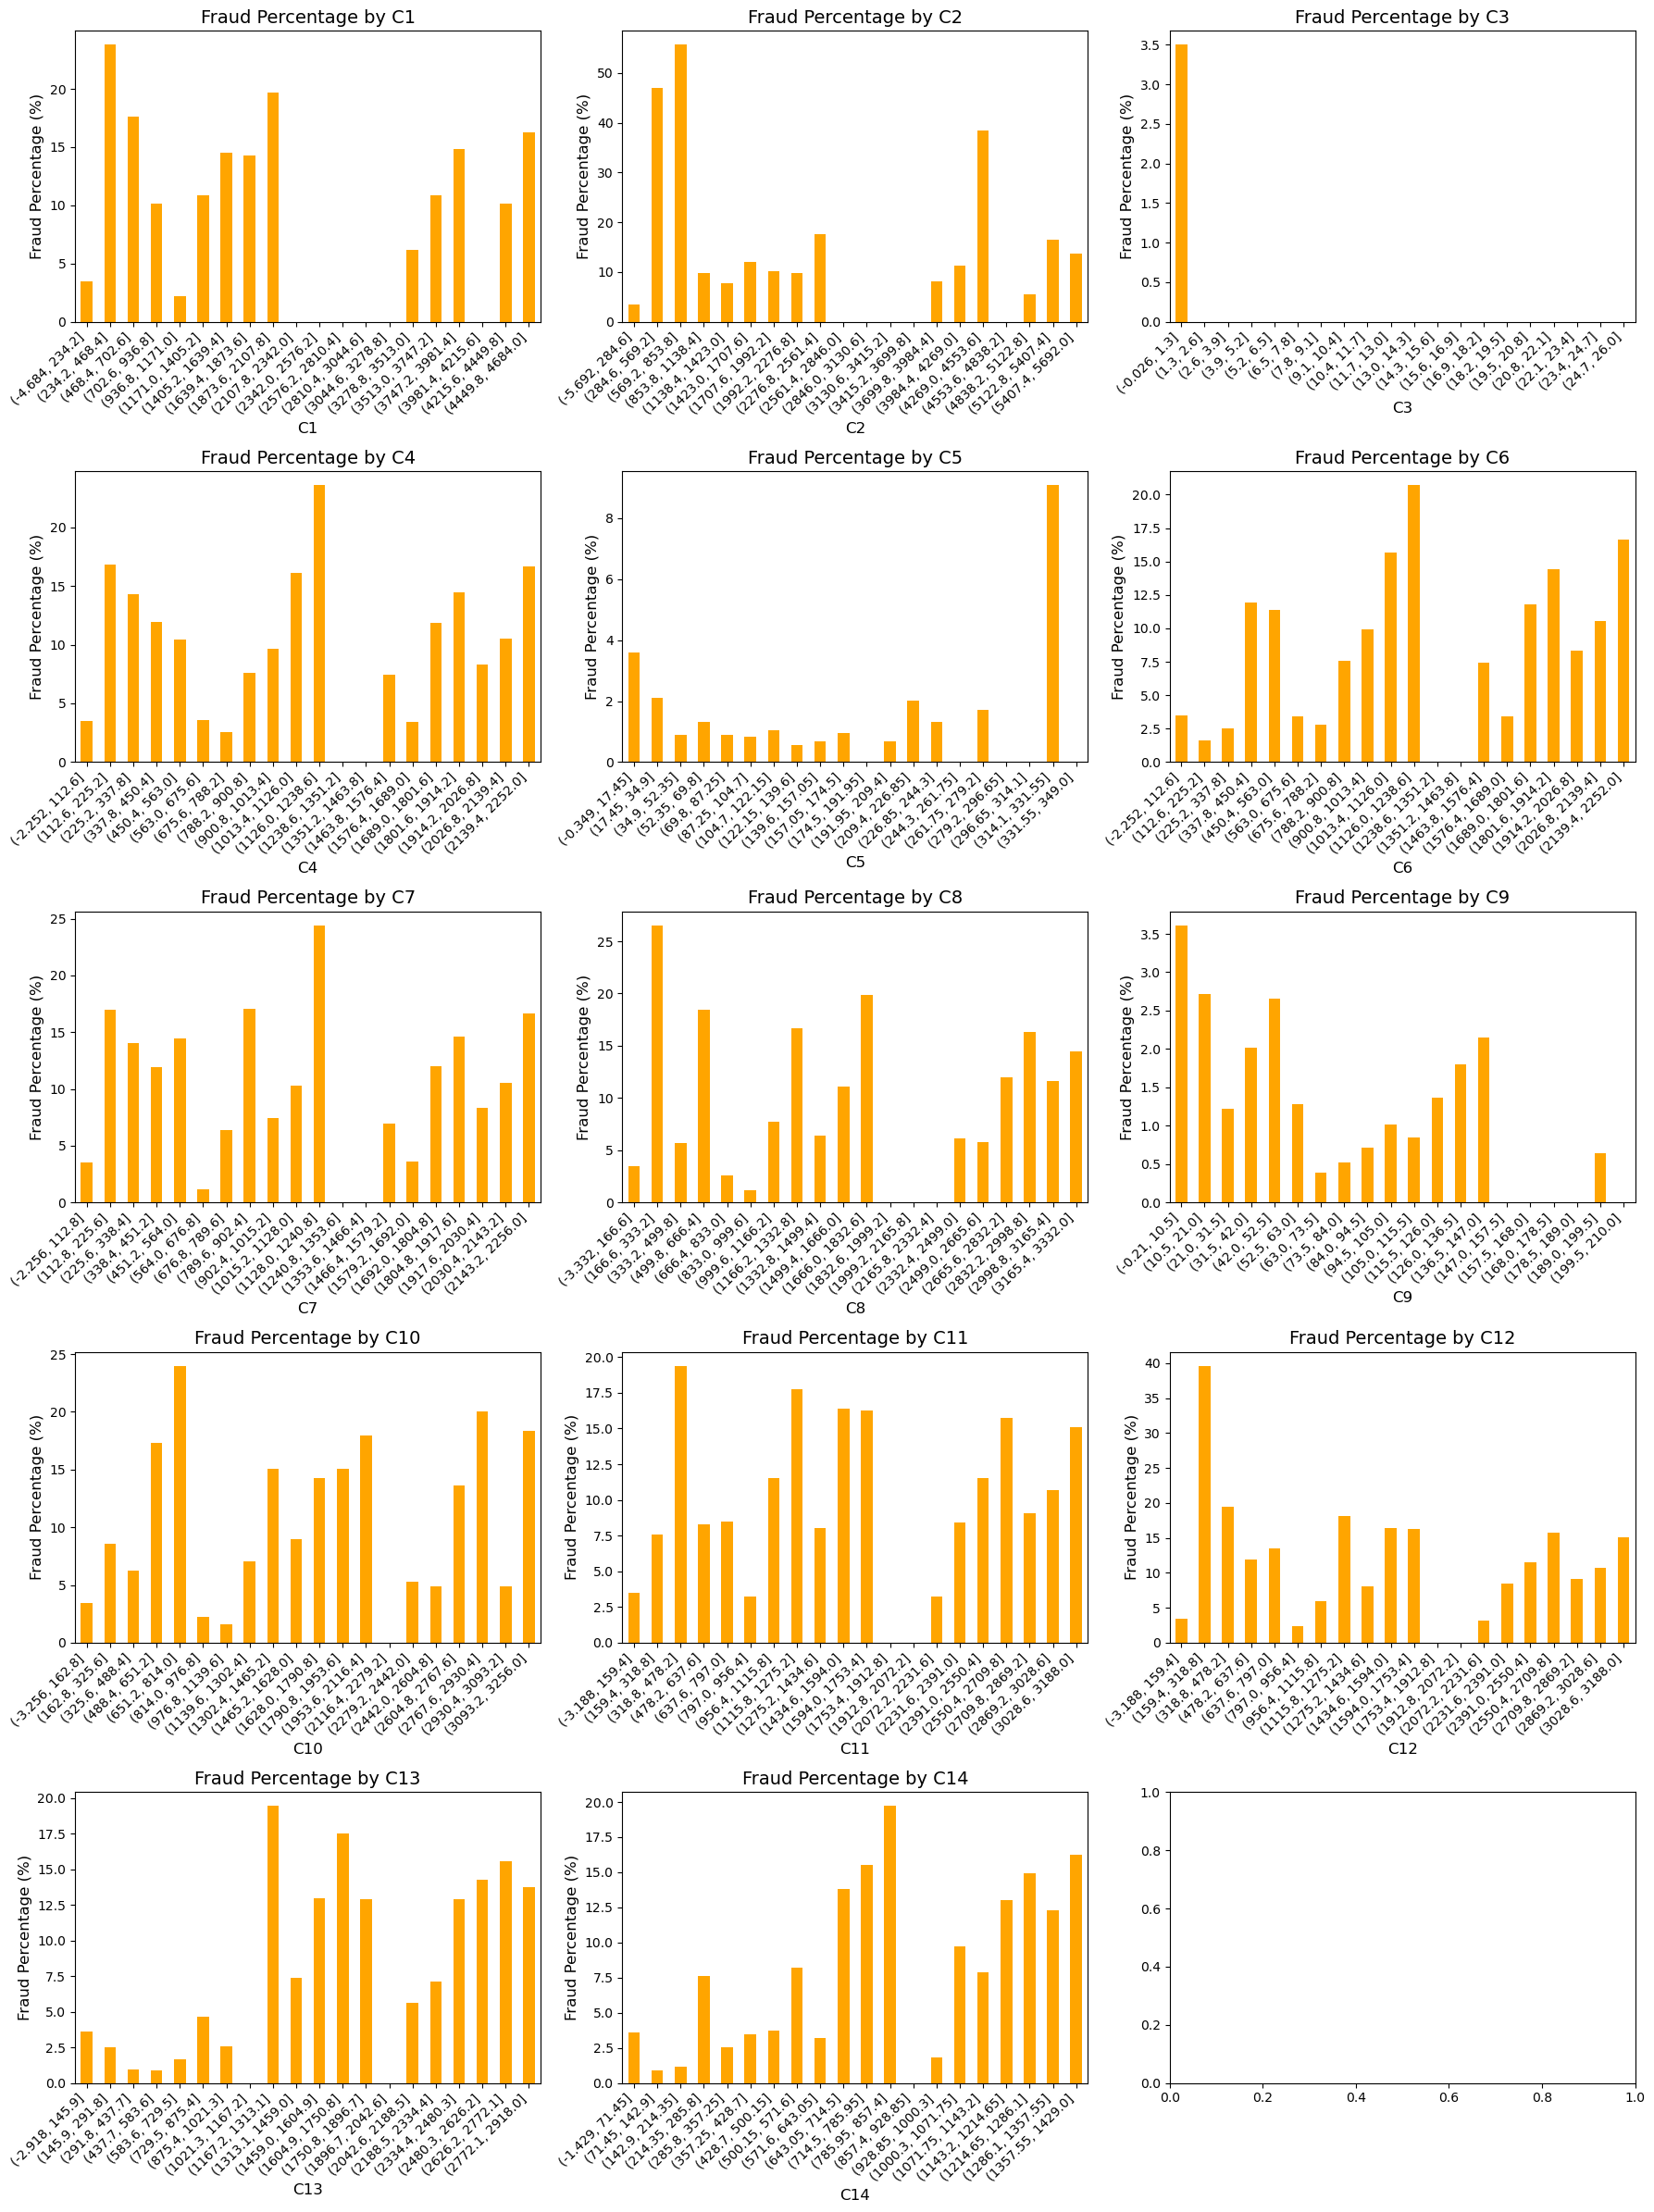

In [130]:
import pandas as pd
import matplotlib.pyplot as plt

# List of columns to analyze
columns_of_interest = [f'C{i}' for i in range(1, 15)]

# Create a figure for subplots
fig, axes = plt.subplots(5, 3, figsize=(18, 24))  # 5 rows and 3 columns
axes = axes.flatten()  # Flatten to easily index the axes

# Iterate through each column and create a plot
for ax, col in zip(axes, columns_of_interest):
    # Convert to float32 to avoid the float16 error
    train_transaction[col] = train_transaction[col].astype('float32')

    # Create bins for the column
    bins = pd.cut(train_transaction[col], bins=20)  # 20 intervals

    # Count fraud cases in each bin
    fraud_counts = train_transaction[train_transaction['isFraud'] == 1].groupby(bins)['isFraud'].count()

    # Total counts in each bin (to calculate percentages)
    total_counts = train_transaction.groupby(bins)['isFraud'].count()

    # Calculate the percentage of frauds for each bin
    fraud_percentages = (fraud_counts / total_counts) * 100
    fraud_percentages = fraud_percentages.fillna(0)  # Replace NaN with 0 for bins with no counts

    # Plotting
    fraud_percentages.plot(kind='bar', color='orange', ax=ax)

    # Set plot titles and labels
    ax.set_title(f'Fraud Percentage by {col}', fontsize=14)
    ax.set_xlabel(col, fontsize=12)
    ax.set_ylabel('Fraud Percentage (%)', fontsize=12)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

In [131]:
import pandas as pd

# Calculate the correlation of C1 to C14 with the isFraud column
correlation_results = train_transaction[[f'C{i}' for i in range(1, 15)] + ['isFraud']].corr()['isFraud']

# Filter the results to show only the correlation of C1 to C14 with isFraud
correlation_results = correlation_results[:-1]  # Exclude 'isFraud' correlation with itself

# Display the correlation results
print(correlation_results)

C1     0.030570
C2     0.037229
C3    -0.006833
C4     0.030382
C5    -0.030754
C6     0.020909
C7     0.028161
C8     0.032138
C9    -0.031703
C10    0.028396
C11    0.027484
C12    0.031905
C13   -0.011146
C14    0.007921
Name: isFraud, dtype: float64


It seems that there are more outliers in this data. Let's address them as well.

In [133]:
columns_to_treat = [f'C{i}' for i in range(1, 15)]  # ['C1', 'C2', ..., 'C14']

for column in columns_to_treat:
    train_transaction = treat_outliers(train_transaction, column)

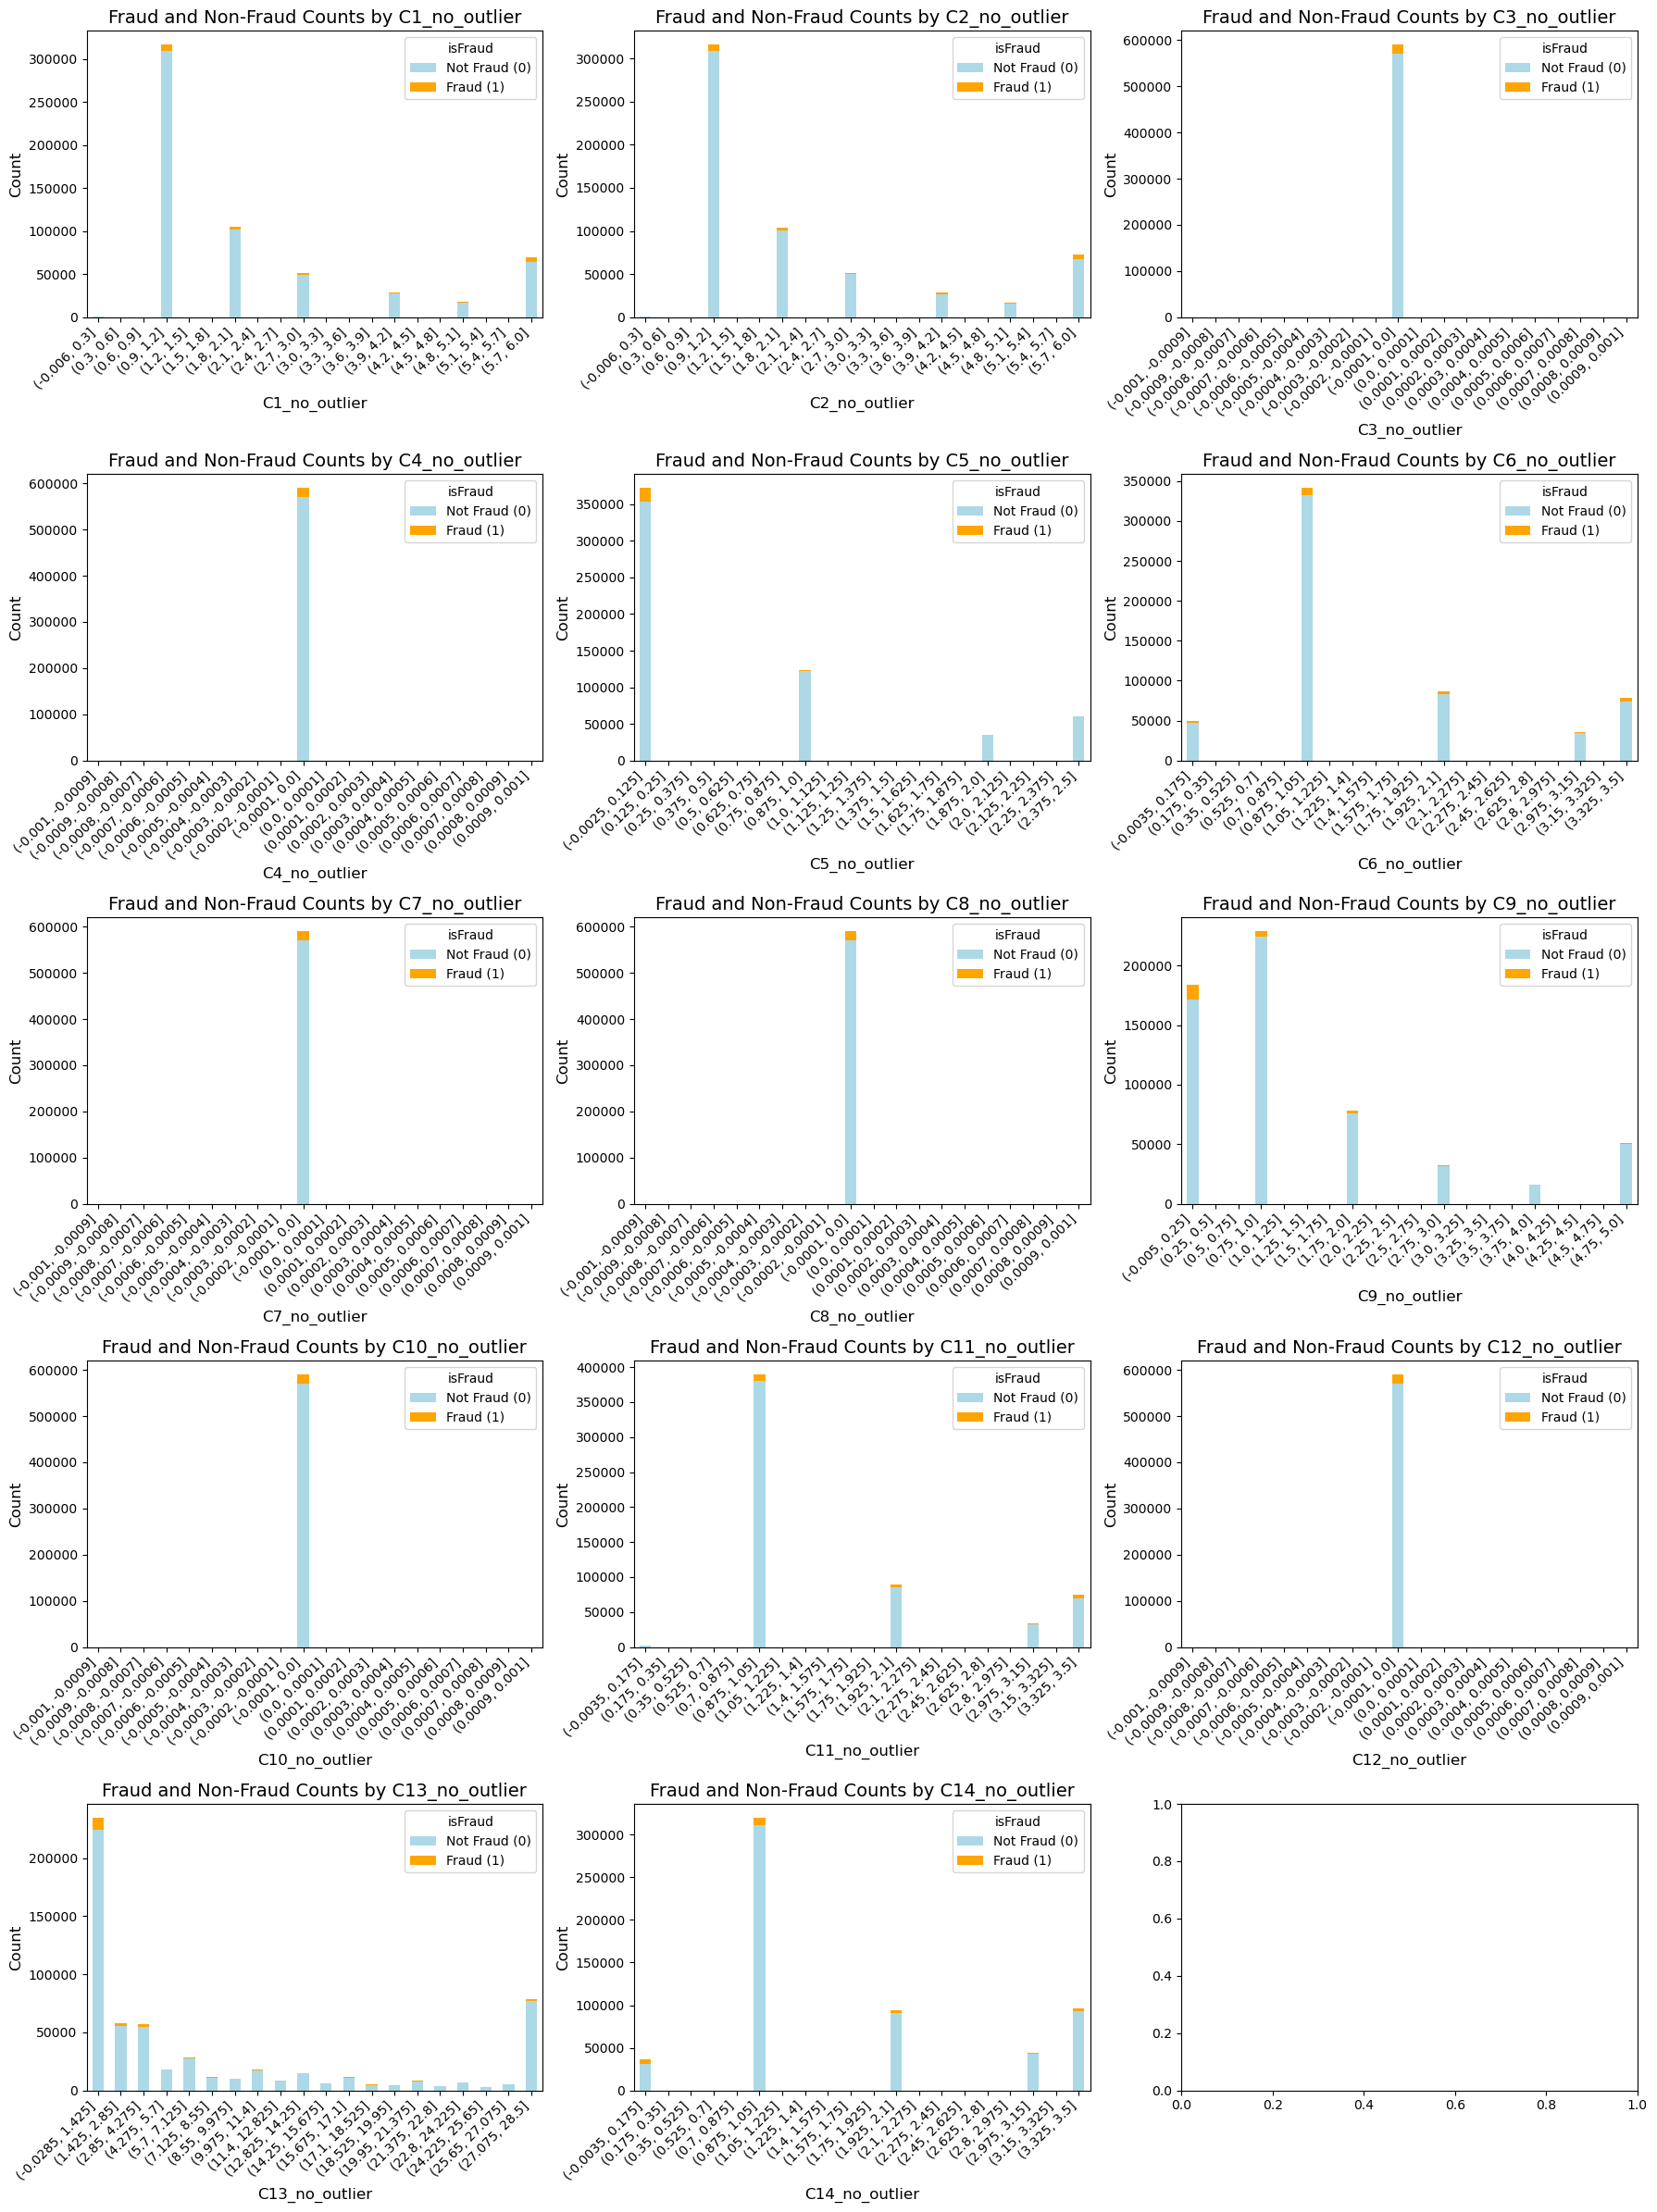

In [134]:
import pandas as pd
import matplotlib.pyplot as plt

# List of columns to analyze
columns_of_interest = [f'C{i}_no_outlier' for i in range(1, 15)]

# Create a figure for subplots
fig, axes = plt.subplots(5, 3, figsize=(18, 24))  # 5 rows and 3 columns
axes = axes.flatten()  # Flatten to easily index the axes

# Iterate through each column and create a plot
for ax, col in zip(axes, columns_of_interest):
    # Convert to float32 to avoid the float16 error
    train_transaction[col] = train_transaction[col].astype('float32')

    # Create bins for the column
    bins = pd.cut(train_transaction[col], bins=20)  # 20 intervals

    # Count fraud and non-fraud cases in each bin
    counts = train_transaction.groupby(bins)['isFraud'].value_counts().unstack(fill_value=0)

    # Create a bar plot with counts
    counts.plot(kind='bar', stacked=True, ax=ax, color=['lightblue', 'orange'])

    # Set plot titles and labels
    ax.set_title(f'Fraud and Non-Fraud Counts by {col}', fontsize=14)
    ax.set_xlabel(col, fontsize=12)
    ax.set_ylabel('Count', fontsize=12)
    ax.legend(title='isFraud', labels=['Not Fraud (0)', 'Fraud (1)'])
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

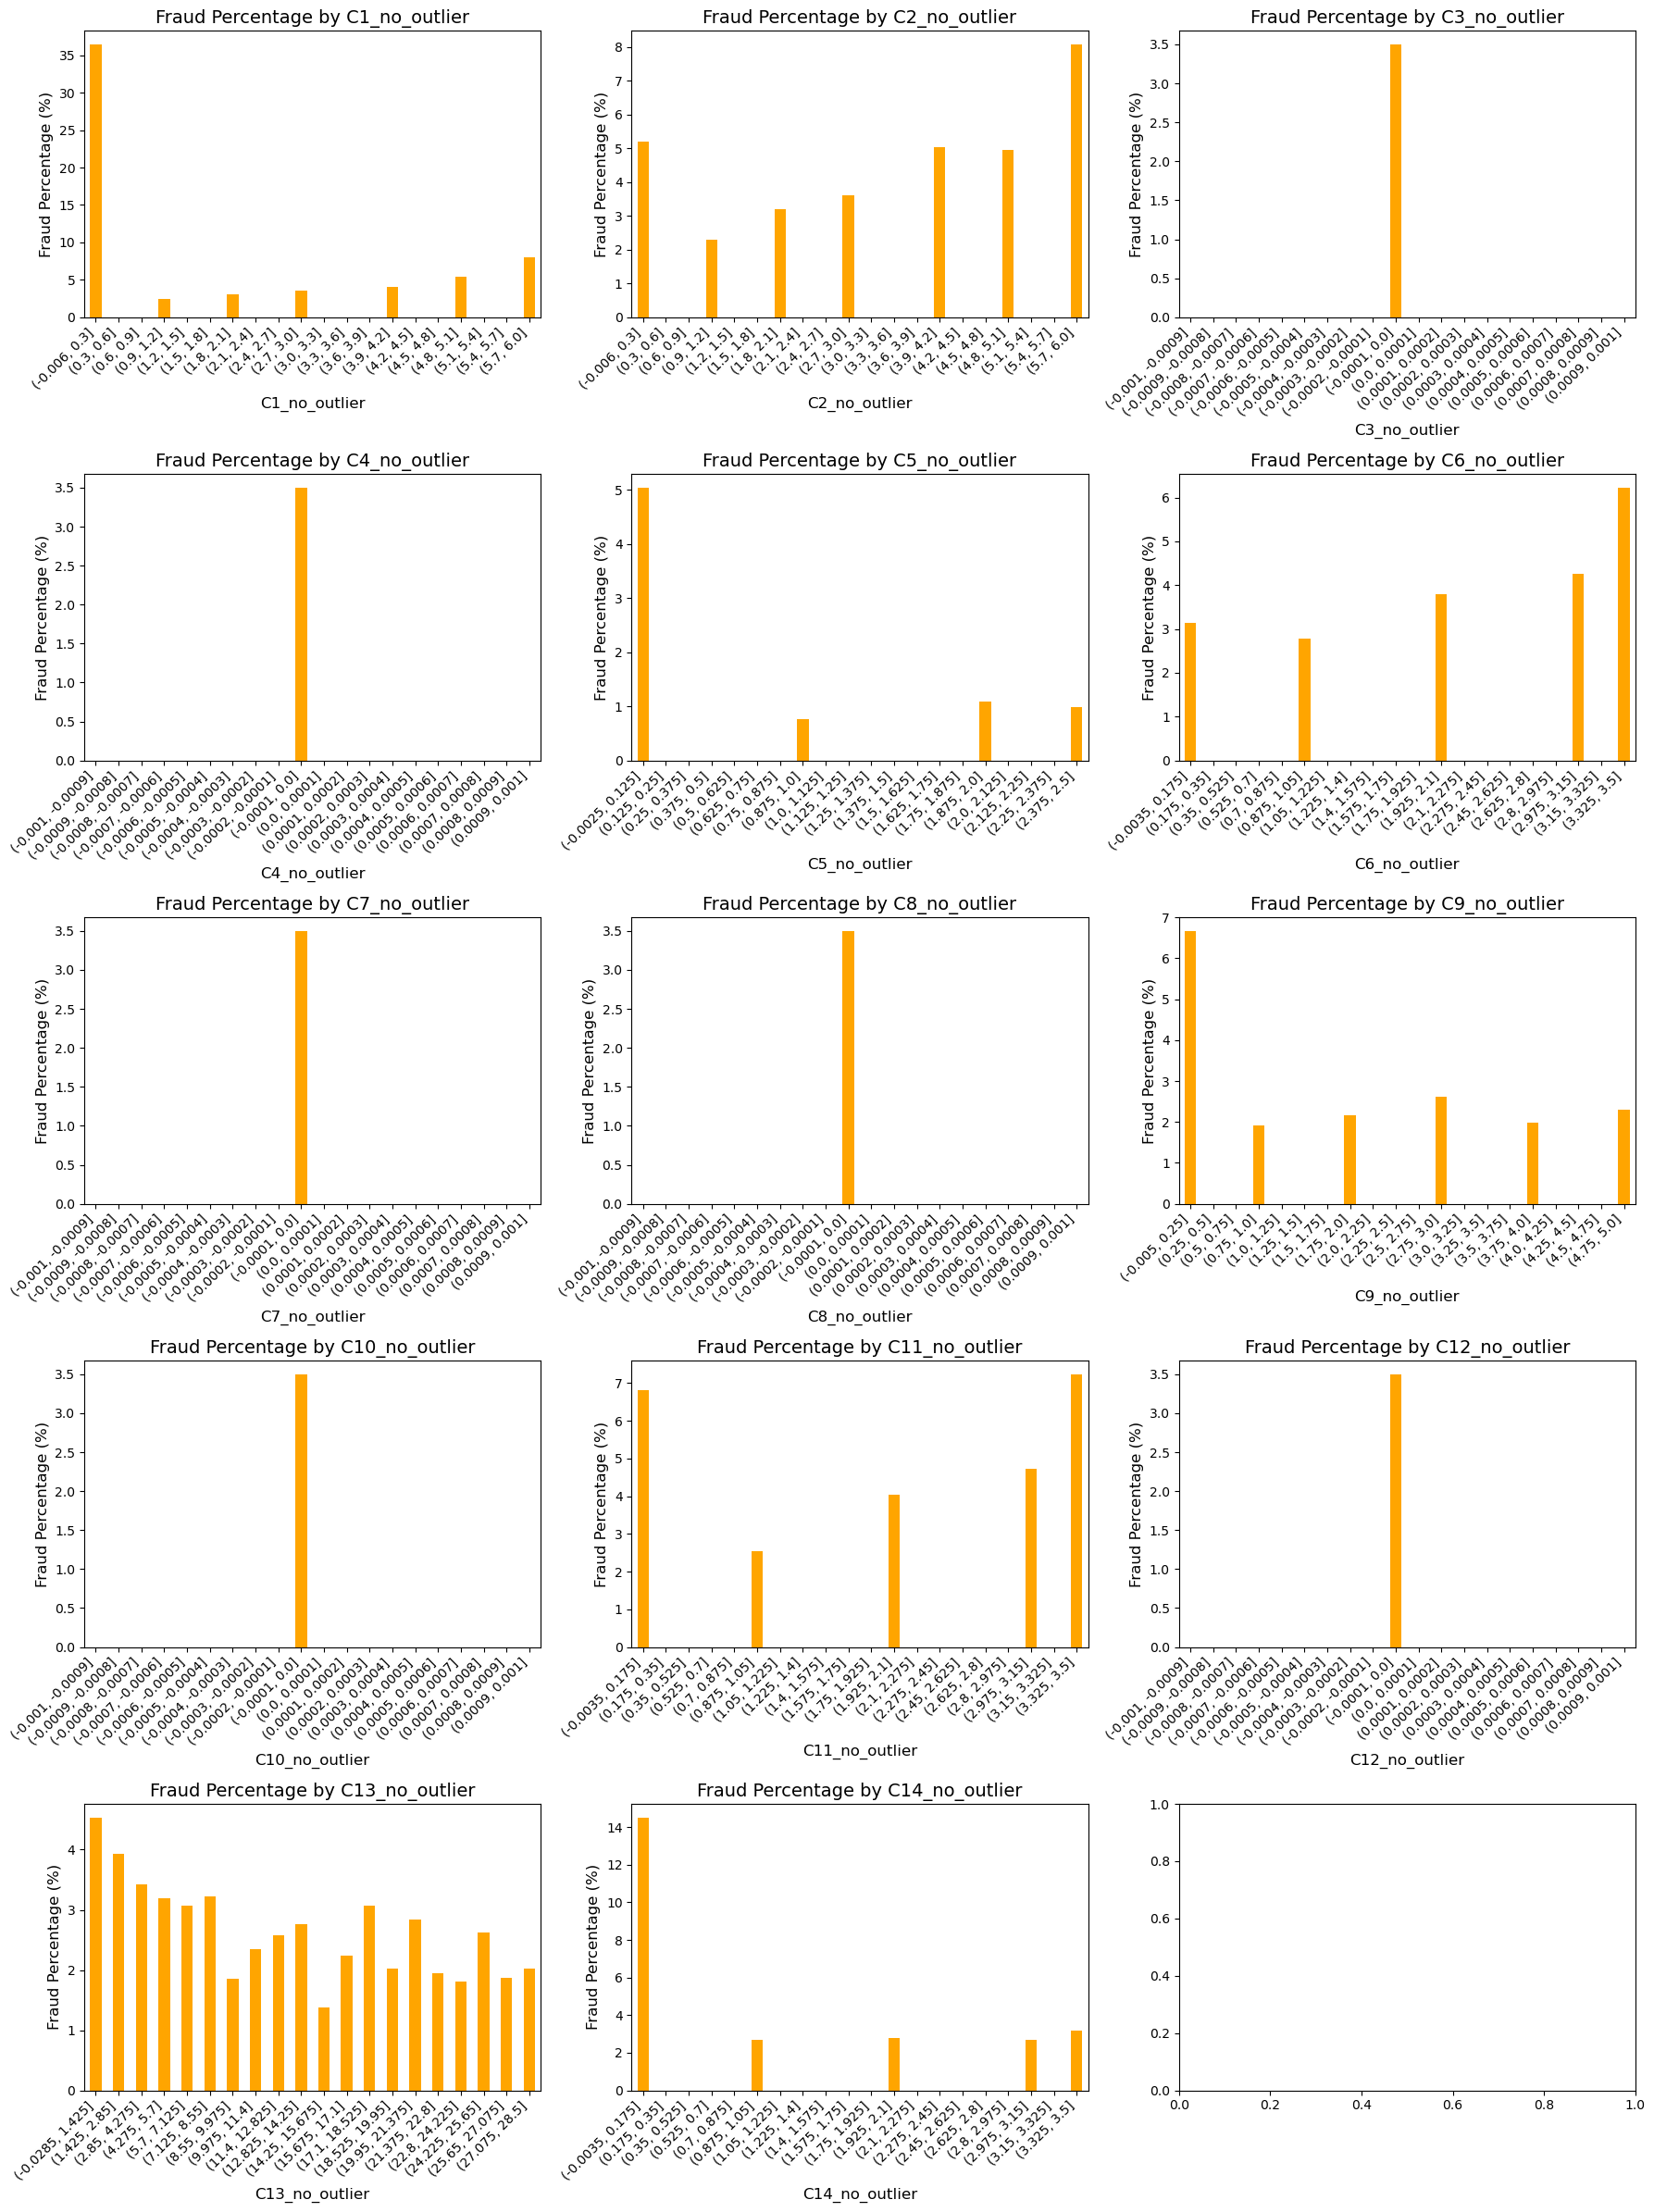

In [135]:
import pandas as pd
import matplotlib.pyplot as plt

# List of columns to analyze
columns_of_interest = [f'C{i}_no_outlier' for i in range(1, 15)]

# Create a figure for subplots
fig, axes = plt.subplots(5, 3, figsize=(18, 24))  # 5 rows and 3 columns
axes = axes.flatten()  # Flatten to easily index the axes

# Iterate through each column and create a plot
for ax, col in zip(axes, columns_of_interest):
    # Convert to float32 to avoid the float16 error
    train_transaction[col] = train_transaction[col].astype('float32')

    # Create bins for the column
    bins = pd.cut(train_transaction[col], bins=20)  # 20 intervals

    # Count fraud cases in each bin
    fraud_counts = train_transaction[train_transaction['isFraud'] == 1].groupby(bins)['isFraud'].count()

    # Total counts in each bin (to calculate percentages)
    total_counts = train_transaction.groupby(bins)['isFraud'].count()

    # Calculate the percentage of frauds for each bin
    fraud_percentages = (fraud_counts / total_counts) * 100
    fraud_percentages = fraud_percentages.fillna(0)  # Replace NaN with 0 for bins with no counts

    # Plotting
    fraud_percentages.plot(kind='bar', color='orange', ax=ax)

    # Set plot titles and labels
    ax.set_title(f'Fraud Percentage by {col}', fontsize=14)
    ax.set_xlabel(col, fontsize=12)
    ax.set_ylabel('Fraud Percentage (%)', fontsize=12)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

In [136]:
import pandas as pd

# Calculate the correlation of C1 to C14 with the isFraud column
correlation_results = train_transaction[[f'C{i}_no_outlier' for i in range(1, 15)] + ['isFraud']].corr()['isFraud']

# Filter the results to show only the correlation of C1 to C14 with isFraud
correlation_results = correlation_results[:-1]  # Exclude 'isFraud' correlation with itself

# Display the correlation results
print(correlation_results)

C1_no_outlier     0.092510
C2_no_outlier     0.099788
C3_no_outlier          NaN
C4_no_outlier          NaN
C5_no_outlier    -0.094437
C6_no_outlier     0.057094
C7_no_outlier          NaN
C8_no_outlier          NaN
C9_no_outlier    -0.066386
C10_no_outlier         NaN
C11_no_outlier    0.082824
C12_no_outlier         NaN
C13_no_outlier   -0.051681
C14_no_outlier   -0.053638
Name: isFraud, dtype: float64


C1, C6, and C12 seem to be more meaningful with the outliers included, but the bins might be misleading. The correlation graph is also not very informative.

After removing the outliers, C1 appears to make more sense, and the correlation graph is now more interesting.

I believe only this variable is relevant here.

In [138]:
new_df['C1_no_outlier'] = train_transaction['C1_no_outlier']

D1-D15

D1-D15: timedelta, such as days between previous transaction, etc.

Let’s explore the potential relationships.


In [141]:
import pandas as pd

# Create a dictionary to store results
results = {
    'column': [],
    'class_count': [],
    'null_count': [],
    'null_percentage': []
}

# Loop through each column from D1 to D15
for i in range(1, 16):  # D1 to D15
    col = f'D{i}'
    
    # Count unique classes
    class_count = train_transaction[col].nunique()
    
    # Count null values
    null_count = train_transaction[col].isnull().sum()
    
    # Total entries in the column
    total_count = train_transaction[col].shape[0]  # Total number of entries

    # Calculate percentage of nulls
    null_percentage = (null_count / total_count) * 100 if total_count > 0 else 0  # Percentage of nulls

    # Store results
    results['column'].append(col)
    results['class_count'].append(class_count)
    results['null_count'].append(null_count)
    results['null_percentage'].append(null_percentage)

# Create a DataFrame from results
results_df = pd.DataFrame(results)

# Display the results DataFrame
print(results_df)

   column  class_count  null_count  null_percentage
0      D1          641        1269         0.214888
1      D2          641      280797        47.549192
2      D3          649      262878        44.514851
3      D4          808      168922        28.604667
4      D5          688      309841        52.467403
5      D6          829      517353        87.606767
6      D7          597      551623        93.409930
7      D8         5367      515614        87.312290
8      D9           24      515614        87.312290
9     D10          818       76022        12.873302
10    D11          676      279287        47.293494
11    D12          635      525823        89.041047
12    D13          577      528588        89.509263
13    D14          802      528353        89.469469
14    D15          859       89113        15.090087


There's a significant amount of missing data. I will start by removing most of it.

In [143]:
import pandas as pd

# Calculate the correlation of D1 to D15 with the isFraud column
correlation_results = train_transaction[[f'D{i}' for i in range(1, 16)] + ['isFraud']].corr()['isFraud']

# Filter the results to show only the correlation of D1 to D15 with isFraud
correlation_results = correlation_results[:-1]  # Exclude 'isFraud' correlation with itself

# Display the correlation results
print(correlation_results)

D1    -0.067193
D2    -0.083583
D3    -0.046271
D4    -0.067216
D5    -0.064638
D6    -0.057236
D7    -0.127199
D8    -0.142634
D9    -0.044250
D10   -0.072002
D11   -0.045094
D12   -0.028864
D13   -0.059430
D14   -0.008663
D15   -0.077519
Name: isFraud, dtype: float64


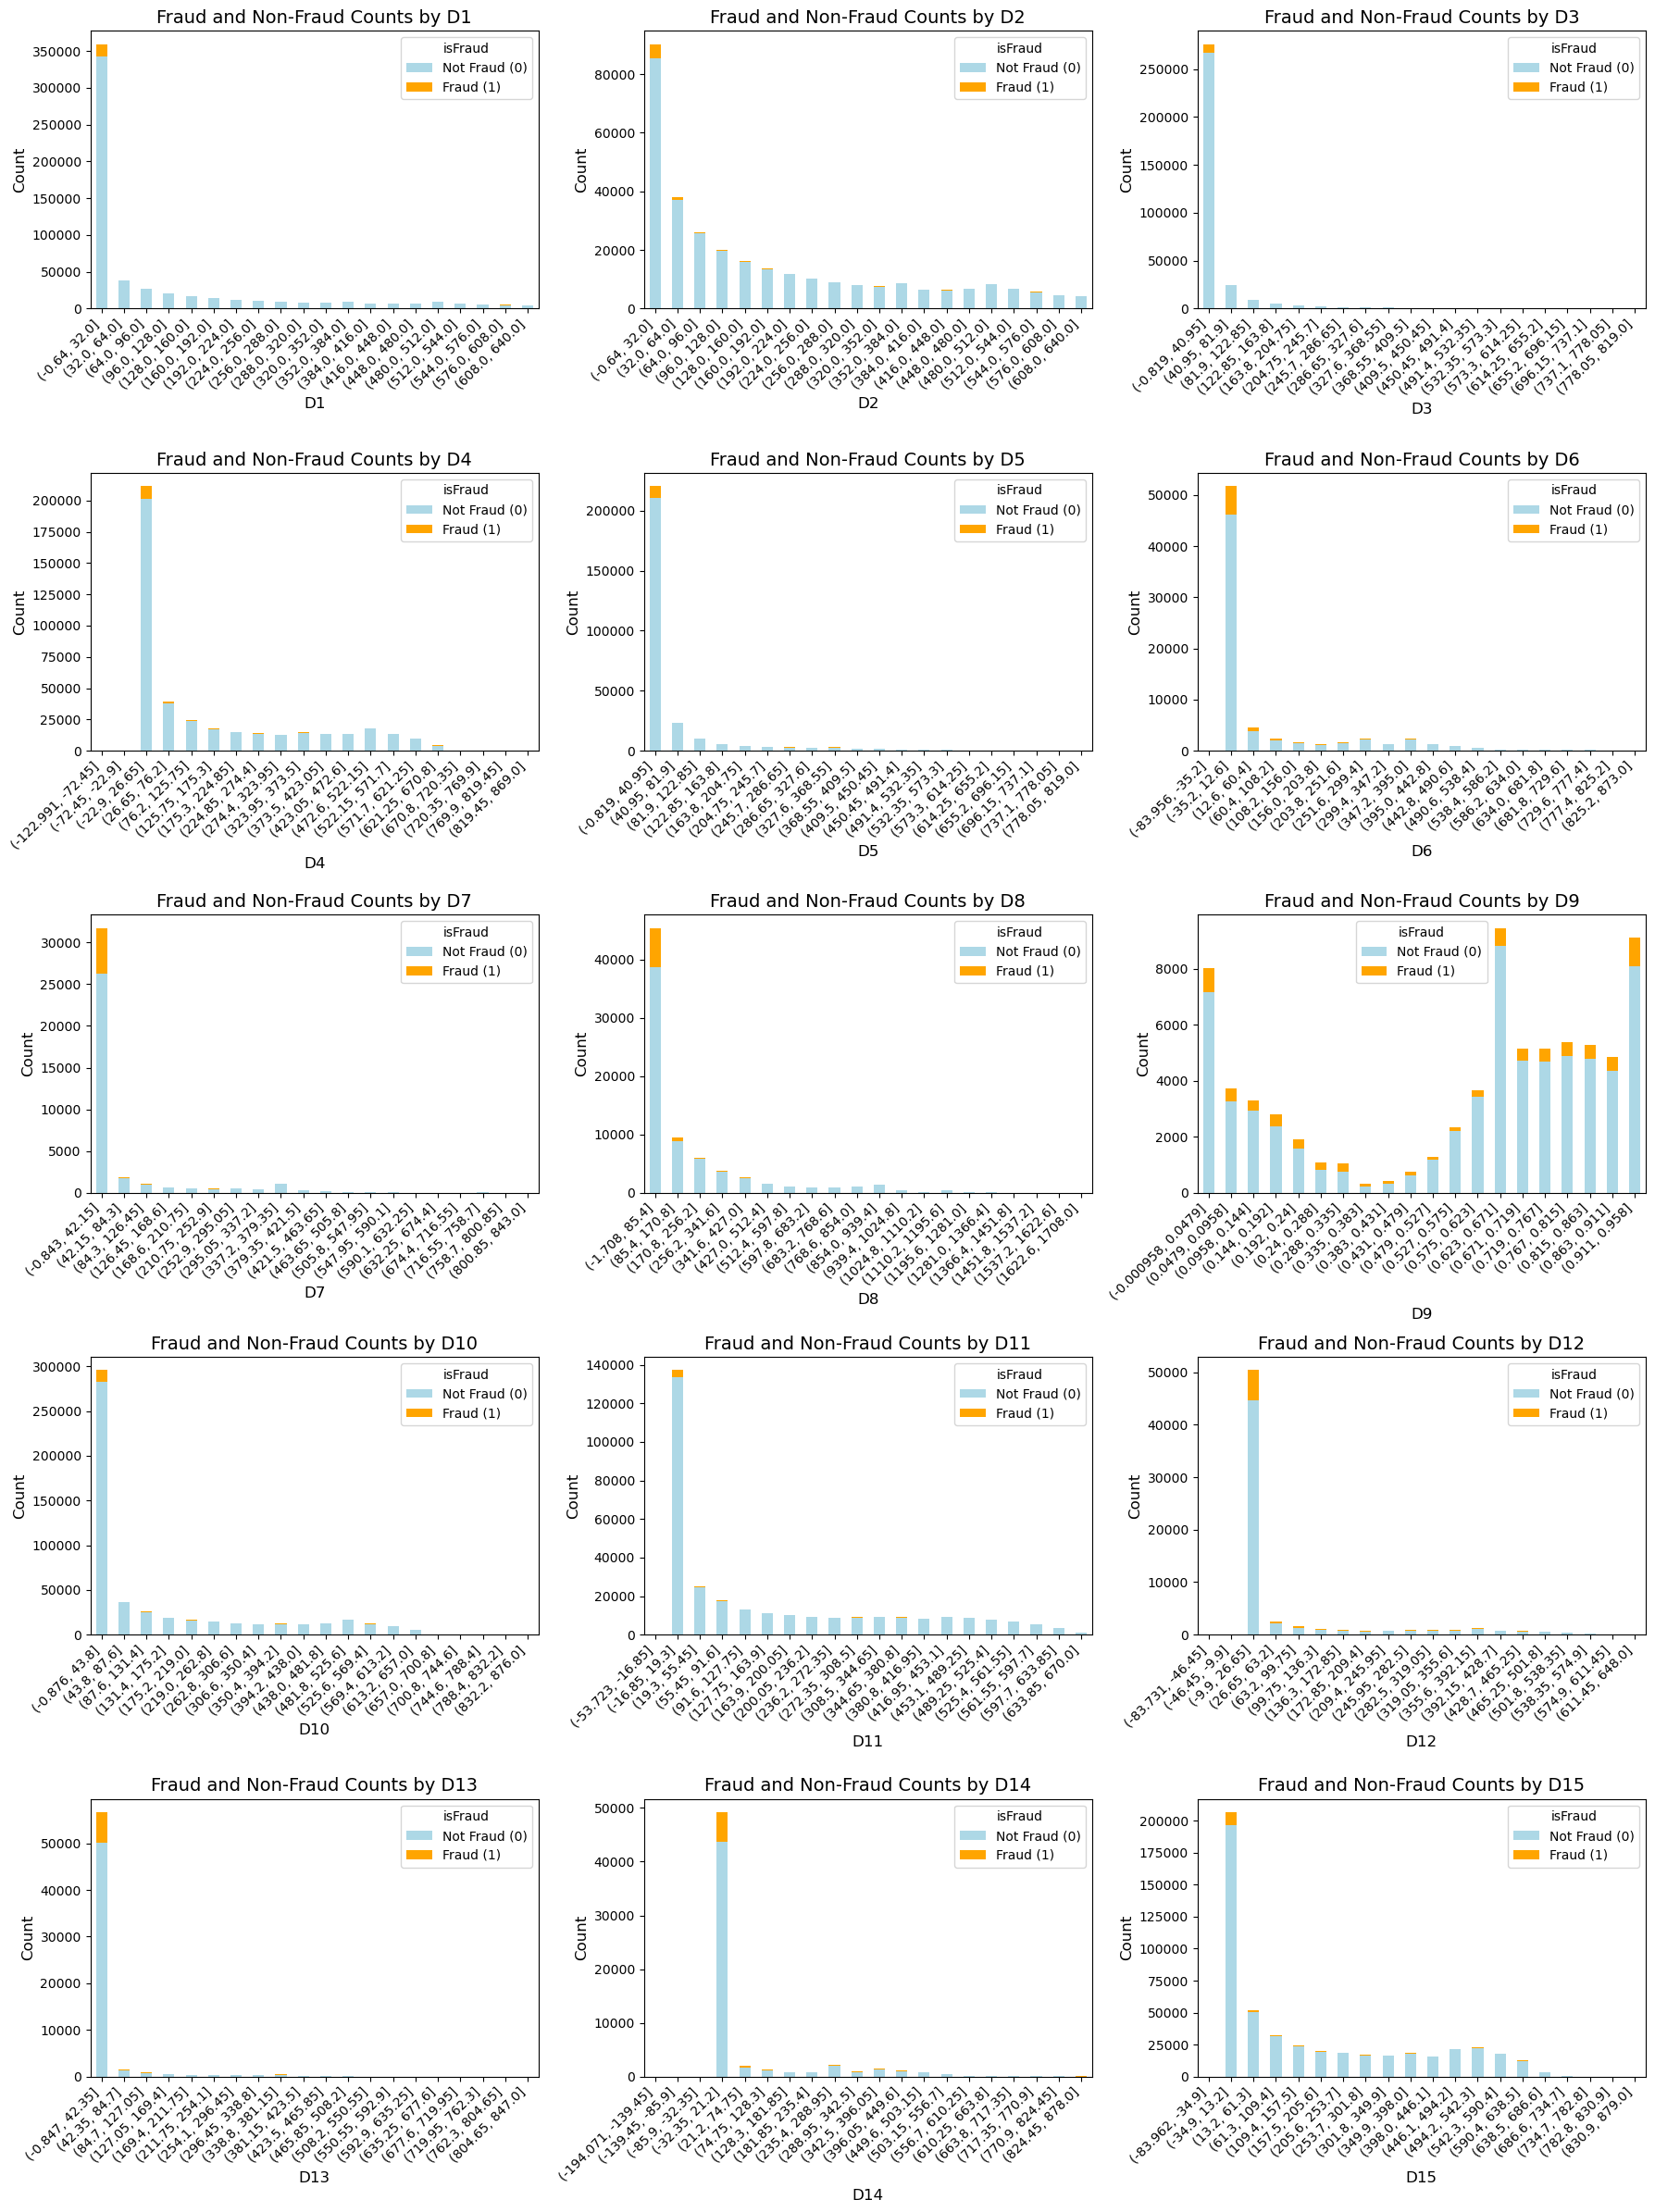

In [144]:
import pandas as pd
import matplotlib.pyplot as plt

# List of columns to analyze
columns_of_interest = [f'D{i}' for i in range(1, 16)]

# Create a figure for subplots
fig, axes = plt.subplots(5, 3, figsize=(18, 24))  # 5 rows and 3 columns
axes = axes.flatten()  # Flatten to easily index the axes

# Iterate through each column and create a plot
for ax, col in zip(axes, columns_of_interest):
    # Convert to float32 to avoid the float16 error
    train_transaction[col] = train_transaction[col].astype('float32')

    # Create bins for the column
    bins = pd.cut(train_transaction[col], bins=20)  # 20 intervals

    # Count fraud and non-fraud cases in each bin
    counts = train_transaction.groupby(bins)['isFraud'].value_counts().unstack(fill_value=0)

    # Create a bar plot with counts
    counts.plot(kind='bar', stacked=True, ax=ax, color=['lightblue', 'orange'])

    # Set plot titles and labels
    ax.set_title(f'Fraud and Non-Fraud Counts by {col}', fontsize=14)
    ax.set_xlabel(col, fontsize=12)
    ax.set_ylabel('Count', fontsize=12)
    ax.legend(title='isFraud', labels=['Not Fraud (0)', 'Fraud (1)'])
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

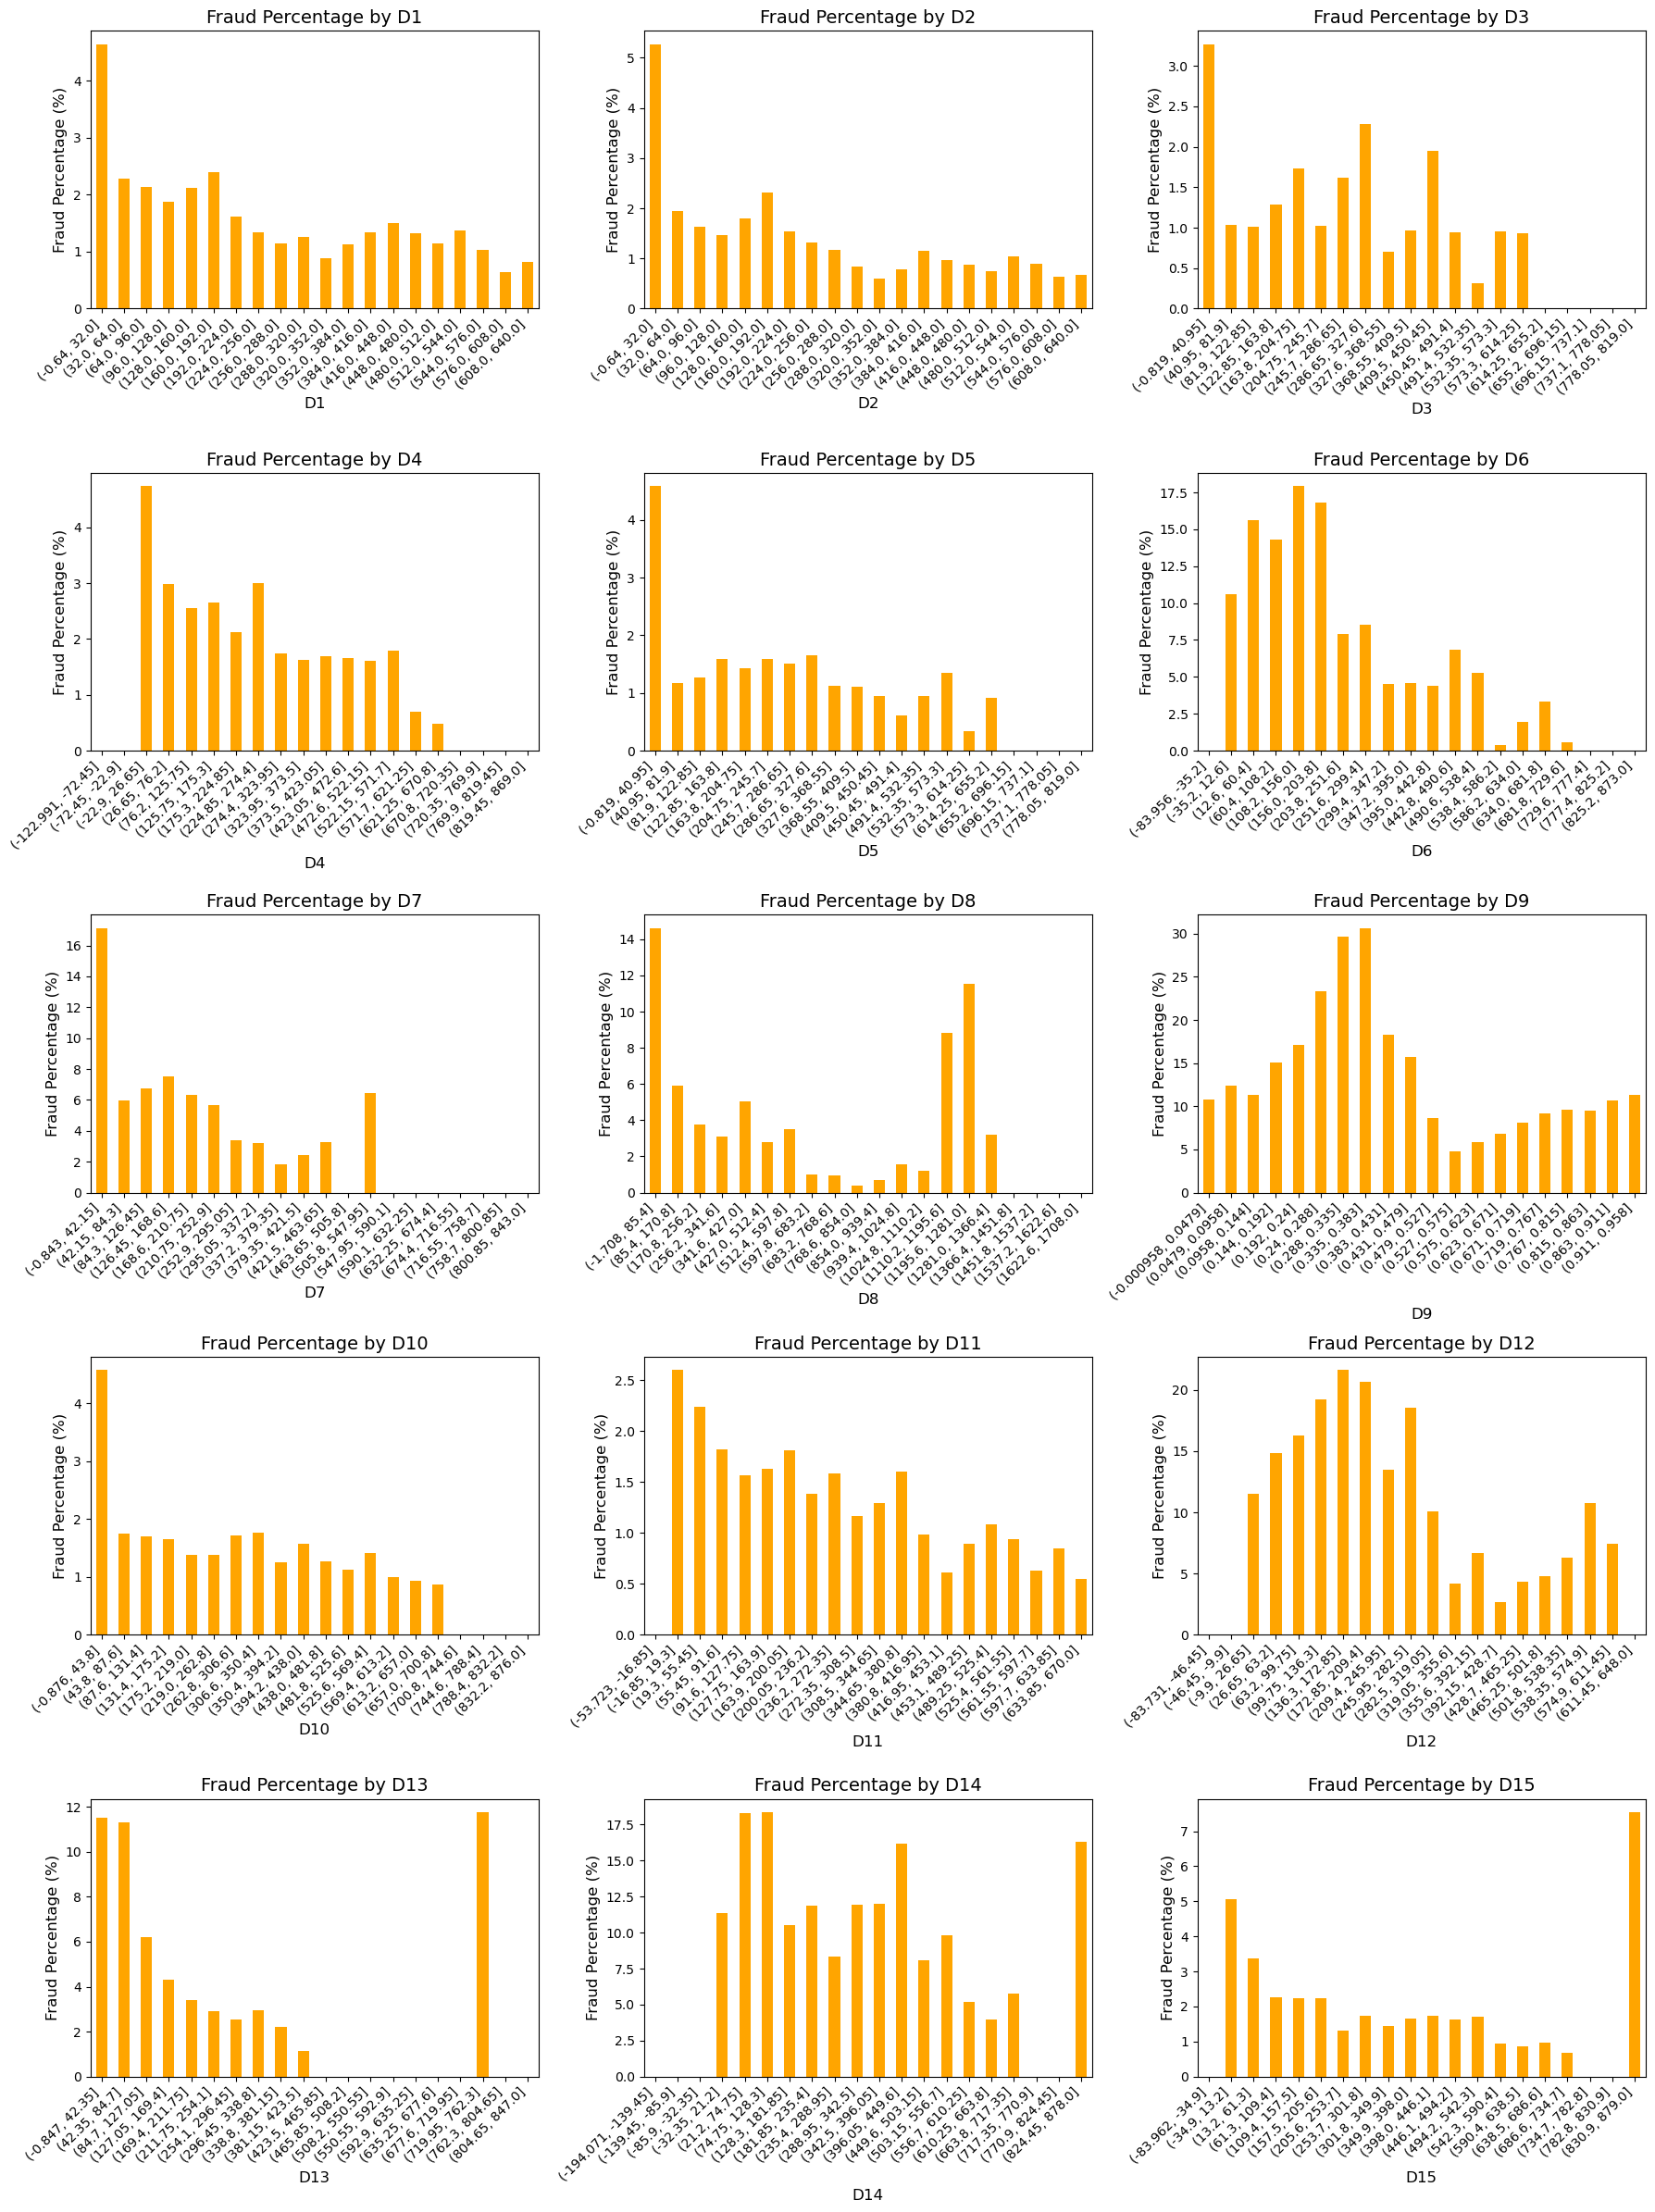

In [145]:
import pandas as pd
import matplotlib.pyplot as plt

# List of columns to analyze
columns_of_interest = [f'D{i}' for i in range(1, 16)]

# Create a figure for subplots
fig, axes = plt.subplots(5, 3, figsize=(18, 24))  # 5 rows and 3 columns
axes = axes.flatten()  # Flatten to easily index the axes

# Iterate through each column and create a plot
for ax, col in zip(axes, columns_of_interest):
    # Convert to float32 to avoid the float16 error
    train_transaction[col] = train_transaction[col].astype('float32')

    # Create bins for the column
    bins = pd.cut(train_transaction[col], bins=20)  # 20 intervals

    # Count fraud cases in each bin
    fraud_counts = train_transaction[train_transaction['isFraud'] == 1].groupby(bins)['isFraud'].count()

    # Total counts in each bin (to calculate percentages)
    total_counts = train_transaction.groupby(bins)['isFraud'].count()

    # Calculate the percentage of frauds for each bin
    fraud_percentages = (fraud_counts / total_counts) * 100
    fraud_percentages = fraud_percentages.fillna(0)  # Replace NaN with 0 for bins with no counts

    # Plotting
    fraud_percentages.plot(kind='bar', color='orange', ax=ax)

    # Set plot titles and labels
    ax.set_title(f'Fraud Percentage by {col}', fontsize=14)
    ax.set_xlabel(col, fontsize=12)
    ax.set_ylabel('Fraud Percentage (%)', fontsize=12)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

Initially, I would look more at cases that have at least 70% of the elements (D1, D4, D10 and D15). 

Their current heat is below 10% but above 5%. I'll give them a chance.

D15 in particular behaves differently in the fraud percentage graph.

In [147]:
new_df['D1'] = train_transaction['D1']
new_df['D4'] = train_transaction['D4']
new_df['D10'] = train_transaction['D10']
new_df['D15'] = train_transaction['D15']

Vxxx

Vxxx: Vesta engineered rich features, including ranking, counting, and other entity relations.
“For example, how many times the payment card associated with an IP and email or address appeared in 24 hour time range, etc.”
"All Vesta features were derived as numerical. some of them are count of orders within a clustering, a time-period or condition, so the value is finite and has ordering (or ranking). I wouldn't recommend to treat any of them as categorical. If any of them resulted in binary by chance, it might be worth trying."

In [150]:
import pandas as pd

# Create a dictionary to store results
results = {
    'column': [],
    'class_count': [],
    'null_count': [],
    'null_percentage': []
}

# Loop through each column from V1 to V339
for i in range(1, 340):  # V1 to V339
    col = f'V{i}'
    
    # Count unique classes
    class_count = train_transaction[col].nunique()
    
    # Count null values
    null_count = train_transaction[col].isnull().sum()
    
    # Total entries in the column
    total_count = train_transaction[col].shape[0]  # Total number of entries

    # Calculate percentage of nulls
    null_percentage = (null_count / total_count) * 100 if total_count > 0 else 0  # Percentage of nulls

    # Store results
    results['column'].append(col)
    results['class_count'].append(class_count)
    results['null_count'].append(null_count)
    results['null_percentage'].append(null_percentage)

# Create a DataFrame from results
results_df = pd.DataFrame(results)

# Display the results DataFrame
print(results_df)

    column  class_count  null_count  null_percentage
0       V1            2      279287        47.293494
1       V2            9      279287        47.293494
2       V3           10      279287        47.293494
3       V4            7      279287        47.293494
4       V5            7      279287        47.293494
..     ...          ...         ...              ...
334   V335          669      508189        86.054967
335   V336          355      508189        86.054967
336   V337          254      508189        86.054967
337   V338          380      508189        86.054967
338   V339          334      508189        86.054967

[339 rows x 4 columns]


In [151]:
# Filter the results DataFrame to show only rows with null_percentage greater than 70
filtered_results_df = results_df[results_df['null_percentage'] < 30]

# Display the filtered DataFrame
print(filtered_results_df)

    column  class_count  null_count  null_percentage
11     V12            4       76073        12.881939
12     V13            7       76073        12.881939
13     V14            2       76073        12.881939
14     V15            8       76073        12.881939
15     V16           15       76073        12.881939
..     ...          ...         ...              ...
316   V317        15184          12         0.002032
317   V318        12309          12         0.002032
318   V319         4799          12         0.002032
319   V320         6439          12         0.002032
320   V321         5560          12         0.002032

[169 rows x 4 columns]


In [152]:
import pandas as pd

# Create a list of columns named from V1 to V339
columns_of_interest = [f'V{i}' for i in range(1, 340)]

# Initialize a dictionary to store null counts
null_counts = train_transaction[columns_of_interest].isnull().sum()

# Calculate the total count for each column
total_counts = train_transaction[columns_of_interest].shape[0]

# Calculate the percentage of nulls for each column
null_percentage = (null_counts / total_counts) * 100

# Filter columns that have less than 30% null values
valid_columns = null_percentage[null_percentage < 30].index

# Calculate the correlation of the valid columns with respect to isFraud
correlation = train_transaction[valid_columns].corrwith(train_transaction['isFraud'])

# Display the correlation results
print(correlation)

V12    -0.052406
V13    -0.045706
V14     0.002145
V15     0.177963
V16     0.174318
          ...   
V317    0.005010
V318    0.000997
V319    0.000061
V320    0.004961
V321    0.001677
Length: 169, dtype: float64


At this point I'm looking for columns that have at least 70% of the elements and the correlation is greater than 5%

In [154]:
import pandas as pd

# Create a list of columns named from V1 to V339
columns_of_interest = [f'V{i}' for i in range(1, 340)]

# Initialize a dictionary to store null counts
null_counts = train_transaction[columns_of_interest].isnull().sum()

# Calculate the total count for each column
total_counts = train_transaction[columns_of_interest].shape[0]

# Calculate the percentage of nulls for each column
null_percentage = (null_counts / total_counts) * 100

# Filter columns that have less than 30% null values
valid_columns = null_percentage[null_percentage < 30].index

# Calculate the correlation of the valid columns with respect to isFraud
correlation = train_transaction[valid_columns].corrwith(train_transaction['isFraud'])

# Filter the correlations to only show those greater than 0.05
filtered_correlation = correlation[correlation.abs() > 0.05]

# Create a list of valid columns based on the criteria
valid_columns_list = filtered_correlation.index.tolist()

# Display the filtered correlation results
print(filtered_correlation)

# Display the list of valid columns
print(valid_columns_list)

V12    -0.052406
V15     0.177963
V16     0.174318
V17     0.182673
V18     0.182550
          ...   
V282    0.104123
V283    0.112731
V302    0.132903
V303    0.124287
V304    0.131498
Length: 83, dtype: float64
['V12', 'V15', 'V16', 'V17', 'V18', 'V21', 'V22', 'V23', 'V24', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V62', 'V63', 'V64', 'V67', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 'V77', 'V78', 'V79', 'V80', 'V81', 'V82', 'V83', 'V84', 'V85', 'V86', 'V87', 'V90', 'V91', 'V92', 'V93', 'V94', 'V108', 'V109', 'V110', 'V111', 'V112', 'V113', 'V114', 'V115', 'V116', 'V123', 'V124', 'V125', 'V281', 'V282', 'V283', 'V302', 'V303', 'V304']


In [155]:
import pandas as pd

# Initialize lists for categorical and numeric columns
categorical_columns = []
numeric_columns = []

# List of numeric data types to check
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

# Iterate through the columns and classify them
for column in valid_columns_list:
    if train_transaction[column].dtype in numerics:
        # If it's a numeric type, add to numeric columns
        numeric_columns.append(column)
    else:
        # If not numeric, classify as categorical
        categorical_columns.append(column)

# Print the results
print("Categorical Columns:")
print(categorical_columns)
print("\nNumeric Columns (specified types):")
print(numeric_columns)

Categorical Columns:
[]

Numeric Columns (specified types):
['V12', 'V15', 'V16', 'V17', 'V18', 'V21', 'V22', 'V23', 'V24', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V62', 'V63', 'V64', 'V67', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 'V77', 'V78', 'V79', 'V80', 'V81', 'V82', 'V83', 'V84', 'V85', 'V86', 'V87', 'V90', 'V91', 'V92', 'V93', 'V94', 'V108', 'V109', 'V110', 'V111', 'V112', 'V113', 'V114', 'V115', 'V116', 'V123', 'V124', 'V125', 'V281', 'V282', 'V283', 'V302', 'V303', 'V304']


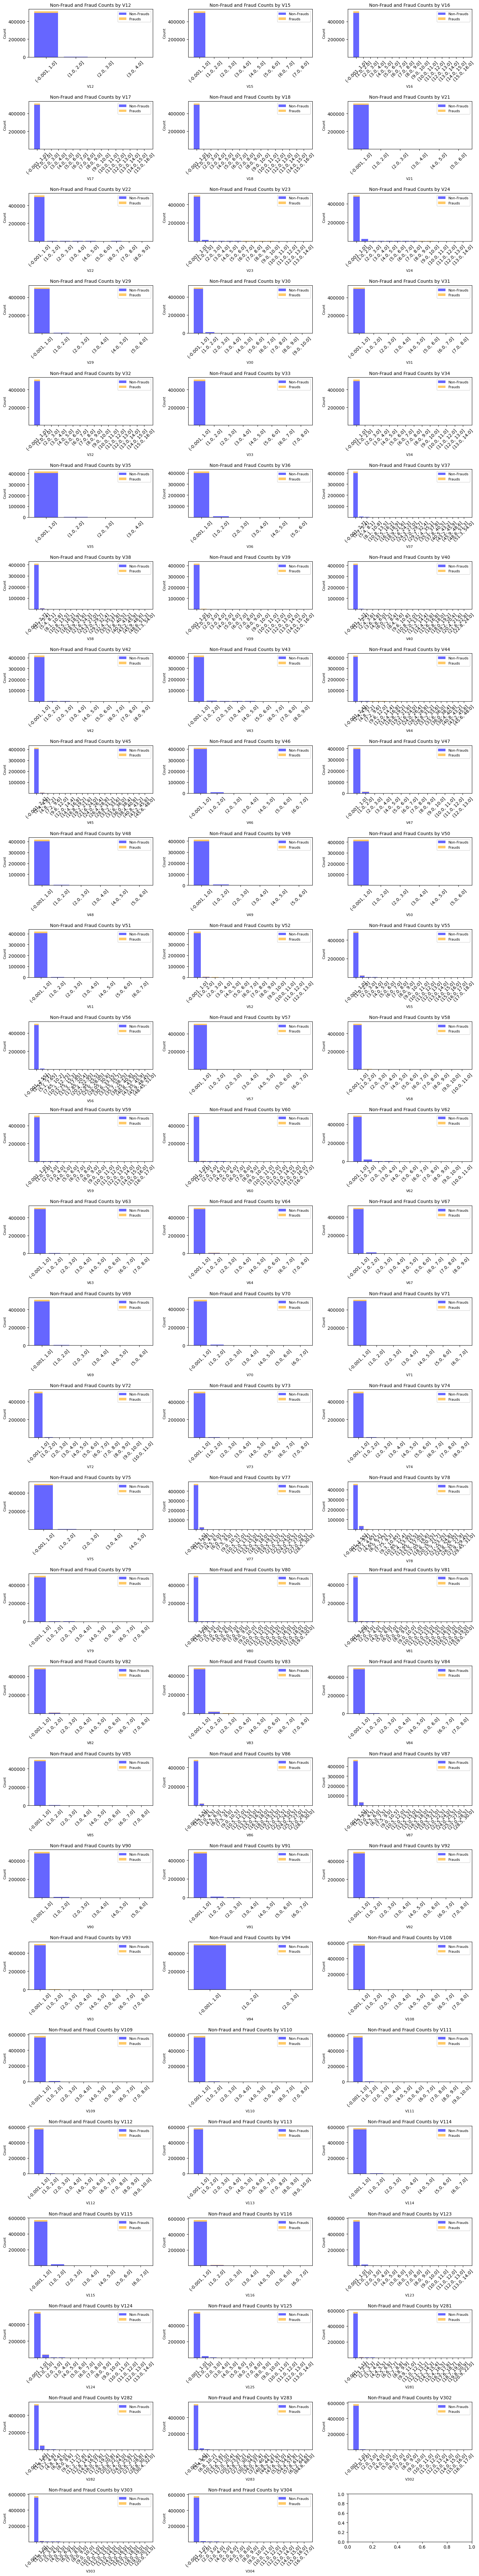

In [156]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Function to plot fraud counts based on intervals
def plot_fraud_intervals(data, columns_to_plot):
    # Set up the figure and axes for 28 rows and 3 columns
    fig, axes = plt.subplots(28, 3, figsize=(15, 80))  # Adjust figsize as necessary
    fig.subplots_adjust(hspace=0.5, wspace=0.3)  # Adjust spacing between plots

    for index, col in enumerate(columns_to_plot):
        ax = axes[index // 3, index % 3]  # Determine the subplot location
        
        # Convert the column to numeric and to float32 to avoid errors
        data[col] = pd.to_numeric(data[col], errors='coerce').astype(np.float32)
        
        # Drop NA values after conversion
        col_data = data[col].dropna()

        # Determine the range and intervals
        if col_data.max() - col_data.min() > 20:
            intervals = 20
            bins = np.linspace(col_data.min(), col_data.max(), intervals + 1)
        else:
            max_int = int(col_data.max())
            bins = np.arange(col_data.min(), max_int + 2, 1)  # +2 to include max int in the bins

        # Create a new DataFrame to store fraud counts
        binned_data = pd.cut(col_data, bins=bins, include_lowest=True)

        # Count frauds and non-frauds in each bin
        fraud_counts = data[data['isFraud'] == 1].groupby(binned_data).size()
        non_fraud_counts = data[data['isFraud'] == 0].groupby(binned_data).size()

        # Plotting in the specified axis
        ax.bar(binned_data.cat.categories.astype(str), non_fraud_counts, color='blue', label='Non-Frauds', alpha=0.6)
        ax.bar(binned_data.cat.categories.astype(str), fraud_counts, color='orange', label='Frauds', alpha=0.6, bottom=non_fraud_counts)
        
        ax.set_title(f'Non-Fraud and Fraud Counts by {col}', fontsize=10)
        ax.set_xlabel(col, fontsize=8)
        ax.set_ylabel('Count', fontsize=8)
        ax.tick_params(axis='x', rotation=45)  # Rotate x labels for better visibility
        ax.legend(fontsize=8)

    plt.tight_layout()  # Adjust layout to fit titles and labels
    plt.show()

# Example of how to call the function
plot_fraud_intervals(train_transaction, valid_columns_list)

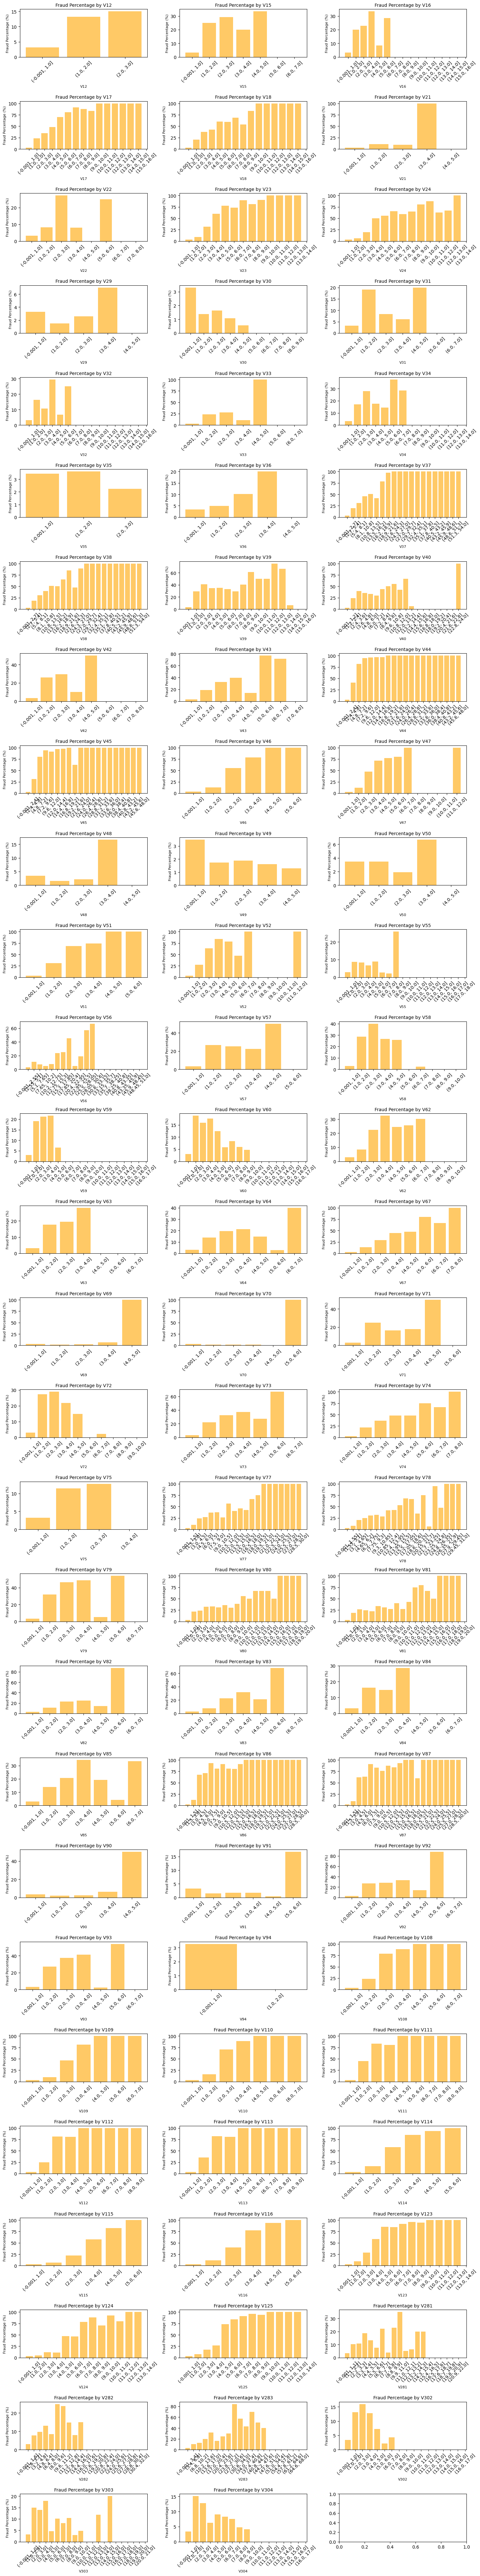

In [157]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Sample DataFrame, assuming train_transaction already exists
# columns_to_plot = [...] # Replace this with your actual list of columns

# Function to plot fraud percentages based on intervals
def plot_fraud_percentage_intervals(data, columns_to_plot):
    # Set up the figure and axes for 28 rows and 3 columns
    fig, axes = plt.subplots(28, 3, figsize=(15, 80))  # Adjust figsize as necessary
    fig.subplots_adjust(hspace=0.5, wspace=0.3)  # Adjust spacing between plots

    for index, col in enumerate(columns_to_plot):
        ax = axes[index // 3, index % 3]  # Determine the subplot location
        
        # Convert the column to numeric, if not already
        data[col] = pd.to_numeric(data[col], errors='coerce').astype(np.float32)
        
        # Drop NA values after conversion
        col_data = data[col].dropna()

        # Determine the range and intervals
        if col_data.max() - col_data.min() > 20:
            intervals = 20
            bins = np.linspace(col_data.min(), col_data.max(), intervals + 1)
        else:
            max_int = int(col_data.max())
            bins = np.arange(col_data.min(), max_int + 2, 1)  # +2 to include max int in the bins

        # Create a new DataFrame to store fraud counts
        binned_data = pd.cut(col_data, bins=bins, include_lowest=True)

        # Count frauds and total entries in each bin
        fraud_counts = data[data['isFraud'] == 1].groupby(binned_data).size()
        total_counts = binned_data.value_counts()

        # Calculate the percentage of frauds for each bin
        fraud_percentage = (fraud_counts / total_counts) * 100

        # Plotting in the specified axis
        ax.bar(fraud_percentage.index.astype(str), fraud_percentage, color='orange', alpha=0.6)
        
        ax.set_title(f'Fraud Percentage by {col}', fontsize=10)
        ax.set_xlabel(col, fontsize=8)
        ax.set_ylabel('Fraud Percentage (%)', fontsize=8)
        ax.tick_params(axis='x', rotation=45)  # Rotate x labels for better visibility

    plt.tight_layout()  # Adjust layout to fit titles and labels
    plt.show()

# Example of how to call the function
plot_fraud_percentage_intervals(train_transaction, valid_columns_list)

It seems that we have some outliers in the data; let's work on addressing them as well.

In [159]:
for col in valid_columns_list:
    train_transaction = treat_outliers(train_transaction, col)

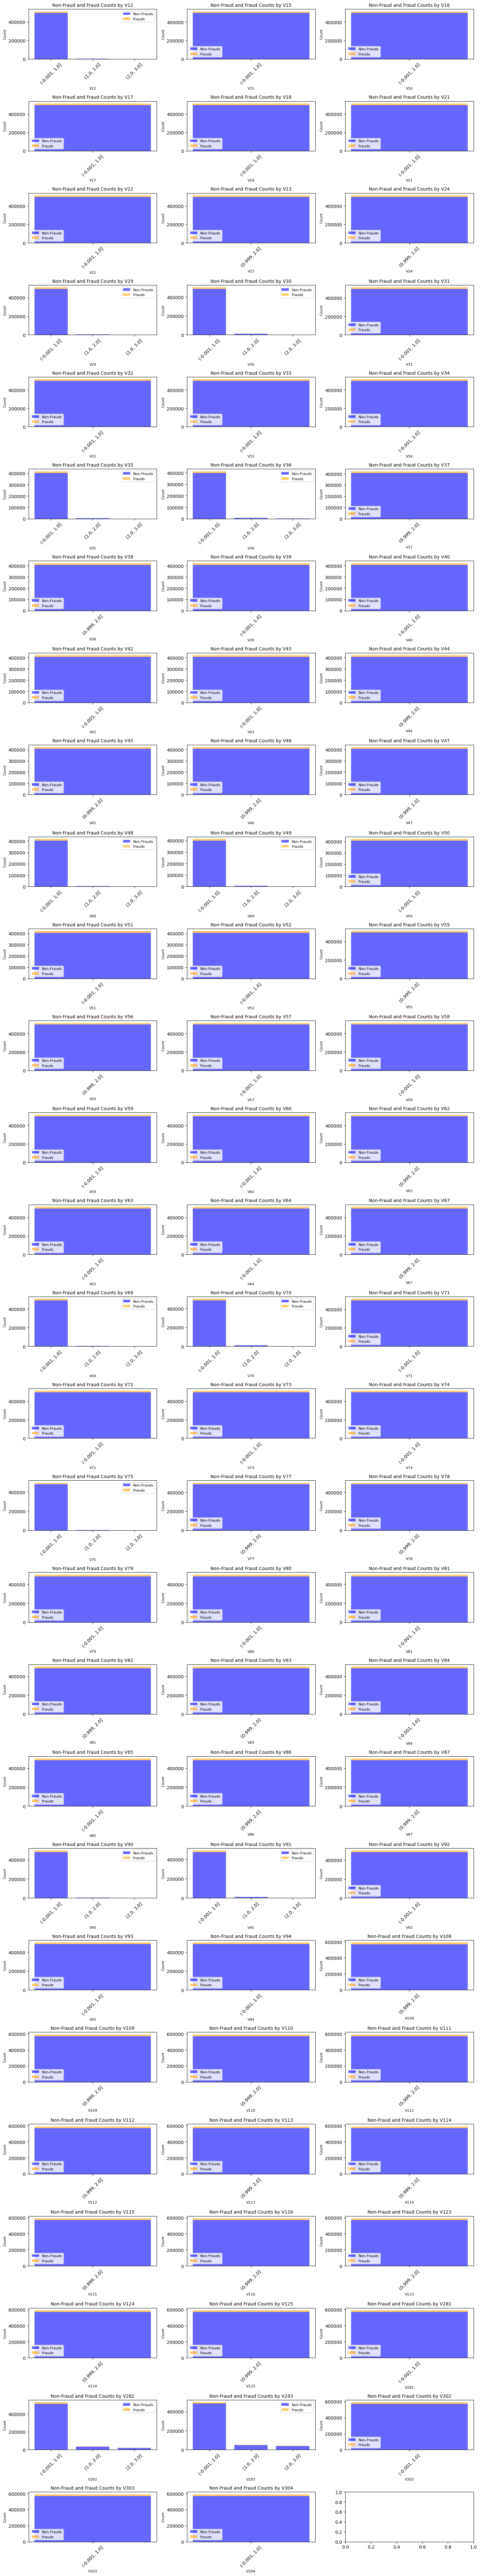

In [160]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Function to plot fraud counts based on intervals
def plot_fraud_intervals(data, columns_to_plot):
    # Set up the figure and axes for 28 rows and 3 columns
    fig, axes = plt.subplots(28, 3, figsize=(15, 80))  # Adjust figsize as necessary
    fig.subplots_adjust(hspace=0.5, wspace=0.3)  # Adjust spacing between plots

    for index, col in enumerate(columns_to_plot):
        ax = axes[index // 3, index % 3]  # Determine the subplot location
        # Convert the column to numeric, if not already
        data[col+"_no_outlier"] = pd.to_numeric(data[col+"_no_outlier"], errors='coerce').astype(np.float32)
        
        # Drop NA values after conversion
        col_data = data[col+"_no_outlier"].dropna()

        # Determine the range and intervals
        if col_data.max() - col_data.min() > 20:
            intervals = 20
            bins = np.linspace(col_data.min(), col_data.max(), intervals + 1)
        else:
            max_int = int(col_data.max())
            bins = np.arange(col_data.min(), max_int + 2, 1)  # +2 to include max int in the bins

        # Create a new DataFrame to store fraud counts
        binned_data = pd.cut(col_data, bins=bins, include_lowest=True)

        # Count frauds and non-frauds in each bin
        fraud_counts = data[data['isFraud'] == 1].groupby(binned_data).size()
        non_fraud_counts = data[data['isFraud'] == 0].groupby(binned_data).size()

        # Plotting in the specified axis
        ax.bar(binned_data.cat.categories.astype(str), non_fraud_counts, color='blue', label='Non-Frauds', alpha=0.6)
        ax.bar(binned_data.cat.categories.astype(str), fraud_counts, color='orange', label='Frauds', alpha=0.6, bottom=non_fraud_counts)
        
        ax.set_title(f'Non-Fraud and Fraud Counts by {col}', fontsize=10)
        ax.set_xlabel(col, fontsize=8)
        ax.set_ylabel('Count', fontsize=8)
        ax.tick_params(axis='x', rotation=45)  # Rotate x labels for better visibility
        ax.legend(fontsize=8)

    plt.tight_layout()  # Adjust layout to fit titles and labels
    plt.show()

# Example of how to call the function
plot_fraud_intervals(train_transaction, valid_columns_list)

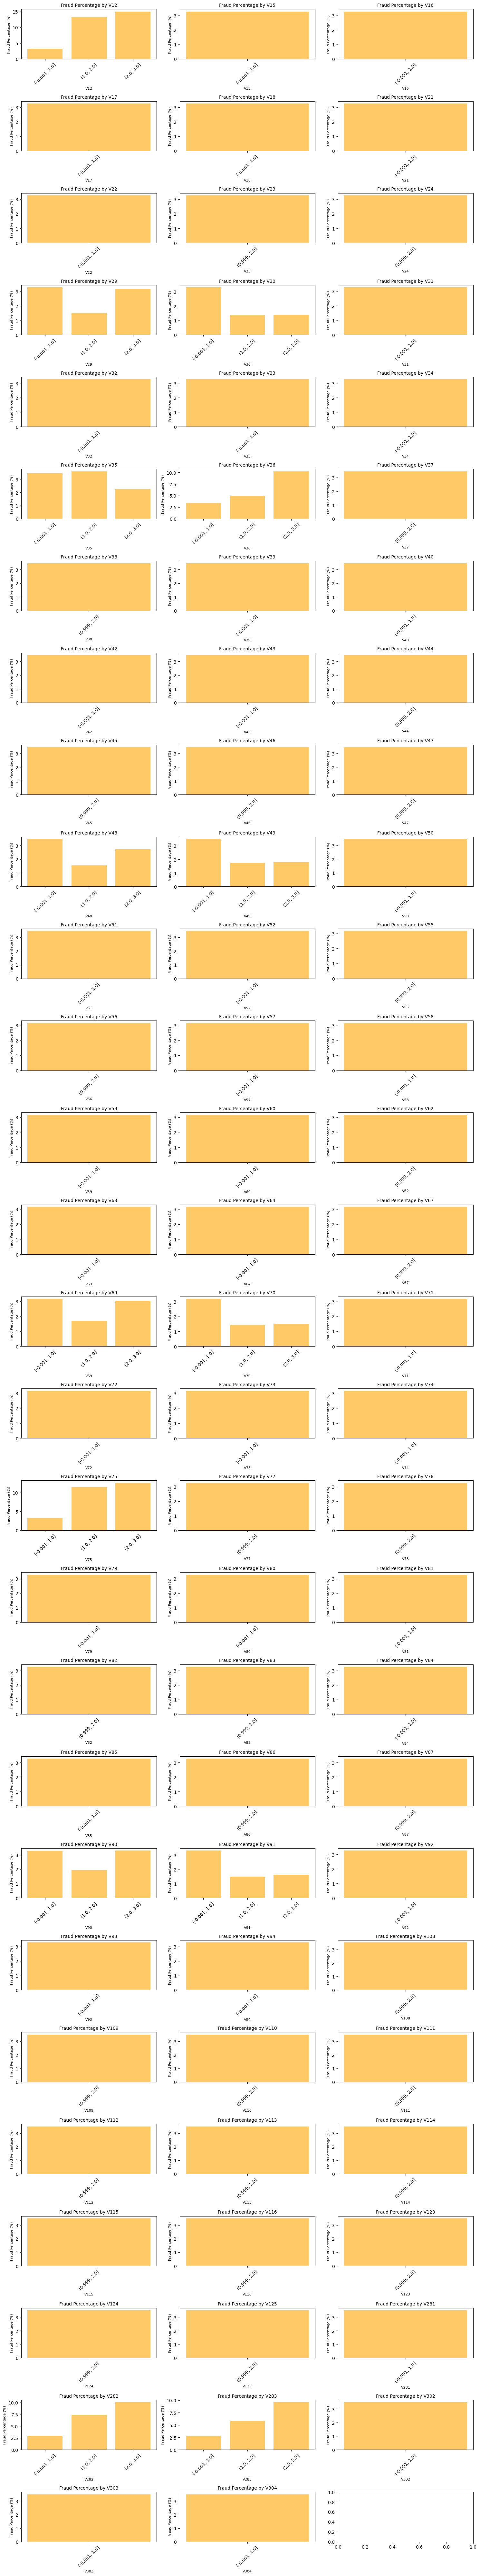

In [161]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Sample DataFrame, assuming train_transaction already exists
# columns_to_plot = [...] # Replace this with your actual list of columns

# Function to plot fraud percentages based on intervals
def plot_fraud_percentage_intervals(data, columns_to_plot):
    # Set up the figure and axes for 28 rows and 3 columns
    fig, axes = plt.subplots(28, 3, figsize=(15, 80))  # Adjust figsize as necessary
    fig.subplots_adjust(hspace=0.5, wspace=0.3)  # Adjust spacing between plots

    for index, col in enumerate(columns_to_plot):
        ax = axes[index // 3, index % 3]  # Determine the subplot location
        
        # Convert the column to numeric, if not already
        data[col+"_no_outlier"] = pd.to_numeric(data[col+"_no_outlier"], errors='coerce').astype(np.float32)
        
        # Drop NA values after conversion
        col_data = data[col+"_no_outlier"].dropna()

        # Determine the range and intervals
        if col_data.max() - col_data.min() > 20:
            intervals = 20
            bins = np.linspace(col_data.min(), col_data.max(), intervals + 1)
        else:
            max_int = int(col_data.max())
            bins = np.arange(col_data.min(), max_int + 2, 1)  # +2 to include max int in the bins

        # Create a new DataFrame to store fraud counts
        binned_data = pd.cut(col_data, bins=bins, include_lowest=True)

        # Count frauds and total entries in each bin
        fraud_counts = data[data['isFraud'] == 1].groupby(binned_data).size()
        total_counts = binned_data.value_counts()

        # Calculate the percentage of frauds for each bin
        fraud_percentage = (fraud_counts / total_counts) * 100

        # Plotting in the specified axis
        ax.bar(fraud_percentage.index.astype(str), fraud_percentage, color='orange', alpha=0.6)
        
        ax.set_title(f'Fraud Percentage by {col}', fontsize=10)
        ax.set_xlabel(col, fontsize=8)
        ax.set_ylabel('Fraud Percentage (%)', fontsize=8)
        ax.tick_params(axis='x', rotation=45)  # Rotate x labels for better visibility

    plt.tight_layout()  # Adjust layout to fit titles and labels
    plt.show()

# Example of how to call the function
plot_fraud_percentage_intervals(train_transaction, valid_columns_list)

In [162]:
import pandas as pd

# Initialize an empty list to store correlations
correlation_list = []

# Loop through the list and add the correlations to the list if greater than 0.05
for column in valid_columns_list:
    correlation = train_transaction[column].corr(train_transaction['isFraud'])
    if abs(correlation) > 0.05:  # Check if the absolute correlation is greater than 0.05
        correlation_list.append((column, correlation))

# Display the resulting list
print(correlation_list)

[('V12', -0.052406009175087434), ('V15', 0.17796304981335315), ('V16', 0.17431823036773117), ('V17', 0.18267262266142326), ('V18', 0.18254989816567782), ('V21', 0.1659847613953922), ('V22', 0.1588144833742915), ('V23', 0.1494077737151307), ('V24', 0.123824303173343), ('V29', -0.10785177266364034), ('V30', -0.10308792418963254), ('V31', 0.16316648223869615), ('V32', 0.16019713121120827), ('V33', 0.1834861890619286), ('V34', 0.1803005941542257), ('V35', -0.0771156528647558), ('V36', -0.06987475318171406), ('V37', 0.17694684591206888), ('V38', 0.19900451029896063), ('V39', 0.2030965290785186), ('V40', 0.21244182978324228), ('V42', 0.18942828273151938), ('V43', 0.19827388575892327), ('V44', 0.2603761673463103), ('V45', 0.28183194637674736), ('V46', 0.1259908548859325), ('V47', 0.16411406343485557), ('V48', -0.11578587857758549), ('V49', -0.11092009108457428), ('V50', 0.17995328566599447), ('V51', 0.2231911021667619), ('V52', 0.23946916785402), ('V55', 0.050113765663216216), ('V56', 0.06135

In [163]:
len(correlation_list)

83

It seems that the outlier treatment did not significantly impact the correlation.

The initial list of elements seems reasonable, and I plan to explore it further.

Initial Items

In [167]:
for column in valid_columns_list:
    new_df[column] = train_transaction[column]

Let's review what we have organized so far.

We still need to perform one-hot encoding on the categorical variables.

New dataset

In [171]:
new_df.shape

(590540, 114)

Split data

In [175]:
import pandas as pd
# Split the data into X (features) and y (target)
X = new_df
y = train_transaction['isFraud']  # Only the 'isFraud' column

In [177]:
X.shape

(590540, 114)

In [179]:
y.shape

(590540,)

In [183]:
!pip install xgboost

   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.1/124.9 MB 1.7 MB/s eta 0:01:16
   ---------------------------------------- 0.6/124.9 MB 5.3 MB/s eta 0:00:24
    --------------------------------------- 1.8/124.9 MB 11.3 MB/s eta 0:00:11
   - -------------------------------------- 3.2/124.9 MB 17.2 MB/s eta 0:00:08
   - -------------------------------------- 4.2/124.9 MB 19.2 MB/s eta 0:00:07
   - -------------------------------------- 4.2/124.9 MB 19.2 MB/s eta 0:00:07
   - -------------------------------------- 4.2/124.9 MB 19.2 MB/s eta 0:00:07
   - -------------------------------------- 4.2/124.9 MB 19.2 MB/s eta 0:00:07
   - -------------------------------------- 4.2/124.9 MB 19.2 MB/s eta 0:00:07
   - -------------------------------------- 4.2/124.9 MB 19.2 MB/s eta 0:00:07
   - -------------------------------------- 4.2/124.9 MB 19.2 MB/s eta

In [191]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Create and train the XGBoost model
model = XGBClassifier(random_state=42)
model.fit(X_train, y_train)

# Make predictions for the test set
y_pred_test = model.predict(X_test)

# Generate the classification report for the test set
report_test = classification_report(y_test, y_pred_test, output_dict=True)

# Retrieve precision, recall, f1-score, and support for the test set
metrics_test = {
    'precision': report_test['1']['precision'],
    'recall': report_test['1']['recall'],
    'f1-score': report_test['1']['f1-score'],
}

# Make predictions for the training set
y_pred_train = model.predict(X_train)

# Generate the classification report for the training set
report_train = classification_report(y_train, y_pred_train, output_dict=True)

# Retrieve precision, recall, f1-score, and support for the training set
metrics_train = {
    'precision': report_train['1']['precision'],
    'recall': report_train['1']['recall'],
    'f1-score': report_train['1']['f1-score'],
}

print("Metrics for the test set:")
print(metrics_test)

print("\nMetrics for the training set:")
print(metrics_train)

Metrics for the test set:
{'precision': 0.8602816901408451, 'recall': 0.3694652794580208, 'f1-score': 0.516926201760325}

Metrics for the training set:
{'precision': 0.9063655030800821, 'recall': 0.40054446460980037, 'f1-score': 0.555569540591567}


In [195]:
!pip install lightgbm

   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   --- ------------------------------------ 0.1/1.4 MB 3.2 MB/s eta 0:00:01
   ---------------------------- ----------- 1.0/1.4 MB 13.1 MB/s eta 0:00:01
   ---------------------------------------- 1.4/1.4 MB 13.0 MB/s eta 0:00:00


In [197]:
import pandas as pd
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Create and train the LightGBM model
model = LGBMClassifier(random_state=42)
model.fit(X_train, y_train)

# Make predictions for the test set
y_pred_test = model.predict(X_test)

# Generate the classification report for the test set
report_test = classification_report(y_test, y_pred_test, output_dict=True)

# Retrieve precision, recall, f1-score, and support for the test set
metrics_test = {
    'precision': report_test['1']['precision'],
    'recall': report_test['1']['recall'],
    'f1-score': report_test['1']['f1-score'],
}

# Make predictions for the training set
y_pred_train = model.predict(X_train)

# Generate the classification report for the training set
report_train = classification_report(y_train, y_pred_train, output_dict=True)

# Retrieve precision, recall, f1-score, and support for the training set
metrics_train = {
    'precision': report_train['1']['precision'],
    'recall': report_train['1']['recall'],
    'f1-score': report_train['1']['f1-score'],
}

print("Metrics for the test set:")
print(metrics_test)

print("\nMetrics for the training set:")
print(metrics_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 16530, number of negative: 455902
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.078375 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2650
[LightGBM] [Info] Number of data points in the train set: 472432, number of used features: 113
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.034989 -> initscore=-3.317101
[LightGBM] [Info] Start training from score -3.317101
Metrics for the test set:
{'precision': 0.8229291716686674, 'recall': 0.3317203000241955, 'f1-score': 0.47284014485256076}

Metrics for the training set:
{'precision': 0.8575268817204301, 'recall': 0.3473684210526316, 'f1-score': 0.49444587961766984}


In [207]:
import pandas as pd
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Calculate class frequencies
class_counts = y.value_counts()
total_samples = len(y)

# Calculate inverse class frequencies
class_weights = {cls: total_samples / 2* count for cls, count in class_counts.items()}

# Split the data into balanced training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Create and train the LightGBM model with inverse class weights
model = LGBMClassifier(random_state=42, class_weight=class_weights)
model.fit(X_train, y_train)

# Make predictions for the test set
y_pred_test = model.predict(X_test)

# Generate the classification report for the test set
report_test = classification_report(y_test, y_pred_test, output_dict=True)

# Retrieve precision, recall, f1-score, and support for the test set
metrics_test = {
    'precision': report_test['1']['precision'],
    'recall': report_test['1']['recall'],
    'f1-score': report_test['1']['f1-score'],
}

# Make predictions for the training set
y_pred_train = model.predict(X_train)

# Generate the classification report for the training set
report_train = classification_report(y_train, y_pred_train, output_dict=True)

# Retrieve precision, recall, f1-score, and support for the training set
metrics_train = {
    'precision': report_train['1']['precision'],
    'recall': report_train['1']['recall'],
    'f1-score': report_train['1']['f1-score'],
}

print("Metrics for the test set:")
print(metrics_test)

print("\nMetrics for the training set:")
print(metrics_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 16530, number of negative: 455902
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.078582 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2650
[LightGBM] [Info] Number of data points in the train set: 472432, number of used features: 113
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001313 -> initscore=-6.634177
[LightGBM] [Info] Start training from score -6.634177
Metrics for the test set:
{'precision': 0.8971238938053098, 'recall': 0.19622550205661746, 'f1-score': 0.32201707365495336}

Metrics for the training set:
{'precision': 0.9808584686774942, 'recall': 0.2045977011494253, 'f1-score': 0.3385724296726399}
